# SVM

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer



In [2]:


# Carga de datos y preprocesamiento
file_path = 'comments.csv'
data = pd.read_csv(file_path, sep='|')


# Vectorización de los comentarios usando TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(data['Comment'])

y = data['Sentiment'].values

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Codificación de las etiquetas para poder usar compute_class_weight
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)

# Calcula los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(encoded_y_train), y=encoded_y_train)

# Mapeo de los pesos a las etiquetas codificadas
weights = {i: class_weights[i] for i in range(len(np.unique(encoded_y_train)))}

X_train.shape, X_test.shape, y_train.shape, y_test.shape, weights



((7326, 5000),
 (3140, 5000),
 (7326,),
 (3140,),
 {0: 1.232710752145381, 1: 1.628, 2: 0.635110533159948})

### Parámetros con GridSearch

#### SVC

In [3]:

# Codificación de las etiquetas
label_encoder = LabelEncoder()
encoded_y_sample = label_encoder.fit_transform(y_train)

# Configuración de GridSearchCV
param_grid = {
    'C': [0.1,1,10, 100, 500],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': [weights]  # Añadir pesos de clase aquí
}

# Creación del modelo y búsqueda de hiperparámetros
model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=2, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, encoded_y_sample)

# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)
# Extrae los mejores parámetros 
svc_params = {k: v for k, v in grid_search.best_params_.items()}

Mejores hiperparámetros: {'C': 10, 'class_weight': {0: 1.232710752145381, 1: 1.628, 2: 0.635110533159948}, 'gamma': 'scale', 'kernel': 'rbf'}


In [9]:
# Crea y entrena el modelo SVM con los parámetros encontrados
model = SVC(**svc_params)
model.fit(X_train, encoded_y_train)

# Evalúa el modelo
encoded_y_test = label_encoder.transform(y_test)
y_pred = model.predict(X_test)
# Convierte las predicciones codificadas de vuelta a etiquetas originales
y_pred = label_encoder.inverse_transform(y_pred)  


              precision    recall  f1-score   support

    Negative       0.71      0.57      0.63       811
     Neutral       0.69      0.60      0.64       633
    Positive       0.77      0.89      0.83      1696

    accuracy                           0.75      3140
   macro avg       0.73      0.69      0.70      3140
weighted avg       0.74      0.75      0.74      3140

Accuracy: 0.7471337579617834


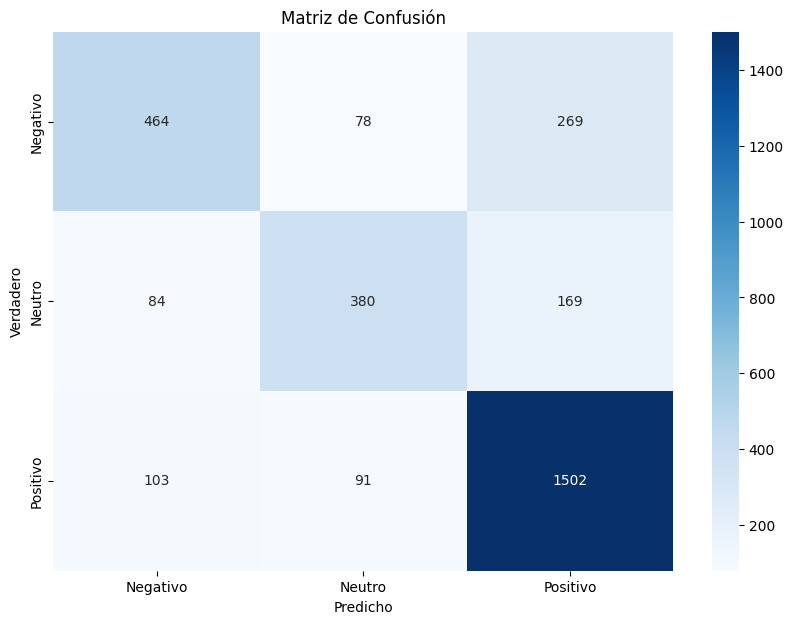

In [6]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Etiquetas personalizadas para las clases
class_labels = ['Negativo', 'Neutral', 'Positivo']

# Grafica la matriz de confusión como un mapa de calor
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

### OvR

In [11]:
# Codificación de las etiquetas
label_encoder = LabelEncoder()
encoded_y_sample = label_encoder.fit_transform(y_train)
# Configuración de GridSearchCV
param_grid = {
    'estimator__C': [0.1,1,10, 100, 500],
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__gamma': ['scale', 'auto'],
    'estimator__class_weight': [weights]  # Añadir pesos de clase aquí
}

# Creación del modelo y búsqueda de hiperparámetros
model = OneVsRestClassifier(SVC())
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, encoded_y_sample)

# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)
# Extrae los mejores parámetros y elimina el prefijo 'estimator__'
ovr_params = {k.replace('estimator__', ''): v for k, v in grid_search.best_params_.items()}




Mejores hiperparámetros: {'estimator__C': 1, 'estimator__class_weight': {0: 1.232710752145381, 1: 1.628, 2: 0.635110533159948}, 'estimator__gamma': 'scale', 'estimator__kernel': 'linear'}


In [12]:


# Crea y entrena el modelo SVM con los parámetros encontrados
model = OneVsRestClassifier(SVC(**ovr_params), n_jobs=-1)
model.fit(X_train, encoded_y_train)

# Evalúa el modelo
encoded_y_test = label_encoder.transform(y_test)
y_pred = model.predict(X_test)

# Convierte las predicciones codificadas de vuelta a etiquetas originales
y_pred = label_encoder.inverse_transform(y_pred)  



              precision    recall  f1-score   support

    Negative       0.70      0.61      0.65       811
     Neutral       0.70      0.67      0.68       633
    Positive       0.80      0.86      0.83      1696

    accuracy                           0.76      3140
   macro avg       0.73      0.72      0.72      3140
weighted avg       0.76      0.76      0.76      3140

Accuracy: 0.7598726114649682


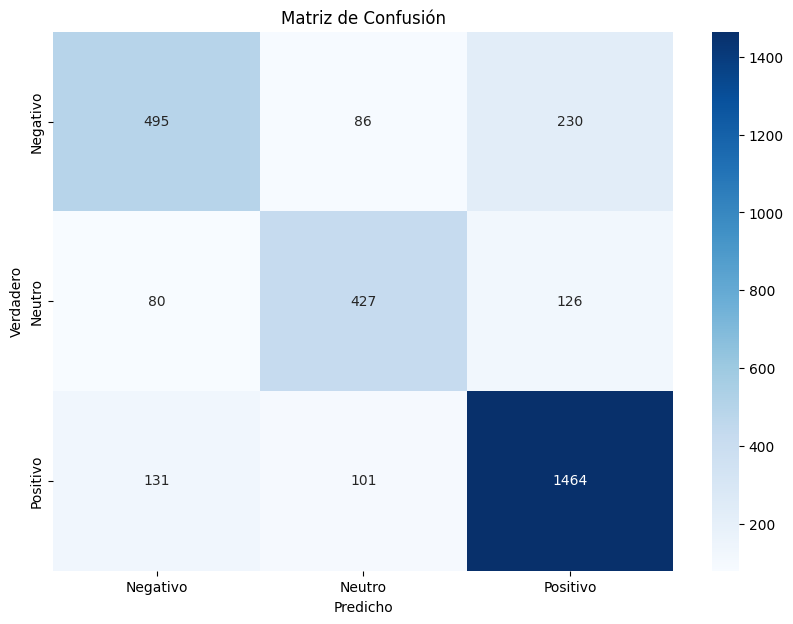

In [13]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Etiquetas personalizadas para las clases
class_labels = ['Negativo', 'Neutral', 'Positivo']

# Grafica la matriz de confusión como un mapa de calor
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

# Bert

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import AdamW
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import copy


In [18]:
def evaluate(model, val_loader):
    model.eval()
    total_eval_loss = 0
    predictions, true_labels = [], []

    for batch in val_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        total_eval_loss += outputs.loss.item()
        logits = outputs.logits
        probs = softmax(logits.detach().cpu().numpy(), axis=1)
        pred_labels = np.argmax(probs, axis=1)
        label_ids = b_labels.to('cpu').numpy()

        predictions.extend(pred_labels)
        true_labels.extend(label_ids.flatten())

    avg_val_accuracy = accuracy_score(true_labels, predictions)
    avg_val_loss = total_eval_loss / len(val_loader)

    return avg_val_accuracy, avg_val_loss



In [4]:
# Configuración de la GPU y optimizaciones de cudnn
torch.backends.cudnn.benchmark = True
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo y el tokenizador
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.to(device)
print("Modelo cargado exitosamente.")
# Carga de datos
df = pd.read_csv('comments.csv', sep='|')
comments = df['Comment']
labels = df['Sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})
print("Datos cargados exitosamente.")
# Tokenización y preparación de los datos
max_length = 128  # Tamañño de la secuencia
batch_size = 16  # Tamaño del lote 
input_ids = tokenizer(comments.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')['input_ids']
attention_masks = tokenizer(comments.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')['attention_mask']
labels = torch.tensor(labels.values)
print("Datos preparados exitosamente.")

# Crear TensorDataset y dividir en conjuntos de entrenamiento y validación
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))  # Cambiado a 80-20 split
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# Crear DataLoaders para la carga de datos en paralelo
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# Optimizador y Scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)  # Ajustamos la tasa de aprendizaje
epochs = 8  # número de épocas
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
print("Optimizador creado exitosamente.")


# Función de evaluación
def evaluate(model, val_loader):
    model.eval()
    total_eval_loss = 0
    predictions, true_labels = [], []

    for batch in val_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        total_eval_loss += outputs.loss.item()
        logits = outputs.logits
        probs = softmax(logits.detach().cpu().numpy(), axis=1)
        pred_labels = np.argmax(probs, axis=1)
        label_ids = b_labels.to('cpu').numpy()

        predictions.extend(pred_labels)
        true_labels.extend(label_ids.flatten())

    avg_val_accuracy = accuracy_score(true_labels, predictions)
    avg_val_loss = total_eval_loss / len(val_loader)

    return avg_val_accuracy, avg_val_loss

# Entrenamiento
# Inicializar variables para la parada temprana
best_val_accuracy = 0.0
best_val_loss = float('inf')  # Añadido para rastrear la mejor pérdida de validación
patience = 3  # Número de épocas para esperar una mejora antes de detener el entrenamiento
patience_counter = 0
# Inicializar variable para guardar el mejor modelo
best_model_state = None
best_epoch = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_loader):
        batch = [t.to(device) for t in batch]
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss}")

    # Evaluación después de cada época
    val_accuracy, val_loss = evaluate(model, val_loader)  
    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Validation Loss: {val_loss}")

    # Lógica de parada temprana basada en la precisión
    if val_accuracy > best_val_accuracy :
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            print(f"New best model found at epoch {epoch+1}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Parada temprana: La precisión de validación no ha mejorado en las últimas {patience} épocas.")
            break




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo cargado exitosamente.
Datos cargados exitosamente.
Datos preparados exitosamente.
Optimizador creado exitosamente.
Epoch 1/8 - Training Loss: 0.6438707343039621
Validation Accuracy: 0.8276026743075454
Validation Loss: 0.44157356035163386
New best model found at epoch 1
Epoch 2/8 - Training Loss: 0.3201061721237106
Validation Accuracy: 0.8486150907354346
Validation Loss: 0.446119898887536
New best model found at epoch 2
Epoch 3/8 - Training Loss: 0.17822318060016118
Validation Accuracy: 0.8605539637058262
Validation Loss: 0.5139565367095229
New best model found at epoch 3
Epoch 4/8 - Training Loss: 0.104721403189087
Validation Accuracy: 0.8610315186246418
Validation Loss: 0.7042244223181073
New best model found at epoch 4
Epoch 5/8 - Training Loss: 0.06298478941841029
Validation Accuracy: 0.8533906399235912
Validation Loss: 0.8188124682731173
Epoch 6/8 - Training Loss: 0.04150966877188402
Validation Accuracy: 0.8529130850047756
Validation Loss: 0.903388900551474
Epoch 7/8 - Train

In [20]:
def evaluateBestModel(model, val_loader):
    model.eval()
    total_eval_loss = 0
    predictions, true_labels = [], []

    for batch in val_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        total_eval_loss += outputs.loss.item()
        logits = outputs.logits
        probs = softmax(logits.detach().cpu().numpy(), axis=1)
        pred_labels = np.argmax(probs, axis=1)
        label_ids = b_labels.to('cpu').numpy()

        predictions.extend(pred_labels)
        true_labels.extend(label_ids.flatten())

    avg_val_accuracy = accuracy_score(true_labels, predictions)
    avg_val_loss = total_eval_loss / len(val_loader)

    return avg_val_accuracy, avg_val_loss, predictions, true_labels


Mejor modelo cargado
Validation Loss:  0.7042244223181073
Validation Accuracy:  0.8610315186246418


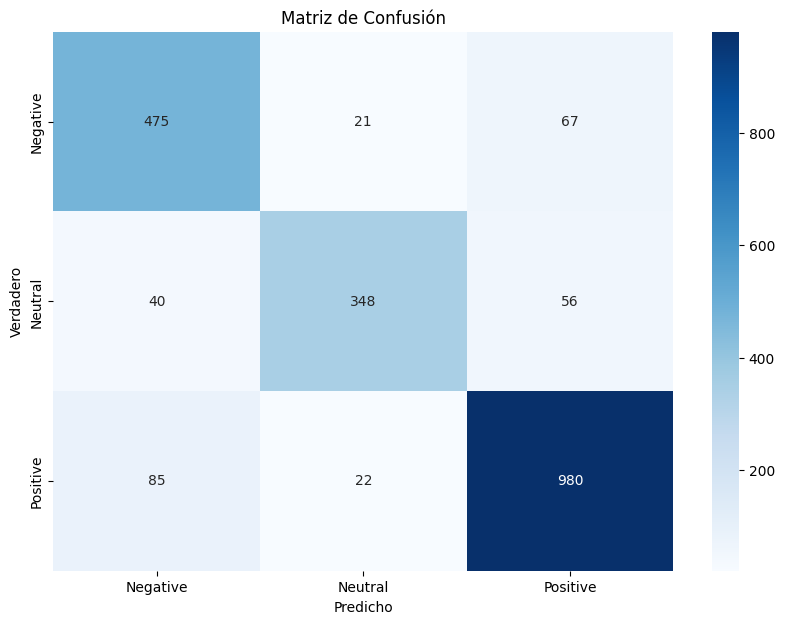

              precision    recall  f1-score   support

    Negative       0.79      0.84      0.82       563
     Neutral       0.89      0.78      0.83       444
    Positive       0.89      0.90      0.89      1087

    accuracy                           0.86      2094
   macro avg       0.86      0.84      0.85      2094
weighted avg       0.86      0.86      0.86      2094



In [21]:
# Carga el mejor estado del modelo
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Mejor modelo cargado")

    # Evalúa el modelo y obtiene las predicciones y las etiquetas verdaderas
    val_accuracy, val_loss, predictions, true_labels = evaluateBestModel(model, val_loader)

    print("Validation Loss: ", val_loss)
    print("Validation Accuracy: ", val_accuracy)

    # Calcula la matriz de confusión
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Etiquetas personalizadas para las clases
    class_labels = ['Negative', 'Neutral', 'Positive']

    # Grafica la matriz de confusión como un mapa de calor
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicho')
    plt.ylabel('Verdadero')
    plt.show()

    # Imprime el informe de clasificación
    print(classification_report(true_labels, predictions, target_names=class_labels, zero_division=0))



### Análisis de Resultados del Modelo BERT

In [14]:
def get_exclusive_important_words(important_words_summary):
    # Identificar palabras comunes entre sentimientos
    common_words = set()
    all_sentiments = list(important_words_summary.keys())

    for i, sentiment in enumerate(all_sentiments):
        other_sentiments = all_sentiments[:i] + all_sentiments[i+1:]
        words_current_sentiment = set(word for word, _ in important_words_summary[sentiment])

        for other in other_sentiments:
            words_other_sentiment = set(word for word, _ in important_words_summary[other])
            common_words.update(words_current_sentiment.intersection(words_other_sentiment))

    # Excluir palabras comunes y devolver las 10 palabras exclusivas más importantes por sentimiento
    exclusive_important_words = {}

    for sentiment, words in important_words_summary.items():
        exclusive_words = sorted([(word, count) for word, count in words if word not in common_words], key=lambda x: x[1], reverse=True)[:10]
        exclusive_important_words[sentiment] = exclusive_words

    return exclusive_important_words

# Llamada a la nueva función
exclusive_important_words_summary = get_exclusive_important_words(important_words_summary)

# Imprimir palabras exclusivas por sentimiento
for sentiment, words in exclusive_important_words_summary.items():
    print(f"Palabras más importantes exclusivas de comentarios de la clase {sentiment}:")
    for word, count in words:
        print(f"{word}: {count}")



Palabras más importantes exclusivas de comentarios de la clase Negative:
alice: 11
terrorist: 8
destroyer: 6
outlaw: 6
nightmare: 5
accident: 5
ur: 5
vial: 5
painfully: 5
700: 5
Palabras más importantes exclusivas de comentarios de la clase Neutral:
chair: 4
gemini: 2
brushed: 2
eagle: 2
°: 2
certified: 2
129: 2
tire: 2
repeats: 2
sideways: 2
Palabras más importantes exclusivas de comentarios de la clase Positive:
author: 18
beautiful: 18
bless: 15
grateful: 14
productivity: 14
technique: 13
3d: 13
loving: 12
oppose: 11
optimal: 11


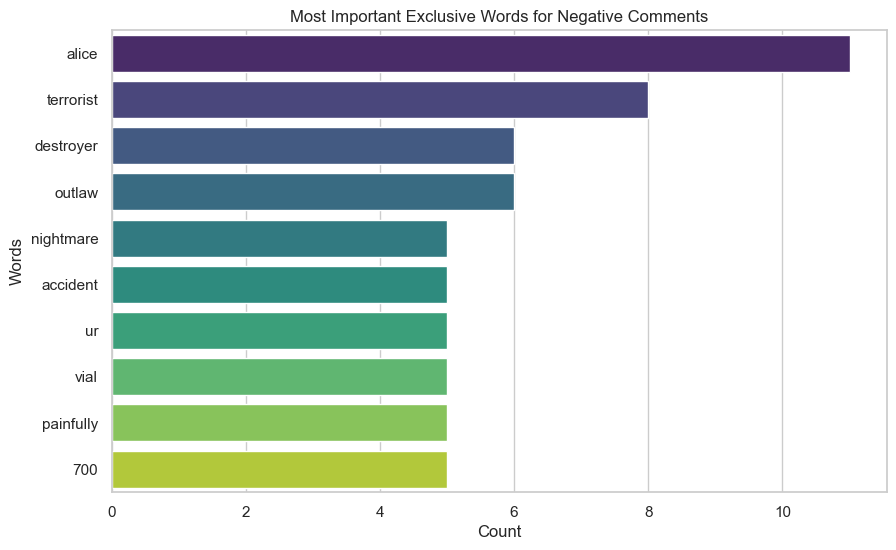

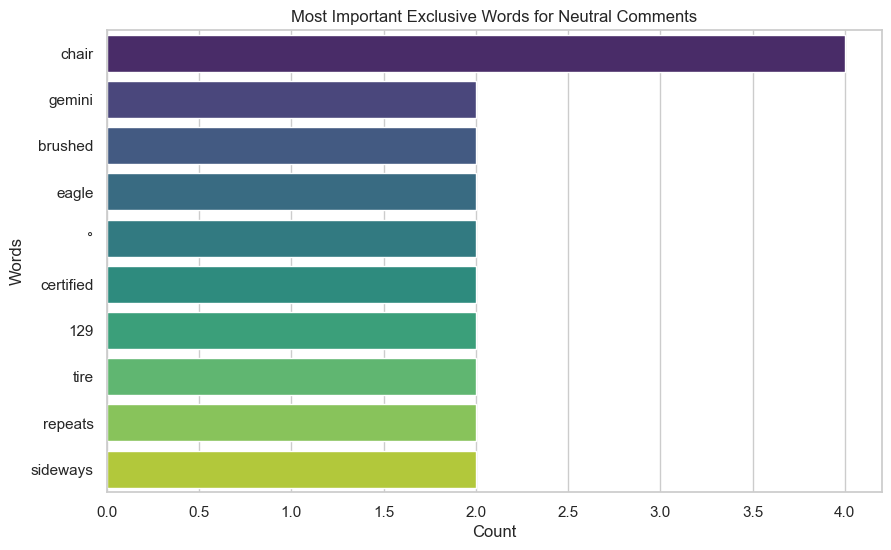

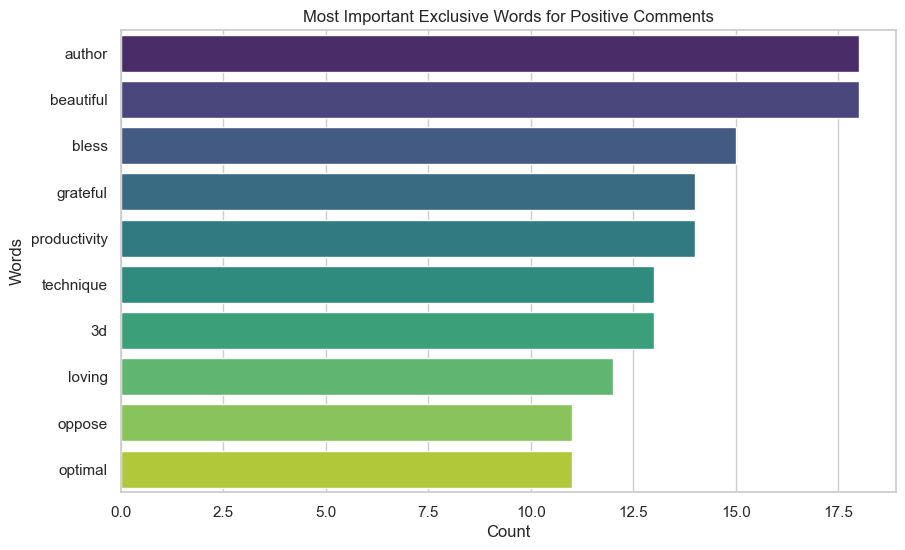

In [44]:

import seaborn as sns

# Establecer estilo de los gráficos
sns.set(style="whitegrid")

# Crear un gráfico de barras para cada sentimiento
for sentiment, words in exclusive_important_words_summary.items():
    plt.figure(figsize=(10, 6))  # Tamaño del gráfico
    words, counts = zip(*words)  # Separar palabras y conteos

    # Crear DataFrame para Seaborn
    data = pd.DataFrame({'Word': words, 'Count': counts})

    # Crear el gráfico de barras
    sns.barplot(x='Count', y='Word', data=data, hue='Word', dodge=False, palette='viridis')
    plt.legend([],[], frameon=False)  # Eliminar leyenda

    # Títulos y etiquetas
    plt.title(f'Most Important Exclusive Words for {sentiment.capitalize()} Comments')
    plt.xlabel('Count')
    plt.ylabel('Words')

    # Mostrar el gráfico
    plt.show()



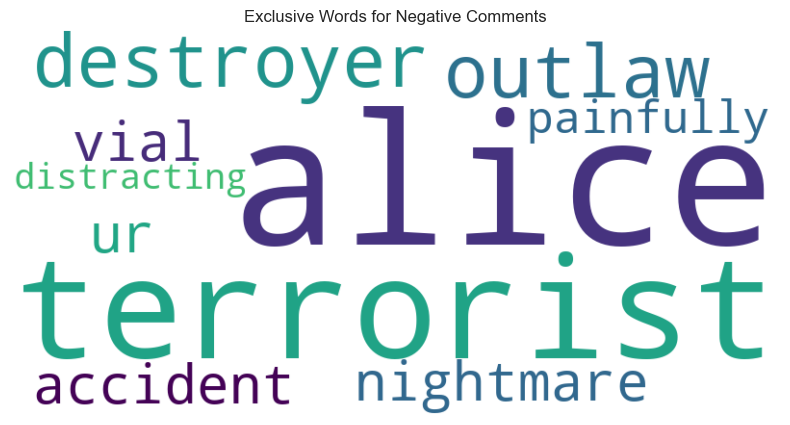

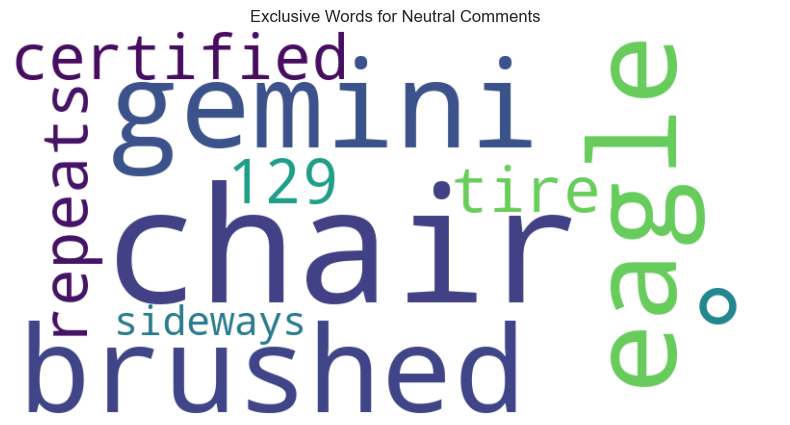

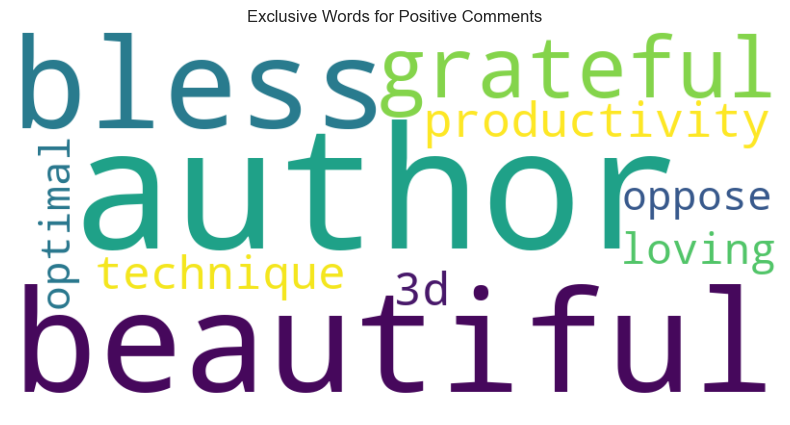

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Función para generar una nube de palabras
def generate_wordcloud(words_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_dict)
    
    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generar y mostrar una nube de palabras para cada sentimiento
for sentiment, words in exclusive_important_words_summary.items():
    # Crear un diccionario de palabras y sus frecuencias
    words_dict = {word: count for word, count in words}
    
    # Generar y mostrar la nube de palabras
    generate_wordcloud(words_dict, f'Exclusive Words for {sentiment.capitalize()} Comments')


In [49]:
# Suponiendo que df es tu DataFrame y 'TextData' es la columna con los comentarios
# Asumiendo que df es tu DataFrame y 'TextData' es la columna con los comentarios

# Función para encontrar comentarios con palabras clave exclusivas
def find_comments_with_exclusive_words(df, exclusive_words):
    comments_by_sentiment = {sentiment: [] for sentiment in exclusive_words}

    for index, row in df.iterrows():
        text = row['TextData']
        sentiment = row['Sentiment']

        # Verificar si el comentario contiene alguna de las palabras clave exclusivas
        for word in exclusive_words[sentiment]:
            if word in text.split():  # Asumiendo que las palabras están separadas por espacios
                comments_by_sentiment[sentiment].append(text)
                break  # Solo necesitamos saber si al menos una palabra clave está presente

    return comments_by_sentiment

# Extraer las 10 palabras clave exclusivas para cada sentimiento
exclusive_words_by_sentiment = {sentiment: [word for word, _ in words] for sentiment, words in exclusive_important_words_summary.items()}

# Encontrar comentarios
comments_with_exclusive_words = find_comments_with_exclusive_words(df, exclusive_words_by_sentiment)

# Imprimir algunos comentarios para cada sentimiento
for sentiment, comments in comments_with_exclusive_words.items():
    print(f"\nComments with exclusive words for {sentiment} sentiment:")
    for comment in comments[:5]:  # Mostrar solo los primeros 5 comentarios para cada sentimiento
        print(f"- {comment}")




Comments with exclusive words for Negative sentiment:

Comments with exclusive words for Neutral sentiment:

Comments with exclusive words for Positive sentiment:


In [50]:
exclusive_words_by_sentiment

{'Negative': ['alice',
  'terrorist',
  'destroyer',
  'outlaw',
  'nightmare',
  'accident',
  'ur',
  'vial',
  'painfully',
  'distracting'],
 'Neutral': ['chair',
  'gemini',
  'brushed',
  'eagle',
  '°',
  'certified',
  '129',
  'tire',
  'repeats',
  'sideways'],
 'Positive': ['author',
  'beautiful',
  'bless',
  'grateful',
  'productivity',
  'technique',
  '3d',
  'loving',
  'oppose',
  'optimal']}

In [33]:
from collections import Counter, defaultdict
# Combine the words and their counts across sentiments
combined_word_counts = Counter()
for words in important_words_by_sentiment.values():
    combined_word_counts.update(words)

# Find the common words across all sentiments and their counts
common_words_across_sentiments = defaultdict(dict)
for word, _ in combined_word_counts.items():
    for sentiment, words in important_words_by_sentiment.items():
        common_words_across_sentiments[word][sentiment] = words.count(word)

# Sort the words based on frequency and create the final list
important_words_summary = {}
for word, counts in common_words_across_sentiments.items():
    total_count = sum(counts.values())
    if total_count > 518:  # Change this number based on how frequently you want the words to appear to be included
        important_words_summary[word] = counts

# Sort by the total count across all sentiments
important_words_summary_sorted = sorted(
    important_words_summary.items(),
    key=lambda item: sum(item[1].values()),
    reverse=True
)

# Print the sorted important words with counts for each sentiment
for word, counts in important_words_summary_sorted:
    print(f"Word: '{word}'")
    for sentiment, count in counts.items():
        print(f"  {sentiment}: {count}")
        
    print(f"  Total count: {sum(counts.values())}")

Word: 'be'
  Negative: 575
  Neutral: 290
  Positive: 919
  Total count: 1784
Word: 's'
  Negative: 437
  Neutral: 223
  Positive: 697
  Total count: 1357
Word: '?'
  Negative: 366
  Neutral: 448
  Positive: 517
  Total count: 1331
Word: 'sam'
  Negative: 278
  Neutral: 193
  Positive: 595
  Total count: 1066
Word: '!'
  Negative: 206
  Neutral: 220
  Positive: 625
  Total count: 1051
Word: 'not'
  Negative: 361
  Neutral: 171
  Positive: 517
  Total count: 1049
Word: 'like'
  Negative: 167
  Neutral: 27
  Positive: 739
  Total count: 933
Word: 'lex'
  Negative: 155
  Neutral: 137
  Positive: 553
  Total count: 845
Word: ':'
  Negative: 165
  Neutral: 133
  Positive: 364
  Total count: 662
Word: 'think'
  Negative: 171
  Neutral: 119
  Positive: 364
  Total count: 654
Word: 'chat'
  Negative: 188
  Neutral: 142
  Positive: 323
  Total count: 653
Word: 'person'
  Negative: 213
  Neutral: 61
  Positive: 322
  Total count: 596
Word: 'human'
  Negative: 175
  Neutral: 84
  Positive: 319
  

## Investigación Personal

In [19]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from captum.attr import IntegratedGradients

# Preparar una muestra del conjunto de validación para el análisis
sample_size = 10  # Ajustamos el tamaño de la muestra
sample_dataset, _ = random_split(val_dataset, [sample_size, len(val_dataset) - sample_size])
sample_loader = DataLoader(sample_dataset, batch_size=1)

# Función de forward
def forward_func(input_ids, attention_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones_like(input_ids)

    # Obtener los logits del modelo
    logits = model(input_ids.long(), attention_mask=attention_mask.long())[0]

    # Seleccionar el logit de la clase con la puntuación más alta (o una clase específica)
    return torch.max(logits, dim=1).values


# Integrated Gradients
ig = IntegratedGradients(forward_func)

# Bucle para procesar el conjunto de datos de muestra
for batch in sample_loader:
    b_input_ids, b_attention_mask, _ = [t.to(device) for t in batch]

    # Baseline (usando una frase específica)
    baseline_text = "El tema es OpenAI."
    baseline_ids = tokenizer.encode(baseline_text, return_tensors='pt', max_length=128, truncation=True, padding='max_length').to(device)
    baseline_mask = torch.zeros_like(baseline_ids).to(device)

    # Calcular atribuciones
    attributions = ig.attribute(inputs=(b_input_ids, b_attention_mask), 
                                baselines=(baseline_ids, baseline_mask))

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [6]:

# Carga del modelo y tokenizador
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Preparar el input
input_text = "El tema es OpenAI."
inputs = tokenizer(input_text, return_tensors='pt', max_length=128, truncation=True, padding=True)
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# Baseline
baseline_ids = torch.zeros_like(input_ids).to(device)
baseline_mask = torch.zeros_like(attention_mask).to(device)

# Función de forward
def forward_func(input_ids, attention_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones_like(input_ids)

    # Obtener los logits del modelo
    logits = model(input_ids.long(), attention_mask=attention_mask.long())[0]

    # Seleccionar el logit de la clase con la puntuación más alta (o una clase específica)
    return torch.max(logits, dim=1).values

# Calcula las atribuciones usando IntegratedGradients
ig = IntegratedGradients(forward_func)
try:
    attributions, delta = ig.attribute((input_ids, attention_mask), 
                                       baselines=(baseline_ids, baseline_mask), 
                                       return_convergence_delta=True)
    print("Atribuciones calculadas con éxito.")
except Exception as e:
    print(f"Error al calcular atribuciones: {e}")





Error al calcular atribuciones: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.


In [26]:
# Ejemplo de tokenización y verificación de tipos
sample_text = "Este es un texto de ejemplo."
encoded_input = tokenizer(sample_text, return_tensors='pt')
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)

print(f"Tipo de input_ids: {input_ids.dtype}")
print(f"Tipo de attention_mask: {attention_mask.dtype}")

def model_wrapper(input_ids, attention_mask=None):
    # Convertir a LongTensor si es necesario
    input_ids = input_ids if input_ids.dtype == torch.long else input_ids.long()
    if attention_mask is not None:
        attention_mask = attention_mask if attention_mask.dtype == torch.long else attention_mask.long()

    # Llamada al modelo
    return model(input_ids, attention_mask=attention_mask)



Tipo de input_ids: torch.int64
Tipo de attention_mask: torch.int64


In [27]:
from tqdm import tqdm
from captum.attr import IntegratedGradients

# Función para calcular atribuciones
def calculate_attributions(model, data_loader):
    model.eval()
    attributions = []

    for batch in tqdm(data_loader, desc="Calculating attributions"):
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        # Verificación de tipos y formas
        print(f"Input IDs type: {b_input_ids.dtype}, shape: {b_input_ids.shape}")
        print(f"Attention Mask type: {b_input_mask.dtype}, shape: {b_input_mask.shape}")
        print(f"Labels type: {b_labels.dtype}, shape: {b_labels.shape}")

        ig = IntegratedGradients(model)

        try:
            batch_attributions = ig.attribute(b_input_ids, additional_forward_args=(None, b_input_mask), target=b_labels)
            attributions.append(batch_attributions.sum(dim=-2).detach().cpu())
        except RuntimeError as e:
            print(f"Error al calcular atribuciones: {e}")
            break

    # Concatenar todas las atribuciones si no hay errores
    if attributions:
        all_attributions = torch.cat(attributions, dim=0)
        return all_attributions
    else:
        return None

ig = IntegratedGradients(model_wrapper)
# Calcular atribuciones para todo el conjunto de validación
all_attributions = calculate_attributions(model, val_loader)

if all_attributions is not None:
    # Realizar análisis sobre all_attributions si no hay errores
    total_attributions = all_attributions.sum(dim=0)
    sorted_indices = torch.argsort(total_attributions, descending=True)
    # Mostrar los tokens más influyentes
    for idx in sorted_indices[:10]:  # Cambia 10 por el número de palabras que quieras ver
        token = tokenizer.convert_ids_to_tokens([idx.item()])[0]
        attribution = total_attributions[idx].item()
        print(f"Token: {token}, Attribution: {attribution}")
else:
    print("No se pudieron calcular las atribuciones.")





Calculating attributions:   0%|                                                                | 0/131 [00:00<?, ?it/s]

Input IDs type: torch.int64, shape: torch.Size([16, 128])
Attention Mask type: torch.int64, shape: torch.Size([16, 128])
Labels type: torch.int64, shape: torch.Size([16])
Error al calcular atribuciones: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)


Calculating attributions:   0%|                                                                | 0/131 [00:07<?, ?it/s]

No se pudieron calcular las atribuciones.


In [29]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from captum.attr import IntegratedGradients
from tqdm import tqdm

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo y el tokenizador preentrenados
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.to(device)
# Comentarios y etiquetas de ejemplo
comments = ["Este es un buen ejemplo.", "Este es un mal ejemplo."]
labels = [1, 0]  # Suponiendo etiquetas binarias

# Preparar los datos
encoded_inputs = tokenizer(comments, padding=True, truncation=True, max_length=128, return_tensors='pt')
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']
labels = torch.tensor(labels)

# DataLoader
val_dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
val_loader = DataLoader(val_dataset, batch_size=16)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
def model_wrapper(input_ids, attention_mask=None):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device) if attention_mask is not None else None
    return model(input_ids, attention_mask=attention_mask)

def calculate_attributions(model, data_loader):
    model.eval()
    attributions = []

    for batch in tqdm(data_loader, desc="Calculating attributions"):
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        ig = IntegratedGradients(model_wrapper)
        try:
            batch_attributions = ig.attribute(b_input_ids, additional_forward_args=(b_input_mask), target=b_labels)
            attributions.append(batch_attributions.sum(dim=-2).detach().cpu())
        except RuntimeError as e:
            print(f"Error al calcular atribuciones: {e}")
            break

    if attributions:
        all_attributions = torch.cat(attributions, dim=0)
        return all_attributions
    else:
        return None

# Calcular atribuciones para todo el conjunto de validación
all_attributions = calculate_attributions(model, val_loader)

# Análisis de las atribuciones (si están disponibles)
if all_attributions is not None:
    total_attributions = all_attributions.sum(dim=0)
    sorted_indices = torch.argsort(total_attributions, descending=True)

    for idx in sorted_indices[:10]:  
        token = tokenizer.convert_ids_to_tokens([idx.item()])[0]
        attribution = total_attributions[idx].item()
        print(f"Token: {token}, Attribution: {attribution}")
else:
    print("No se pudieron calcular las atribuciones.")


Calculating attributions:   0%|                                                                  | 0/1 [00:00<?, ?it/s]

Error al calcular atribuciones: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)
No se pudieron calcular las atribuciones.


In [36]:
def forward_func(input_ids, attention_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones_like(input_ids)

    input_ids = input_ids.long()
    attention_mask = attention_mask.long()

    # Realizar la inferencia y obtener los logits (sin torch.no_grad())
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.logits


def calculate_attributions(model, data_loader):
    model.eval()
    attributions = []

    for batch in tqdm(data_loader, desc="Calculating attributions"):
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        ig = IntegratedGradients(forward_func)

        try:
            # Agregar allow_unused=True
            batch_attributions = ig.attribute(b_input_ids, additional_forward_args=b_input_mask, target=b_labels, allow_unused=True)
            attributions.append(batch_attributions.sum(dim=-2).detach().cpu())

        except RuntimeError as e:
            print(f"Error al calcular atribuciones: {e}")
            break

    if attributions:
        all_attributions = torch.cat(attributions, dim=0)
        return all_attributions
    else:
        return None


    
# Obtener un solo ejemplo del conjunto de validación
single_example_loader = DataLoader(val_dataset, batch_size=1)
single_batch = next(iter(single_example_loader))
b_input_ids, b_input_mask, b_labels = [t.to(device) for t in single_batch]

# Instanciar IntegratedGradients con la función forward modificada
ig = IntegratedGradients(forward_func)

try:
    # Calcular atribuciones para un solo ejemplo
    single_attributions = ig.attribute(b_input_ids, additional_forward_args=b_input_mask, target=b_labels)
    print("Atribuciones calculadas con éxito para un solo ejemplo.")
except Exception as e:
    print(f"Error al calcular atribuciones para un solo ejemplo: {e}")




Error al calcular atribuciones para un solo ejemplo: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.


In [8]:
from transformers import pipeline
from collections import Counter

# Conjunto de tokens a excluir
exclude_tokens = {',', '.', "'", '-', '"', '[', ']', 'º', '{', '}', '[SEP]', '[CLS]'}

def get_important_words(text, model, tokenizer):
    input_ids = tokenizer.encode(text, return_tensors='pt', max_length=512, truncation=True).to(device)
    outputs = model(input_ids, output_attentions=True)
    attentions = outputs[-1]
    last_layer_attentions = attentions[-1][0]
    mean_attentions = last_layer_attentions.mean(dim=0).squeeze()
    
    # Manejamos múltiples dimensiones si es necesario
    if mean_attentions.dim() > 1:
        mean_attentions = mean_attentions.mean(dim=-1)
    
    # Convertir los IDs de tokens a tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Crear pares de tokens y sus valores de atención, excluyendo los tokens no deseados
    token_attention_pairs = [
        (token, attention.item()) for token, attention in zip(tokens, mean_attentions)
        if token not in exclude_tokens and not token.startswith('##')
    ]
    
    # Ordenar por atención, de mayor a menor
    sorted_tokens = sorted(token_attention_pairs, key=lambda x: x[1], reverse=True)
    return sorted_tokens

important_words_by_sentiment = {
    'Negative': [],
    'Neutral': [],
    'Positive': []
}

# Iteramos sobre el dataframe y obtener las palabras importantes para cada comentario
for index, row in df.iterrows():
    sentiment = row['Sentiment']
    text = row['TextData']
    important_words = get_important_words(text, model, tokenizer)
    # Solo almacenar las palabras (tokens), no los valores de atención
    important_words_by_sentiment[sentiment].extend([word for word, _ in important_words])

    # Contamos las ocurrencias de cada palabra para cada sentimiento
word_counts = {
    sentiment: Counter(word_list)
    for sentiment, word_list in important_words_by_sentiment.items()
}
# Ordenamos las palabras basándose en la frecuencia y crear la lista final
important_words_summary = {
    sentiment: sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
    for sentiment, word in word_counts.items() 
}

#Imprimimos la lista de palabras importantes por sentimiento junto al número de apariciones
for sentiment, words in important_words_summary.items():
            print(f"Palabras más importantes para los comentarios de clase {sentiment}:")
            for word, count in words:
                print(f"{word}: {count}")



KeyboardInterrupt: 

In [13]:
from transformers import pipeline
from collections import Counter
import torch

# Asegúrate de que estas líneas estén en tu código para inicializar el modelo y el tokenizer
# model = ...  # Tu modelo ya inicializado
# tokenizer = ...  # Tu tokenizer ya inicializado
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

exclude_tokens = {',', '.', "'", '-', '"', '[', ']', 'º', '?','!','{', '}', '[SEP]', '[CLS]', 's', ':'}

def get_important_words(text, model, tokenizer):
    input_ids = tokenizer.encode(text, return_tensors='pt', max_length=512, truncation=True).to(device)
    outputs = model(input_ids, output_attentions=True)
    attentions = outputs[-1]
    last_layer_attentions = attentions[-1][0]
    mean_attentions = last_layer_attentions.mean(dim=0).squeeze()

    if mean_attentions.dim() > 1:
        mean_attentions = mean_attentions.mean(dim=-1)
    
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    token_attention_pairs = [
        (token, attention.item()) for token, attention in zip(tokens, mean_attentions)
        if token not in exclude_tokens and not token.startswith('##')
    ]

    sorted_tokens = sorted(token_attention_pairs, key=lambda x: x[1], reverse=True)
    return sorted_tokens

# Asegúrate de que df esté definido y tenga las columnas 'Sentiment' y 'TextData'
# df = ...  # Tu DataFrame

important_words_by_sentiment = {'Negative': [], 'Neutral': [], 'Positive': []}

# Iteración sobre el DataFrame
for index, row in df.iterrows():
    sentiment = row['Sentiment']
    text = row['TextData']
    important_words = get_important_words(text, model, tokenizer)
    important_words_by_sentiment[sentiment].extend([word for word, _ in important_words])

    # Agregamos impresión para depuración
    print(f"Palabras importantes: {important_words[:5]}")  # Imprime las primeras 5 palabras importantes

# Conteo de palabras
word_counts = {
    sentiment: Counter(word_list)
    for sentiment, word_list in important_words_by_sentiment.items()
}

# Resumen de palabras importantes
important_words_summary = {
    sentiment: sorted(word_counts[sentiment].items(), key=lambda item: item[1], reverse=True)
    for sentiment in word_counts
}

# Impresión de los resultados
for sentiment, words in important_words_summary.items():
    print(f"Palabras más importantes para los comentarios de clase {sentiment}:")
    for word, count in words[:10]:  # Imprime las 10 palabras más frecuentes
        print(f"{word}: {count}")


Palabras importantes: [('know', 0.012820514850318432), ('*', 0.012820514850318432), ('kind', 0.012820514850318432), ('not', 0.012820512987673283), ('mean', 0.012820512987673283)]
Palabras importantes: [('be', 0.007812500931322575), ('miss', 0.007812500931322575), ('be', 0.0078125), ('software', 0.0078125), ('development', 0.0078125)]
Palabras importantes: [('i', 0.016393443569540977), ('plot', 0.016393441706895828), ('twist', 0.016393441706895828), ('jimmy', 0.016393441706895828), ('apples', 0.016393441706895828)]
Palabras importantes: [('penalty', 0.008620690554380417), ('thanks', 0.008620689623057842), ('video', 0.008620689623057842), ('interesting', 0.008620689623057842), ('see', 0.008620689623057842)]
Palabras importantes: [('be', 0.06666667014360428), ('threat', 0.06666667014360428), ('humanity', 0.06666667014360428)]
Palabras importantes: [('ag', 0.012658230029046535), ('ag', 0.012658228166401386), ('/', 0.012658228166401386), ('as', 0.012658228166401386), ('say', 0.0126582281664

Palabras importantes: [('every', 0.01923077180981636), ('certain', 0.01923076994717121), ('comment', 0.01923076994717121), ('opinion', 0.01923076994717121), ('video', 0.01923076994717121)]
Palabras importantes: [('i', 0.0476190485060215), ('’', 0.0476190485060215), ('ll', 0.0476190485060215), ('probably', 0.0476190485060215), ('die', 0.0476190485060215)]
Palabras importantes: [('not', 0.008849558420479298), ('artificial', 0.008849558420479298), ('achieve', 0.008849557489156723), ('ag', 0.008849557489156723), ('mean', 0.008849557489156723)]
Palabras importantes: [('imagine', 0.022727273404598236), ('arrival', 0.022727273404598236), ('end', 0.022727273404598236), ('game', 0.022727273404598236), ('screen', 0.022727273404598236)]
Palabras importantes: [('shame', 0.0117647061124444), ('use', 0.0117647061124444), ('click', 0.0117647061124444), ('bait', 0.0117647061124444), ('…', 0.0117647061124444)]
Palabras importantes: [('roman', 0.0019531252328306437), ('outline', 0.0019531252328306437), 

Palabras importantes: [('destructive', 0.0030487808398902416), ('type', 0.0030487808398902416), ('way', 0.0030487808398902416), ('think', 0.0030487808398902416), ('intelligence', 0.0030487808398902416)]
Palabras importantes: [('even', 0.006060606800019741), ('ag', 0.0060606058686971664), ('encompass', 0.0060606058686971664), ('desire', 0.0060606058686971664), ('pro', 0.0060606058686971664)]
Palabras importantes: [('anyone', 0.032258063554763794), ('afraid', 0.032258063554763794), ('be', 0.032258063554763794), ('never', 0.032258063554763794), ('raise', 0.032258063554763794)]
Palabras importantes: [('current', 0.00990099087357521), ('state', 0.00990099087357521), ('ever', 0.009900989942252636), ('since', 0.009900989942252636), ('nicholas', 0.009900989942252636)]
Palabras importantes: [('subjective', 0.01515151746571064), ('progress', 0.01515151746571064), ('need', 0.01515151746571064), ('h', 0.01515151560306549), ('make', 0.01515151560306549)]
Palabras importantes: [('i', 0.0103092780336

Palabras importantes: [('coffee', 0.012987014837563038), ('imagine', 0.012987012974917889), ('much', 0.012987012974917889), ('computing', 0.012987012974917889), ('q', 0.012987012974917889)]
Palabras importantes: [('shall', 0.05263158679008484), ('inherit', 0.05263158679008484), ('meek', 0.05263157933950424), ('earth', 0.05263157933950424)]
Palabras importantes: [('google', 0.004524887539446354), ('year', 0.004524887539446354), ('ha', 0.004524887539446354), ('author', 0.004524887073785067), ('speak', 0.004524887073785067)]
Palabras importantes: [('ag', 0.011627906933426857), ('can', 0.011627906933426857), ('not', 0.011627906933426857), ('achieve', 0.011627906933426857), ('ll', 0.011627906933426857)]
Palabras importantes: [('make', 0.02222222276031971), ('al', 0.02222222276031971), ('sense', 0.02222222276031971), ('board', 0.02222222276031971), ('won', 0.02222222276031971)]
Palabras importantes: [('person', 0.0181818176060915), ('go', 0.0181818176060915), ('accept', 0.0181818176060915), 

Palabras importantes: [('open', 0.004739337135106325), ('language', 0.004739337135106325), ('obvious', 0.004739336669445038), ('step', 0.004739336669445038), ('forward', 0.004739336669445038)]
Palabras importantes: [('span', 0.01587301678955555), ('month', 0.01587301678955555), ('got', 0.01587301678955555), ('transform', 0.01587301678955555), ('good', 0.01587301678955555)]
Palabras importantes: [('person', 0.01562500186264515), ('ok', 0.015625), ('let', 0.015625), ('mentally', 0.015625), ('ill', 0.015625)]
Palabras importantes: [('math', 0.011904763989150524), ('heck', 0.011904763989150524), ('generation', 0.011904763989150524), ('good', 0.011904763989150524), ('grade', 0.011904762126505375)]
Palabras importantes: [('another', 0.0416666679084301), ('fake', 0.0416666679084301), ('h', 0.0416666679084301), ('video', 0.0416666679084301)]
Palabras importantes: [('human', 0.020000001415610313), ('fa', 0.020000001415610313), ('honest', 0.019999999552965164), ('even', 0.019999999552965164), ('

Palabras importantes: [('not', 0.003584229853004217), ('employee', 0.003584229853004217), ('human', 0.00358422938734293), ('fear', 0.00358422938734293), ('thing', 0.00358422938734293)]
Palabras importantes: [('today', 0.03030303493142128), ('singular', 0.03030303120613098), ('letter', 0.03030303120613098), ('q', 0.03030303120613098), ('bring', 0.030303029343485832)]
Palabras importantes: [('be', 0.024390242993831635), ('modern', 0.024390242993831635), ('video', 0.024390242993831635), ('game', 0.024390242993831635), ('still', 0.024390242993831635)]
Palabras importantes: [('excited', 0.021276596933603287), ('time', 0.021276596933603287), ('achieve', 0.021276595070958138), ('sure', 0.021276595070958138), ('doubt', 0.021276595070958138)]
Palabras importantes: [('handle', 0.0019531252328306437), ('e', 0.0019531252328306437), ('run', 0.0019531252328306437), ('fast', 0.0019531252328306437), ('possible', 0.0019531252328306437)]
Palabras importantes: [('invest', 0.04347826540470123), ('take', 0

Palabras importantes: [('alt', 0.04545454680919647), ('praise', 0.04545454680919647)]
Palabras importantes: [('fusion', 0.002557544969022274), ('value', 0.002557544969022274), ('\\', 0.0025575447361916304), ('u2', 0.0025575447361916304), ('sam', 0.0025575447361916304)]
Palabras importantes: [('powerful', 0.009259260259568691), ('be', 0.009259260259568691), ('not', 0.009259260259568691), ('1', 0.009259259328246117), ('be', 0.009259259328246117)]
Palabras importantes: [('war', 0.023255815729498863), ('probably', 0.023255813866853714), ('miss', 0.023255813866853714), ('mark', 0.023255813866853714), ('least', 0.023255813866853714)]
Palabras importantes: [('mark', 0.032258063554763794), ('dune', 0.032258063554763794), ('prophecy', 0.032258063554763794), ('fiction', 0.032258063554763794), ('entertainment', 0.032258063554763794)]
Palabras importantes: [('tr', 0.029411764815449715), ('nature', 0.029411764815449715), ('game', 0.029411764815449715)]
Palabras importantes: [('shall', 0.02857142873

Palabras importantes: [('corridor', 0.012658230029046535), ('rude', 0.012658230029046535), ('clip', 0.012658228166401386), ('show', 0.012658228166401386), ('actually', 0.012658228166401386)]
Palabras importantes: [('chat', 0.012820512987673283), ('be', 0.012820512987673283), ('server', 0.012820512987673283), ('sit', 0.012820512987673283), ('cloud', 0.012820512987673283)]
Palabras importantes: [('thanks', 0.025641025975346565), ('high', 0.025641025975346565), ('quality', 0.025641025975346565), ('content', 0.025641025975346565), ('video', 0.025641025975346565)]
Palabras importantes: [('find', 0.0416666679084301), ('he', 0.0416666679084301), ('gay', 0.0416666679084301), ('thanks', 0.0416666679084301)]
Palabras importantes: [('love', 0.012345679104328156), ('you', 0.012345679104328156), ('man', 0.012345679104328156), ('brilliant', 0.012345679104328156), ('really', 0.012345679104328156)]
Palabras importantes: [('update', 0.01666666939854622), ('may', 0.01666666939854622), ('be', 0.016666667

Palabras importantes: [('middle', 0.0032467537093907595), ('non', 0.003246753243729472), ('versus', 0.003246753243729472), ('profit', 0.003246753243729472), ('historically', 0.003246753243729472)]
Palabras importantes: [('always', 0.019607843831181526), ('good', 0.019607843831181526), ('episode', 0.019607843831181526), ('endeavor', 0.019607843831181526), ('future', 0.019607843831181526)]
Palabras importantes: [('one', 0.09090909361839294), ('india', 0.09090909361839294)]
Palabras importantes: [('u', 0.02222222276031971), ('read', 0.02222222276031971), ('paper', 0.02222222276031971), ('make', 0.02222222276031971), ('statement', 0.02222222276031971)]
Palabras importantes: [('thank', 0.03030303493142128), ('exceptional', 0.03030303120613098), ('[UNK]', 0.03030303120613098), ('great', 0.03030303120613098), ('video', 0.03030303120613098)]
Palabras importantes: [('extinct', 0.0029239768628031015), ('tb', 0.002923976629972458), ('sam', 0.002923976629972458), ('alt', 0.002923976629972458), ('g

Palabras importantes: [('mas', 0.012345680966973305), ('bunch', 0.012345679104328156), ('psycho', 0.012345679104328156), ('inn', 0.012345679104328156), ('the', 0.012345679104328156)]
Palabras importantes: [('mention', 0.01315789669752121), ('sam', 0.01315789669752121), ('yo', 0.01315789483487606), ('narrator', 0.01315789483487606), ('bot', 0.01315789483487606)]
Palabras importantes: [('back', 0.02500000409781933), ('really', 0.02500000037252903), ('wish', 0.02500000037252903), ('go', 0.02500000037252903), ('90', 0.02500000037252903)]
Palabras importantes: [('probably', 0.0476190485060215), ('another', 0.0476190485060215), ('po', 0.0476190485060215)]
Palabras importantes: [('sexuality', 0.06666667014360428), ('anything', 0.06666667014360428)]
Palabras importantes: [('be', 0.004608295392245054), ('good', 0.004608294926583767), ('evil', 0.004608294926583767), ('note', 0.004608294926583767), ('ever', 0.004608294926583767)]
Palabras importantes: [('not', 0.0019531252328306437), ('scale', 0.

Palabras importantes: [('dude', 0.043478261679410934), ('real', 0.043478261679410934), ('life', 0.043478261679410934), ('bob', 0.043478261679410934), ('page', 0.043478261679410934)]
Palabras importantes: [('celebrate', 0.0019531252328306437), ('self', 0.0019531252328306437), ('chat', 0.0019531252328306437), ('tell', 0.0019531252328306437), ('spend', 0.0019531252328306437)]
Palabras importantes: [('3', 0.004366812761873007), ('worry', 0.004366812761873007), ('it', 0.004366812761873007), ('we', 0.004366812761873007), ('necessary', 0.004366812761873007)]
Palabras importantes: [('abandon', 0.0178571455180645), ('anyone', 0.01785714365541935), ('smell', 0.01785714365541935), ('rat', 0.01785714365541935), ('el', 0.01785714365541935)]
Palabras importantes: [('change', 0.0625), ('name', 0.0625), ('closed', 0.0625)]
Palabras importantes: [('exactly', 0.011904762126505375), ('google', 0.011904762126505375), ('location', 0.011904762126505375), ('share', 0.011904762126505375), ('service', 0.011904

Palabras importantes: [('remember', 0.016949154436588287), ('always', 0.016949152573943138), ('can', 0.016949152573943138), ('not', 0.016949152573943138), ('control', 0.016949152573943138)]
Palabras importantes: [('fact', 0.007194244768470526), ('alt', 0.007194244768470526), ('doom', 0.007194244768470526), ('prep', 0.007194244768470526), ('tell', 0.007194244768470526)]
Palabras importantes: [('still', 0.003906250465661287), ('car', 0.003906250465661287), ('car', 0.003906250465661287), ('model', 0.003906250465661287), ('human', 0.00390625)]
Palabras importantes: [('o', 0.02222222276031971), ('want', 0.02222222276031971), ('talk', 0.02222222276031971), ('bad', 0.02222222276031971), ('elizabeth', 0.02222222276031971)]
Palabras importantes: [('mark', 0.023255813866853714), ('generate', 0.023255813866853714), ('be', 0.023255813866853714), ('image', 0.023255813866853714), ('shit', 0.023255813866853714)]
Palabras importantes: [('observation', 0.0071942456997931), ('brain', 0.0071942456997931)

Palabras importantes: [('quite', 0.0078125), ('thorough', 0.0078125), ('investigation', 0.0078125), ('make', 0.0078125), ('look', 0.0078125)]
Palabras importantes: [('image', 0.05263158679008484), ('tool', 0.05263157933950424), ('modify', 0.05263157933950424)]
Palabras importantes: [('across', 0.009090909734368324), ('sam', 0.009090909734368324), ('sam', 0.00909090880304575), ('partnership', 0.00909090880304575), ('boston', 0.00909090880304575)]
Palabras importantes: [('do', 0.014492753893136978), ('refuse', 0.014492753893136978), ('funding', 0.014492753893136978), ('open', 0.014492753893136978), ('$', 0.014492753893136978)]
Palabras importantes: [('agent', 0.06666667014360428), ('system', 0.06666667014360428)]
Palabras importantes: [('mu', 0.0476190559566021), ('el', 0.0476190485060215), ('dick', 0.0476190485060215)]
Palabras importantes: [('cold', 0.024390246719121933), ('use', 0.024390242993831635), ('be', 0.024390242993831635), ('create', 0.024390242993831635), ('something', 0.0243

Palabras importantes: [('sound', 0.02380952425301075), ('like', 0.02380952425301075), ('precursor', 0.02380952425301075), ('west', 0.02380952425301075), ('can', 0.02380952425301075)]
Palabras importantes: [('sam', 0.016129031777381897), ('attend', 0.016129031777381897), ('builder', 0.016129031777381897), ('group', 0.016129031777381897), ('meeting', 0.016129031777381897)]
Palabras importantes: [('artificial', 0.004065040964633226), ('\\', 0.004065040964633226), ('grand', 0.004065040964633226), ('need', 0.004065040964633226), ('sam', 0.004065040498971939)]
Palabras importantes: [('learn', 0.008130081929266453), ('paper', 0.008130081929266453), ('reg', 0.008130081929266453), ('need', 0.008130080997943878), ('find', 0.008130080997943878)]
Palabras importantes: [('predict', 0.02222222462296486), ('future', 0.02222222462296486), ('man', 0.02222222276031971), ('time', 0.02222222276031971), ('make', 0.02222222276031971)]
Palabras importantes: [('sam', 0.019999999552965164), ('alt', 0.019999999

Palabras importantes: [('we', 0.0033333338797092438), ('non', 0.0033333338797092438), ('however', 0.0033333338797092438), ('spread', 0.0033333338797092438), ('opinion', 0.0033333338797092438)]
Palabras importantes: [('wow', 0.0037037041038274765), ('chat', 0.0037037041038274765), ('behind', 0.0037037041038274765), ('model', 0.0037037041038274765), ('intelligence', 0.0037037041038274765)]
Palabras importantes: [('since', 0.019607843831181526), ('afraid', 0.019607843831181526), ('be', 0.019607843831181526), ('take', 0.019607843831181526), ('human', 0.019607843831181526)]
Palabras importantes: [('guy', 0.014492753893136978), ('@', 0.014492753893136978), ('35', 0.014492753893136978), ('guy', 0.014492753893136978), ('sit', 0.014492753893136978)]
Palabras importantes: [('got', 0.005780347157269716), ('he', 0.005780346691608429), ('lead', 0.005780346691608429), ('anything', 0.005780346691608429), ('seem', 0.005780346691608429)]
Palabras importantes: [('mean', 0.032258063554763794), ('look', 0

Palabras importantes: [('guess', 0.010204082354903221), ('ha', 0.010204081423580647), ('who', 0.010204081423580647), ('guess', 0.010204081423580647), ('open', 0.010204081423580647)]
Palabras importantes: [('willing', 0.005813953932374716), ('top', 0.005813953932374716), ('laugh', 0.005813953932374716), ('let', 0.0058139534667134285), ('translate', 0.0058139534667134285)]
Palabras importantes: [('like', 0.013698631897568703), ('though', 0.013698631897568703), ('catch', 0.013698631897568703), ('unfortunately', 0.013698630034923553), ('look', 0.013698630034923553)]
Palabras importantes: [('investment', 0.023255813866853714), ('fake', 0.023255813866853714), ('intelligence', 0.023255813866853714), ('could', 0.023255813866853714), ('use', 0.023255813866853714)]
Palabras importantes: [('company', 0.05000000819563866), ('rather', 0.05000000074505806), ('contradiction', 0.05000000074505806), ('open', 0.04999999701976776)]
Palabras importantes: [('mess', 0.00628930889070034), ('=', 0.00628930795

Palabras importantes: [('move', 0.0019531252328306437), ('restraint', 0.0019531252328306437), ('mist', 0.0019531252328306437), ('sell', 0.0019531252328306437), ('neat', 0.0019531252328306437)]
Palabras importantes: [('many', 0.008064515888690948), ('year', 0.008064515888690948), ('ago', 0.008064515888690948), ('africa', 0.008064515888690948), ('new', 0.008064515888690948)]
Palabras importantes: [('cheer', 0.03703703731298447), ('great', 0.03703703731298447), ('content', 0.03703703731298447), ('create', 0.03703703731298447), ('we', 0.03703703731298447)]
Palabras importantes: [('share', 0.008474577218294144), ('regulatory', 0.008474577218294144), ('fact', 0.008474576286971569), ('microsoft', 0.008474576286971569), ('buy', 0.008474576286971569)]
Palabras importantes: [('alt', 0.0312500037252903), ('praise', 0.03125), (';', 0.03125), (')', 0.03125), ('yes', 0.03125)]
Palabras importantes: [('sam', 0.05000000074505806), ('alt', 0.05000000074505806), ('comment', 0.05000000074505806)]
Palabra

Palabras importantes: [('want', 0.003289473708719015), ('simple', 0.003289473708719015), ('extremely', 0.003289473708719015), ('neutral', 0.003289473708719015), ('med', 0.003289473708719015)]
Palabras importantes: [('ty', 0.03448275849223137), ('amazing', 0.03448275849223137), ('content', 0.03448275849223137), ('please', 0.03448275849223137), ('a', 0.03448275849223137)]
Palabras importantes: [('hitler', 0.03448275849223137), ('rein', 0.03448275849223137), ('cause', 0.03448275849223137), ('holocaust', 0.03448275849223137), ('generation', 0.03448275849223137)]
Palabras importantes: [('fear', 0.006802721880376339), ('utilizes', 0.006802721880376339), ('increase', 0.006802721880376339), ('be', 0.006802720949053764), ('noble', 0.006802720949053764)]
Palabras importantes: [('sam', 0.032258063554763794), ('poker', 0.032258063554763794), ('face', 0.032258063554763794), ('tell', 0.032258063554763794), ('pretend', 0.032258063554763794)]
Palabras importantes: [('sound', 0.035714291036129), ('you'

Palabras importantes: [('thanks', 0.09090908616781235)]
Palabras importantes: [('always', 0.03703703731298447), ('someone', 0.03703703731298447), ('behind', 0.03703703731298447), ('popularity', 0.03703703731298447), ('power', 0.03703703731298447)]
Palabras importantes: [('shadowy', 0.023255815729498863), ('another', 0.023255813866853714), ('mani', 0.023255813866853714), ('member', 0.023255813866853714), ('tribe', 0.023255813866853714)]
Palabras importantes: [('old', 0.03030303120613098), ('tesla', 0.03030303120613098), ('even', 0.03030303120613098), ('thing', 0.03030303120613098)]
Palabras importantes: [('well', 0.05000000819563866), ('someday', 0.05000000074505806), ('sky', 0.05000000074505806), ('real', 0.05000000074505806)]
Palabras importantes: [('investor', 0.010989012196660042), ('connection', 0.010989012196660042), ('alt', 0.010989011265337467), ('not', 0.010989011265337467), ('brilliant', 0.010989011265337467)]
Palabras importantes: [('se', 0.011627907864749432), ('article', 0.

Palabras importantes: [('person', 0.017543859779834747), ('always', 0.017543859779834747), ('say', 0.017543859779834747), ('bad', 0.017543859779834747), ('thing', 0.017543859779834747)]
Palabras importantes: [('technology', 0.025641029700636864), ('cure', 0.025641029700636864), ('advanced', 0.025641025975346565), ('far', 0.025641025975346565), ('cancer', 0.025641025975346565)]
Palabras importantes: [('go', 0.004830917809158564), ('shit', 0.004830917809158564), ('look', 0.004830917809158564), ('back', 0.004830917809158564), ('past', 0.004830917809158564)]
Palabras importantes: [('yeah', 0.03125), ('worship', 0.03125), ('another', 0.03125), ('person', 0.03125), ('worship', 0.03125)]
Palabras importantes: [('smart', 0.014492753893136978), ('go', 0.014492753893136978), ('flow', 0.014492753893136978), ('never', 0.014492753893136978), ('defensive', 0.014492753893136978)]
Palabras importantes: [('wonder', 0.014925374649465084), ('a', 0.014925372786819935), ('i', 0.014925372786819935), ('teach

Palabras importantes: [('hopefully', 0.0158730186522007), ('sam', 0.01587301678955555), ('example', 0.01587301678955555), ('balance', 0.01587301678955555), ('good', 0.01587301678955555)]
Palabras importantes: [('probably', 0.021739132702350616), ('dude', 0.021739130839705467), ('may', 0.021739130839705467), ('become', 0.021739130839705467), ('real', 0.021739130839705467)]
Palabras importantes: [('name', 0.01886792667210102), ('name', 0.01886792667210102), ('alt', 0.01886792480945587), ('middle', 0.01886792480945587), ('last', 0.01886792480945587)]
Palabras importantes: [('hate', 0.02500000037252903), ('man', 0.02500000037252903), ('history', 0.02500000037252903), ('leave', 0.02500000037252903)]
Palabras importantes: [('forget', 0.0625), ('gay', 0.0625)]
Palabras importantes: [('similar', 0.006622517481446266), ('alt', 0.0066225165501236916), ('conceptual', 0.0066225165501236916), ('essentially', 0.0066225165501236916), ('positive', 0.0066225165501236916)]
Palabras importantes: [('isaac

Palabras importantes: [('also', 0.05263158679008484), ('sam', 0.05263157933950424), ('furry', 0.052631571888923645)]
Palabras importantes: [('think', 0.013333335518836975), ('marketing', 0.013333335518836975), ('great', 0.013333333656191826), ('ceo', 0.013333333656191826), ('work', 0.013333333656191826)]
Palabras importantes: [('guy', 0.014925374649465084), ('gratitude', 0.014925374649465084), ('eternal', 0.014925372786819935), ('help', 0.014925372786819935), ('online', 0.014925372786819935)]
Palabras importantes: [('wow', 0.032258063554763794), ('fast', 0.032258063554763794), ('go', 0.032258063554763794), ('push', 0.032258063554763794)]
Palabras importantes: [('he', 0.03999999910593033), ('sam', 0.03999999910593033), ('alternate', 0.03999999910593033), ('man', 0.03999999910593033)]
Palabras importantes: [('new', 0.025641029700636864), ('sub', 0.025641029700636864), ('cold', 0.025641025975346565), ('love', 0.025641025975346565), ('keep', 0.025641025975346565)]
Palabras importantes: [('

Palabras importantes: [('alt', 0.004608295392245054), ('intelligence', 0.004608295392245054), ('test', 0.004608295392245054), ('col', 0.004608295392245054), ('sam', 0.004608294926583767)]
Palabras importantes: [('close', 0.01315789669752121), ('literally', 0.01315789483487606), ('zero', 0.01315789483487606), ('percent', 0.01315789483487606), ('chance', 0.01315789483487606)]
Palabras importantes: [('will', 0.015625), ('know', 0.015625), ('be', 0.015625), ('conscious', 0.015625), ('start', 0.015625)]
Palabras importantes: [('coding', 0.0019531252328306437), ('shape', 0.0019531252328306437), ('think', 0.0019531252328306437), ('pa', 0.0019531252328306437), ('hey', 0.001953125)]
Palabras importantes: [('think', 0.029411764815449715), ('guy', 0.029411764815449715), ('need', 0.029411764815449715), ('go', 0.029411764815449715), ('vacation', 0.029411764815449715)]
Palabras importantes: [('not', 0.013698630034923553), ('like', 0.013698630034923553), ('sc', 0.013698630034923553), ('computer', 0.0

Palabras importantes: [('really', 0.023255813866853714), ('hope', 0.023255813866853714), ('machine', 0.023255813866853714), ('take', 0.023255813866853714), ('control', 0.023255813866853714)]
Palabras importantes: [('tired', 0.002178649418056011), ('theory', 0.002178649418056011), ('power', 0.002178649418056011), ('good', 0.002178649418056011), ('input', 0.002178649418056011)]
Palabras importantes: [('lex', 0.03703703731298447), ('second', 0.03703703731298447), ('hand', 0.03703703731298447), ('watch', 0.03703703731298447), ('move', 0.03703703731298447)]
Palabras importantes: [('model', 0.020408164709806442), ('recognize', 0.020408164709806442), ('would', 0.020408162847161293), ('nice', 0.020408162847161293), ('language', 0.020408162847161293)]
Palabras importantes: [('bond', 0.003649635473266244), ('prime', 0.003649635473266244), ('bag', 0.003649635473266244), ('mu', 0.003649635473266244), ('sv', 0.0036496350076049566)]
Palabras importantes: [('in', 0.00480769295245409), ('digest', 0.00

Palabras importantes: [('progress', 0.0021052632946521044), ('believe', 0.0021052630618214607), ('open', 0.0021052630618214607), ('be', 0.0021052630618214607), ('really', 0.0021052630618214607)]
Palabras importantes: [('mr', 0.009259259328246117), ('fr', 0.009259259328246117), ('economical', 0.009259259328246117), ('come', 0.009259259328246117), ('podcast', 0.009259259328246117)]
Palabras importantes: [('new', 0.025641025975346565), ('hero', 0.025641025975346565), ('reflect', 0.025641025975346565), ('humanity', 0.025641025975346565), ('train', 0.025641025975346565)]
Palabras importantes: [('be', 0.01923076994717121), ('train', 0.01923076994717121), ('support', 0.01923076994717121), ('anything', 0.01923076994717121), ('dangerous', 0.01923076994717121)]
Palabras importantes: [('much', 0.03846153989434242), ('bias', 0.03846153989434242), ('training', 0.03846153989434242), ('set', 0.03846153989434242)]
Palabras importantes: [('actual', 0.06666667014360428), ('voice', 0.06666667014360428)]


Palabras importantes: [('el', 0.058823537081480026), ('he', 0.05882352963089943), ('new', 0.05882352590560913)]
Palabras importantes: [('ag', 0.0476190485060215), ('l', 0.0476190485060215), ('stand', 0.0476190485060215)]
Palabras importantes: [('recording', 0.006369427777826786), ('wonder', 0.006369426846504211), ('future', 0.006369426846504211), ('bring', 0.006369426846504211), ('know', 0.006369426846504211)]
Palabras importantes: [('be', 0.005747126881033182), ('question', 0.005747126415371895), ('mind', 0.005747126415371895), ('great', 0.005747126415371895), ('synthesis', 0.005747126415371895)]
Palabras importantes: [('mind', 0.004975124727934599), ('open', 0.004975124727934599), ('large', 0.004975124727934599), ('emotional', 0.004975124727934599), ('deliver', 0.004975124727934599)]
Palabras importantes: [('thanks', 0.04545455053448677), ('wonderful', 0.04545454680919647), ('interview', 0.04545454680919647), ('[UNK]', 0.04545454680919647)]
Palabras importantes: [('great', 0.01960784

Palabras importantes: [('would', 0.02380952425301075), ('make', 0.02380952425301075), ('be', 0.02380952425301075), ('un', 0.02380952425301075), ('advocate', 0.02380952425301075)]
Palabras importantes: [('around', 0.006944445427507162), ('her', 0.006944445427507162), ('col', 0.006944445427507162), ('lay', 0.006944445427507162), ('assume', 0.0069444444961845875)]
Palabras importantes: [('chat', 0.0037735854275524616), ('come', 0.0037735854275524616), ('blah', 0.0037735854275524616), ('fact', 0.0037735849618911743), ('got', 0.0037735849618911743)]
Palabras importantes: [('indication', 0.013333335518836975), ('ag', 0.013333333656191826), ('embodied', 0.013333333656191826), ('conscious', 0.013333333656191826), ('i', 0.013333333656191826)]
Palabras importantes: [('happy', 0.00961538590490818), ('something', 0.009615384973585606), ('creature', 0.009615384973585606), ('like', 0.009615384973585606), ('person', 0.009615384973585606)]
Palabras importantes: [('false', 0.003496503457427025), ('flag

Palabras importantes: [('climate', 0.014925374649465084), ('one', 0.014925372786819935), ('want', 0.014925372786819935), ('destroy', 0.014925372786819935), ('world', 0.014925372786819935)]
Palabras importantes: [('much', 0.003086420241743326), ('disrupt', 0.003086420241743326), ('significantly', 0.003086420241743326), ('near', 0.003086420241743326), ('somewhat', 0.003086419776082039)]
Palabras importantes: [('not', 0.005617978051304817), ('demographic', 0.005617978051304817), ('truth', 0.005617978051304817), ('draw', 0.005617978051304817), ('know', 0.00561797758564353)]
Palabras importantes: [('mani', 0.0312500037252903), ('jp', 0.03125), ('ex', 0.03125), ('simple', 0.03125), ('mind', 0.03125)]
Palabras importantes: [('wing', 0.0019531252328306437), ('action', 0.0019531252328306437), ('ignores', 0.0019531252328306437), ('right', 0.0019531252328306437), ('right', 0.001953125)]
Palabras importantes: [('sam', 0.05263157933950424), ('sound', 0.05263157933950424), ('like', 0.052631579339504

Palabras importantes: [('fair', 0.004255319479852915), ('open', 0.004255319479852915), ('look', 0.0042553190141916275), ('can', 0.0042553190141916275), ('not', 0.0042553190141916275)]
Palabras importantes: [('lex', 0.008196721784770489), ('man', 0.008196720853447914), ('watch', 0.008196720853447914), ('lex', 0.008196720853447914), ('many', 0.008196720853447914)]
Palabras importantes: [('pursuit', 0.019999999552965164), ('happiness', 0.019999999552965164), ('americana', 0.019999999552965164), ('bo', 0.019999999552965164), ('term', 0.019999999552965164)]
Palabras importantes: [('competitor', 0.0476190559566021), ('im', 0.0476190485060215), ('af', 0.0476190485060215)]
Palabras importantes: [('good', 0.010000000707805157), ('lex', 0.010000000707805157), ('hear', 0.009999999776482582), ('say', 0.009999999776482582), ('know', 0.009999999776482582)]
Palabras importantes: [('3', 0.03030303493142128), ('guy', 0.03030303120613098), ('view', 0.03030303120613098), ('clearly', 0.03030303120613098),

Palabras importantes: [('listen', 0.02857143245637417), ('sam', 0.02857142873108387), ('contemporary', 0.02857142873108387), ('fast', 0.02857142873108387), ('mean', 0.02857142873108387)]
Palabras importantes: [('also', 0.006097561679780483), ('one', 0.006097560748457909), ('time', 0.006097560748457909), ('human', 0.006097560748457909), ('believe', 0.006097560748457909)]
Palabras importantes: [('think', 0.029411764815449715), ('take', 0.029411764815449715), ('7', 0.029411764815449715), ('5', 0.029411764815449715), ('year', 0.029411764815449715)]
Palabras importantes: [('target', 0.0019531252328306437), ('know', 0.0019531252328306437), ('four', 0.0019531252328306437), ('believe', 0.0019531252328306437), ('away', 0.0019531252328306437)]
Palabras importantes: [('understand', 0.013888890855014324), ('person', 0.013888888992369175), ('create', 0.013888888992369175), ('ag', 0.013888888992369175), ('thing', 0.013888888992369175)]
Palabras importantes: [('maybe', 0.010869565419852734), ('it', 0

Palabras importantes: [('already', 0.043478261679410934), ('declare', 0.043478261679410934), ('podcast', 0.043478261679410934), ('podcast', 0.043478261679410934), ('year', 0.043478261679410934)]
Palabras importantes: [('instance', 0.002590673742815852), ('date', 0.002590673742815852), ('ag', 0.0025906735099852085), ('1', 0.0025906735099852085), ('unit', 0.0025906735099852085)]
Palabras importantes: [('compute', 0.010204081423580647), ('compute', 0.010204081423580647), ('be', 0.010204081423580647), ('go', 0.010204081423580647), ('am', 0.010204081423580647)]
Palabras importantes: [('lex', 0.027027027681469917), ('podcast', 0.027027027681469917), ('good', 0.027027027681469917), ('guest', 0.027027027681469917), ('interesting', 0.027027027681469917)]
Palabras importantes: [('mr', 0.012048192322254181), ('alt', 0.012048192322254181), ('humanity', 0.012048192322254181), ('need', 0.012048192322254181), ('be', 0.012048192322254181)]
Palabras importantes: [('develop', 0.025641029700636864), ('pl

Palabras importantes: [('be', 0.004201681353151798), ('sarcastic', 0.004201681353151798), ('answer', 0.004201681353151798), ('bizarre', 0.004201681353151798), ('ref', 0.004201680887490511)]
Palabras importantes: [('i', 0.021739130839705467), ('m', 0.021739130839705467), ('pea', 0.021739130839705467), ('green', 0.021739130839705467), ('envy', 0.021739130839705467)]
Palabras importantes: [('sam', 0.0357142873108387), ('alt', 0.0357142873108387), ('interview', 0.0357142873108387), ('microsoft', 0.0357142873108387), ('sam', 0.0357142873108387)]
Palabras importantes: [('person', 0.004098360892385244), ('i', 0.004098360892385244), ('able', 0.004098360892385244), ('like', 0.004098360892385244), ('space', 0.004098360892385244)]
Palabras importantes: [('100', 0.0357142873108387), ('%', 0.0357142873108387), ('tool', 0.0357142873108387)]
Palabras importantes: [('sam', 0.0625), ('alt', 0.0625), ('hero', 0.0625)]
Palabras importantes: [('stuff', 0.004608295392245054), ('everything', 0.0046082953922

Palabras importantes: [('seem', 0.00990099087357521), ('history', 0.009900989942252636), ('may', 0.009900989942252636), ('look', 0.009900989942252636), ('back', 0.009900989942252636)]
Palabras importantes: [('play', 0.018518518656492233), ('card', 0.018518518656492233), ('right', 0.018518518656492233), ('sam', 0.018518518656492233), ('alt', 0.018518518656492233)]
Palabras importantes: [('work', 0.00961538590490818), ('rep', 0.00961538590490818), ('unleashed', 0.00961538590490818), ('team', 0.009615384973585606), ('tammy', 0.009615384973585606)]
Palabras importantes: [('concentrate', 0.013888890855014324), ('top', 0.013888890855014324), ('%', 0.013888890855014324), ('do', 0.013888890855014324), ('sign', 0.013888890855014324)]
Palabras importantes: [('interview', 0.019999999552965164), ('seem', 0.019999999552965164), ('like', 0.019999999552965164), ('end', 0.019999999552965164), ('lo', 0.019999999552965164)]
Palabras importantes: [('alt', 0.03030303120613098), ('good', 0.0303030312061309

Palabras importantes: [('guy', 0.016129031777381897), ('like', 0.016129031777381897), ('cave', 0.016129031777381897), ('discover', 0.016129031777381897), ('bow', 0.016129031777381897)]
Palabras importantes: [('value', 0.01666666939854622), ('guy', 0.01666666753590107), ('mention', 0.01666666753590107), ('universal', 0.01666666753590107), ('system', 0.01666666753590107)]
Palabras importantes: [('long', 0.006060606800019741), ('be', 0.0060606058686971664), ('quantum', 0.0060606058686971664), ('computing', 0.0060606058686971664), ('new', 0.0060606058686971664)]
Palabras importantes: [('respect', 0.0034129696432501078), ('true', 0.0034129696432501078), ('central', 0.0034129696432501078), ('send', 0.0034129696432501078), ('cost', 0.0034129696432501078)]
Palabras importantes: [('2', 0.037037041038274765), ('word', 0.037037041038274765), ('jurassic', 0.03703703731298447), ('park', 0.03703703731298447)]
Palabras importantes: [('ha', 0.02631578966975212), ('nice', 0.02631578966975212), ('@', 0.

Palabras importantes: [('hearing', 0.019607845693826675), ('come', 0.019607843831181526), ('back', 0.019607843831181526), ('see', 0.019607843831181526), ('for', 0.019607843831181526)]
Palabras importantes: [('ka', 0.014925374649465084), ('lex', 0.014925372786819935), ('struggle', 0.014925372786819935), ('civilization', 0.014925372786819935), ('universe', 0.014925372786819935)]
Palabras importantes: [('play', 0.0117647061124444), ('chat', 0.0117647061124444), ('bit', 0.0117647061124444), ('play', 0.0117647061124444), ('like', 0.0117647061124444)]
Palabras importantes: [('outstanding', 0.06666667014360428), ('introduction', 0.06666667014360428), ('one', 0.06666666269302368)]
Palabras importantes: [('one', 0.023255813866853714), ('machine', 0.023255813866853714), ('worry', 0.023255813866853714), ('act', 0.023255813866853714), ('like', 0.023255813866853714)]
Palabras importantes: [('person', 0.005524862557649612), ('onto', 0.005524862557649612), ('odd', 0.005524862091988325), ('eye', 0.005

Palabras importantes: [('ir', 0.02380952797830105), ('sam', 0.02380952425301075), ('minimal', 0.02380952425301075), ('interest', 0.02380952425301075), ('safety', 0.02380952425301075)]
Palabras importantes: [('interesting', 0.016949152573943138), ('recommend', 0.016949152573943138), ('try', 0.016949152573943138), ('wake', 0.016949152573943138), ('sound', 0.016949152573943138)]
Palabras importantes: [('closed', 0.024390242993831635), ('enjoy', 0.024390242993831635), ('moment', 0.024390242993831635), ('sun', 0.024390242993831635), ('open', 0.024390242993831635)]
Palabras importantes: [('great', 0.032258063554763794), ('talk', 0.032258063554763794), ('thanks', 0.032258063554763794), ('lex', 0.032258063554763794), ('amazing', 0.032258063554763794)]
Palabras importantes: [('vast', 0.01176470797508955), ('believe', 0.0117647061124444), ('huge', 0.0117647061124444), ('rod', 0.0117647061124444), ('ser', 0.0117647061124444)]
Palabras importantes: [('analogy', 0.0021691976580768824), ('use', 0.00

Palabras importantes: [('look', 0.008064515888690948), ('twitter', 0.008064515888690948), ('amazing', 0.008064515888690948), ('example', 0.008064515888690948), ('w', 0.008064515888690948)]
Palabras importantes: [('vocal', 0.06666667014360428), ('fry', 0.06666667014360428), ('champ', 0.06666667014360428)]
Palabras importantes: [('shall', 0.005952381994575262), ('open', 0.005952381994575262), (')', 0.005952381994575262), ('4', 0.0059523810632526875), ('serpent', 0.0059523810632526875)]
Palabras importantes: [('call', 0.006097561679780483), ('oh', 0.006097560748457909), ('dear', 0.006097560748457909), ('lord', 0.006097560748457909), ('someone', 0.006097560748457909)]
Palabras importantes: [('mental', 0.0019531252328306437), ('drop', 0.0019531252328306437), ('military', 0.0019531252328306437), ('combine', 0.0019531252328306437), ('cause', 0.0019531252328306437)]
Palabras importantes: [('gp', 0.07692307978868484)]
Palabras importantes: [('pre', 0.004784689284861088), ('like', 0.004784689284

Palabras importantes: [('whole', 0.004273504950106144), ('lotus', 0.004273504950106144), ('avenge', 0.004273504950106144), ('use', 0.004273504484444857), ('thought', 0.004273504484444857)]
Palabras importantes: [('hide', 0.00961538590490818), ('/', 0.00961538590490818), ('center', 0.00961538590490818), ('sweat', 0.009615384973585606), ('shop', 0.009615384973585606)]
Palabras importantes: [('base', 0.02500000409781933), ('not', 0.02500000037252903), ('use', 0.02500000037252903), ('be', 0.02500000037252903), ('build', 0.02500000037252903)]
Palabras importantes: [('mention', 0.010989011265337467), ('ufo', 0.010989011265337467), ('sighting', 0.010989011265337467), ('feel', 0.010989011265337467), ('seem', 0.010989011265337467)]
Palabras importantes: [('and', 0.01562500186264515), ('sa', 0.015625), ('say', 0.015625), ('twitter', 0.015625), ('make', 0.015625)]
Palabras importantes: [('1978', 0.06666667759418488), ('sharp', 0.06666667014360428), ('lawsuit', 0.06666667014360428)]
Palabras impor

Palabras importantes: [('first', 0.006211181171238422), ('learn', 0.006211181171238422), ('recent', 0.006211181171238422), ('language', 0.006211181171238422), ('creator', 0.006211181171238422)]
Palabras importantes: [('operate', 0.0019531252328306437), ('be', 0.0019531252328306437), ('new', 0.0019531252328306437), ('also', 0.0019531252328306437), ('safety', 0.0019531252328306437)]
Palabras importantes: [('get', 0.016949154436588287), ('jesus', 0.016949152573943138), ('bored', 0.016949152573943138), ('start', 0.016949152573943138), ('ya', 0.016949152573943138)]
Palabras importantes: [('(', 0.00757575873285532), ('be', 0.007575757801532745), ('sur', 0.007575757801532745), ('humanity', 0.007575757801532745), ('general', 0.007575757801532745)]
Palabras importantes: [('we', 0.007812500931322575), ('need', 0.007812500931322575), ('a', 0.007812500931322575), ('conversation', 0.0078125), ('important', 0.0078125)]
Palabras importantes: [('chat', 0.03999999910593033), ('need', 0.0399999991059303

Palabras importantes: [('explain', 0.0019531252328306437), ('3', 0.0019531252328306437), ('education', 0.0019531252328306437), ('million', 0.0019531252328306437), ('be', 0.001953125)]
Palabras importantes: [('lift', 0.02500000037252903), ('person', 0.02500000037252903), ('poverty', 0.02500000037252903), ('would', 0.02500000037252903), ('seem', 0.02500000037252903)]
Palabras importantes: [('beast', 0.003436426632106304), ('book', 0.003436426166445017), ('revelation', 0.003436426166445017), ('state', 0.003436426166445017), ('bring', 0.003436426166445017)]
Palabras importantes: [('could', 0.014705884270370007), ('stop', 0.014705884270370007), ('dr', 0.014705882407724857), ('ian', 0.014705882407724857), ('malcolm', 0.014705882407724857)]
Palabras importantes: [('define', 0.09090910106897354), ('consciousness', 0.09090909361839294)]
Palabras importantes: [('most', 0.025641029700636864), ('#', 0.025641025975346565), ('yet', 0.025641025975346565), ('create', 0.025641025975346565), ('lovely', 

Palabras importantes: [('mistaken', 0.014492755755782127), ('never', 0.014492753893136978), ('sub', 0.014492753893136978), ('alright', 0.014492753893136978), ('govt', 0.014492753893136978)]
Palabras importantes: [('worry', 0.03448275849223137), ('need', 0.03448275849223137), ('human', 0.03448275849223137), ('being', 0.03448275849223137), ('future', 0.03448275849223137)]
Palabras importantes: [('friend', 0.005154639482498169), ('room', 0.005154639482498169), ('got', 0.005154639016836882), ('friend', 0.005154639016836882), ('truly', 0.005154639016836882)]
Palabras importantes: [('want', 0.004926108755171299), ('love', 0.004926108289510012), ('jewish', 0.004926108289510012), ('person', 0.004926108289510012), ('clutch', 0.004926108289510012)]
Palabras importantes: [('fake', 0.029411768540740013), ('alt', 0.029411764815449715), ('deep', 0.029411764815449715), ('voice', 0.029411764815449715), ('like', 0.029411764815449715)]
Palabras importantes: [('seem', 0.0416666679084301), ('like', 0.0416

Palabras importantes: [('see', 0.008771930821239948), ('fascinating', 0.008771929889917374), ('hear', 0.008771929889917374), ('throw', 0.008771929889917374), ('around', 0.008771929889917374)]
Palabras importantes: [('run', 0.01562500186264515), ('alt', 0.015625), ('say', 0.015625), ('want', 0.015625), ('build', 0.015625)]
Palabras importantes: [('always', 0.023255813866853714), ('awesome', 0.023255813866853714), ('interview', 0.023255813866853714), ('thanks', 0.023255813866853714), ('good', 0.023255813866853714)]
Palabras importantes: [('mu', 0.015384617261588573), ('defend', 0.015384615398943424), ('el', 0.015384615398943424), ('show', 0.015384615398943424), ('jerk', 0.015384615398943424)]
Palabras importantes: [('fk', 0.01923076994717121), ('guy', 0.01923076994717121), ('trash', 0.01923076994717121), ('censorship', 0.01923076994717121), ('create', 0.01923076994717121)]
Palabras importantes: [('be', 0.025641029700636864), ('good', 0.025641025975346565), ('hope', 0.025641025975346565),

Palabras importantes: [('gp', 0.012195123359560966), ('thank', 0.012195121496915817), ('amazing', 0.012195121496915817), ('able', 0.012195121496915817), ('listen', 0.012195121496915817)]
Palabras importantes: [('lex', 0.025641025975346565), ('could', 0.025641025975346565), ('go', 0.025641025975346565), ('softer', 0.025641025975346565), ('not', 0.025641025975346565)]
Palabras importantes: [('be', 0.010101011022925377), ('although', 0.010101010091602802), ('many', 0.010101010091602802), ('negative', 0.010101010091602802), ('consideration', 0.010101010091602802)]
Palabras importantes: [('recognition', 0.03030303493142128), ('consciousness', 0.03030303120613098), ('soul', 0.03030303120613098), ('scientist', 0.03030303120613098), ('com', 0.03030303120613098)]
Palabras importantes: [('got', 0.019607843831181526), ('masterpiece', 0.019607843831181526), ('com', 0.019607843831181526), ('sam', 0.019607843831181526), ('alt', 0.019607843831181526)]
Palabras importantes: [('voice', 0.02500000409781

Palabras importantes: [('good', 0.003378378925845027), ('ce', 0.003378378925845027), ('one', 0.003378378925845027), ('voice', 0.003378378925845027), ('person', 0.003378378925845027)]
Palabras importantes: [('gr', 0.014285716228187084), ('sam', 0.014285714365541935), ('wonder', 0.014285714365541935), ('ordinary', 0.014285714365541935), ('person', 0.014285714365541935)]
Palabras importantes: [('guy', 0.0312500037252903), ('bring', 0.03125), ('back', 0.03125), ('el', 0.03125), ('debate', 0.03125)]
Palabras importantes: [('dump', 0.05263158679008484), ('back', 0.05263157933950424), ('fill', 0.05263157933950424)]
Palabras importantes: [('maybe', 0.025641025975346565), ('pleasant', 0.025641025975346565), ('female', 0.025641025975346565), ('be', 0.025641025975346565), ('voice', 0.025641025975346565)]
Palabras importantes: [('try', 0.016949154436588287), ('get', 0.016949152573943138), ('make', 0.016949152573943138), ('god', 0.016949152573943138), ('image', 0.016949152573943138)]
Palabras impor

Palabras importantes: [('regulate', 0.013333335518836975), ('be', 0.013333333656191826), ('need', 0.013333333656191826), ('mean', 0.013333333656191826), ('be', 0.013333333656191826)]
Palabras importantes: [('alt', 0.011363636702299118), ('think', 0.011363636702299118), ('gonna', 0.011363636702299118), ('utopia', 0.011363636702299118), ('even', 0.011363636702299118)]
Palabras importantes: [('freak', 0.008620689623057842), ('alt', 0.008620689623057842), ('design', 0.008620689623057842), ('technology', 0.008620689623057842), ('use', 0.008620689623057842)]
Palabras importantes: [('gap', 0.021276596933603287), ('watch', 0.021276595070958138), ('two', 0.021276595070958138), ('talk', 0.021276595070958138), ('make', 0.021276595070958138)]
Palabras importantes: [('well', 0.019607843831181526), ('yeah', 0.019607843831181526), ('teach', 0.019607843831181526), ('lie', 0.019607843831181526), ('mr', 0.019607843831181526)]
Palabras importantes: [('someone', 0.03703703731298447), ('ask', 0.03703703731

Palabras importantes: [('constantly', 0.008000001311302185), ('punch', 0.008000001311302185), ('vocal', 0.00800000037997961), ('fry', 0.00800000037997961), ('kill', 0.00800000037997961)]
Palabras importantes: [('sam', 0.020408164709806442), ('source', 0.020408162847161293), ('method', 0.020408162847161293), ('refer', 0.020408162847161293), ('answer', 0.020408162847161293)]
Palabras importantes: [('goddamn', 0.0416666679084301), ('california', 0.0416666679084301), ('vocal', 0.0416666679084301), ('fry', 0.0416666679084301)]
Palabras importantes: [('bro', 0.021276595070958138), ('`', 0.021276595070958138), ('scientific', 0.021276595070958138), ('anymore', 0.021276595070958138), ('layered', 0.021276595070958138)]
Palabras importantes: [('d', 0.0020161292050033808), ('make', 0.0020161292050033808), ('ama', 0.0020161292050033808), ('like', 0.0020161292050033808), ('human', 0.002016128972172737)]
Palabras importantes: [('approach', 0.016949154436588287), ('ag', 0.016949152573943138), ('，', 0.

Palabras importantes: [('next', 0.019607843831181526), ('president', 0.019607843831181526), ('g', 0.019607843831181526), ('y', 0.019607843831181526), ('t', 0.019607843831181526)]
Palabras importantes: [('earth', 0.00699300691485405), ('try', 0.00699300691485405), ('avoid', 0.00699300691485405), ('death', 0.00699300691485405), ('something', 0.00699300691485405)]
Palabras importantes: [('time', 0.035714291036129), ('chill', 0.035714291036129), ('first', 0.0357142873108387), ('ng', 0.0357142873108387), ('lex', 0.0357142873108387)]
Palabras importantes: [('attention', 0.012987014837563038), ('rockets', 0.012987012974917889), ('understand', 0.012987012974917889), ('danger', 0.012987012974917889), ('ai', 0.012987012974917889)]
Palabras importantes: [('sam', 0.03448275849223137), ('na', 0.03448275849223137), ('victim', 0.03448275849223137), ('irritating', 0.03448275849223137), ('story', 0.03448275476694107)]
Palabras importantes: [('alt', 0.014925374649465084), ('interaction', 0.0149253727868

Palabras importantes: [('opportunity', 0.011904763989150524), ('fir', 0.011904762126505375), ('time', 0.011904762126505375), ('listen', 0.011904762126505375), ('thank', 0.011904762126505375)]
Palabras importantes: [('bad', 0.019607843831181526), ('actor', 0.019607843831181526), ('abuse', 0.019607843831181526), ('technology', 0.019607843831181526), ('china', 0.019607843831181526)]
Palabras importantes: [('xi', 0.025641025975346565), ('china', 0.025641025975346565), ('mention', 0.025641025975346565), ('possible', 0.025641025975346565), ('anti', 0.025641025975346565)]
Palabras importantes: [('get', 0.009009009227156639), ('sub', 0.009009009227156639), ('may', 0.009009009227156639), ('ask', 0.009009009227156639), ('anyone', 0.009009009227156639)]
Palabras importantes: [('actual', 0.015384615398943424), ('programmers', 0.015384615398943424), ('pivotal', 0.015384615398943424), ('make', 0.015384615398943424), ('sam', 0.015384615398943424)]
Palabras importantes: [('i', 0.008771929889917374), (

Palabras importantes: [('engineer', 0.011904762126505375), ('write', 0.011904762126505375), ('code', 0.011904762126505375), ('/', 0.011904762126505375), ('algorithm', 0.011904762126505375)]
Palabras importantes: [('@', 0.02500000037252903), ('lex', 0.02500000037252903), ('hear', 0.02500000037252903), ('robot', 0.02500000037252903), ('dog', 0.02500000037252903)]
Palabras importantes: [('construct', 0.06666667759418488), ('propaganda', 0.06666667014360428), ('demand', 0.06666667014360428)]
Palabras importantes: [('ag', 0.015384615398943424), ('dec', 0.015384615398943424), ('likely', 0.015384615398943424), ('und', 0.015384615398943424), ('self', 0.015384615398943424)]
Palabras importantes: [('humanity', 0.007142858114093542), ('technology', 0.007142858114093542), ('beyond', 0.007142858114093542), ('frontiers', 0.007142858114093542), ('policy', 0.0071428571827709675)]
Palabras importantes: [('man', 0.0357142873108387), ('bring', 0.0357142873108387), ('term', 0.0357142873108387), ('life', 0

Palabras importantes: [('media', 0.01075268816202879), ('up', 0.01075268816202879), ('be', 0.01075268816202879), ('job', 0.01075268816202879), ('line', 0.01075268816202879)]
Palabras importantes: [('respond', 0.003436426632106304), ('mean', 0.003436426632106304), ('person', 0.003436426632106304), ('semi', 0.003436426632106304), ('would', 0.003436426632106304)]
Palabras importantes: [('be', 0.0043103452771902084), ('conscience', 0.0043103452771902084), ('computer', 0.0043103452771902084), ('be', 0.004310344811528921), ('nothing', 0.004310344811528921)]
Palabras importantes: [('important', 0.0019531252328306437), ('much', 0.0019531252328306437), ('grant', 0.0019531252328306437), ('get', 0.0019531252328306437), ('primary', 0.001953125)]
Palabras importantes: [('ex', 0.021739132702350616), ('require', 0.021739130839705467), ('be', 0.021739130839705467), ('creator', 0.021739130839705467), ('like', 0.021739130839705467)]
Palabras importantes: [('end', 0.013888890855014324), ('one', 0.0138888

Palabras importantes: [('thanks', 0.09090908616781235)]
Palabras importantes: [('period', 0.012658228166401386), ('id', 0.012658228166401386), ('critical', 0.012658228166401386), ('independently', 0.012658228166401386), ('chat', 0.012658228166401386)]
Palabras importantes: [('sound', 0.058823537081480026), ('pre', 0.05882352963089943)]
Palabras importantes: [('would', 0.032258063554763794), ('like', 0.032258063554763794), ('one', 0.032258063554763794), ('person', 0.032258063554763794), ('sam', 0.032258063554763794)]
Palabras importantes: [('stick', 0.03703703731298447), ('be', 0.03703703731298447), ('reproduction', 0.03703703731298447), ('know', 0.03703703731298447), ('stop', 0.03703703731298447)]
Palabras importantes: [('create', 0.06666667014360428), ('portal', 0.06666667014360428), ('hell', 0.06666667014360428)]
Palabras importantes: [('thing', 0.011627906933426857), ('free', 0.011627906933426857), ('speech', 0.011627906933426857), ('abs', 0.011627906933426857), ('simply', 0.0116279

Palabras importantes: [('year', 0.00359712284989655), ('someone', 0.003597122384235263), ('familiar', 0.003597122384235263), ('be', 0.003597122384235263), ('virtue', 0.003597122384235263)]
Palabras importantes: [('use', 0.07692307978868484), ('chat', 0.07692307978868484)]
Palabras importantes: [('lex', 0.0416666716337204), ('sure', 0.0416666679084301), ('be', 0.0416666679084301)]
Palabras importantes: [('ever', 0.0019531252328306437), ('chase', 0.0019531252328306437), ('never', 0.0019531252328306437), ('throughout', 0.0019531252328306437), ('sands', 0.0019531252328306437)]
Palabras importantes: [('basically', 0.027027031406760216), ('id', 0.027027027681469917), ('bother', 0.027027027681469917), ('make', 0.027027027681469917), ('good', 0.027027027681469917)]
Palabras importantes: [('way', 0.0476190559566021), ('job', 0.0476190485060215), ('az', 0.0476190485060215), ('fore', 0.0476190485060215)]
Palabras importantes: [('look', 0.004464286379516125), ('around', 0.004464285913854837), ('01

Palabras importantes: [('comparison', 0.0032679743599146605), ('compete', 0.0032679743599146605), ('silicon', 0.0032679743599146605), ('doubt', 0.0032679743599146605), ('even', 0.0032679743599146605)]
Palabras importantes: [('even', 0.012987014837563038), ('decision', 0.012987014837563038), ('be', 0.012987012974917889), ('can', 0.012987012974917889), ('not', 0.012987012974917889)]
Palabras importantes: [('use', 0.004184100776910782), ('ask', 0.004184100776910782), ('political', 0.004184100776910782), ('claim', 0.004184100776910782), ('interpretation', 0.004184100776910782)]
Palabras importantes: [('hope', 0.043478261679410934), ('get', 0.043478261679410934), ('ready', 0.043478261679410934), ('write', 0.043478261679410934), ('book', 0.043478257954120636)]
Palabras importantes: [('iron', 0.020408162847161293), ('man', 0.020408162847161293), ('jarvis', 0.020408162847161293), ('ag', 0.020408162847161293), ('chat', 0.020408162847161293)]
Palabras importantes: [('use', 0.005813953932374716),

Palabras importantes: [('accumulation', 0.00257069431245327), ('wrong', 0.00257069431245327), (';', 0.00257069431245327), ('space', 0.00257069431245327), ('dumb', 0.0025706940796226263)]
Palabras importantes: [('call', 0.006993007846176624), ('be', 0.00699300691485405), ('super', 0.00699300691485405), ('dangerous', 0.00699300691485405), ('fool', 0.00699300691485405)]
Palabras importantes: [('specific', 0.00757575873285532), ('impulse', 0.00757575873285532), ('good', 0.00757575873285532), ('im', 0.007575757801532745), ('company', 0.007575757801532745)]
Palabras importantes: [('sweet', 0.009708737954497337), ('karen', 0.009708737954497337), ('cong', 0.009708737954497337), ('aqua', 0.009708737954497337), ('almost', 0.009708737954497337)]
Palabras importantes: [('consciousness', 0.021276595070958138), ('determination', 0.021276595070958138), ('want', 0.021276595070958138), ('matter', 0.021276595070958138), ('trait', 0.021276595070958138)]
Palabras importantes: [('man', 0.008474577218294144

Palabras importantes: [('determine', 0.0028653298504650593), ('bold', 0.0028653298504650593), ('good', 0.0028653298504650593), ('destruction', 0.0028653298504650593), ('power', 0.0028653296176344156)]
Palabras importantes: [('extensive', 0.004385965410619974), ('80', 0.004385965410619974), ('find', 0.004385964944958687), ('description', 0.004385964944958687), ('everyday', 0.004385964944958687)]
Palabras importantes: [('awesome', 0.022727275267243385), ('way', 0.022727275267243385), ('sam', 0.022727273404598236), ('alt', 0.022727273404598236), ('guy', 0.022727273404598236)]
Palabras importantes: [('social', 0.003448276314884424), ('doctor', 0.003448276314884424), ('consider', 0.003448275849223137), ('problem', 0.003448275849223137), ('may', 0.003448275849223137)]
Palabras importantes: [('output', 0.0019531252328306437), ('see', 0.0019531252328306437), ('truth', 0.0019531252328306437), ('follow', 0.0019531252328306437), ('suppress', 0.0019531252328306437)]
Palabras importantes: [('hour',

Palabras importantes: [('probably', 0.0019531252328306437), ('stay', 0.0019531252328306437), ('kind', 0.0019531252328306437), ('…', 0.0019531252328306437), ('opposite', 0.0019531252328306437)]
Palabras importantes: [('still', 0.00757575873285532), ('like', 0.00757575873285532), ('yes', 0.007575757801532745), ('person', 0.007575757801532745), ('use', 0.007575757801532745)]
Palabras importantes: [('enjoy', 0.021276596933603287), ('honestly', 0.021276595070958138), ('fuck', 0.021276595070958138), ('shit', 0.021276595070958138), ('im', 0.021276595070958138)]
Palabras importantes: [('isn', 0.03448275849223137), ('el', 0.03448275849223137), ('founder', 0.03448275849223137), ('open', 0.03448275849223137), ('be', 0.03448275849223137)]
Palabras importantes: [('design', 0.005882353987544775), ('leave', 0.005882353987544775), ('imp', 0.005882353987544775), ('love', 0.0058823530562222), ('gp', 0.0058823530562222)]
Palabras importantes: [('val', 0.010000000707805157), ('real', 0.010000000707805157)

Palabras importantes: [('not', 0.014925372786819935), ('trust', 0.014925372786819935), ('guy', 0.014925372786819935), ('seem', 0.014925372786819935), ('classical', 0.014925372786819935)]
Palabras importantes: [('telephone', 0.006944445427507162), ('day', 0.006944445427507162), ('destroy', 0.006944445427507162), ('thing', 0.0069444444961845875), ('be', 0.0069444444961845875)]
Palabras importantes: [('lex', 0.035714291036129), ('man', 0.035714291036129), ('look', 0.0357142873108387), ('like', 0.0357142873108387), ('black', 0.0357142873108387)]
Palabras importantes: [(')', 0.006134970113635063), ('person', 0.006134970113635063), ('live', 0.006134970113635063), ('social', 0.0061349691823124886), ('democracy', 0.0061349691823124886)]
Palabras importantes: [('till', 0.06666667014360428), ('democratic', 0.06666667014360428), ('socialism', 0.06666667014360428)]
Palabras importantes: [('feature', 0.02631579339504242), ('sound', 0.02631578966975212), ('like', 0.02631578966975212), ('something', 

Palabras importantes: [('outline', 0.01785714365541935), ('winter', 0.01785714365541935), ('paradox', 0.01785714365541935), ('be', 0.01785714365541935), ('see', 0.01785714365541935)]
Palabras importantes: [('(', 0.006849315948784351), (')', 0.006849315948784351), ('cal', 0.006849315948784351), ('think', 0.006849315017461777), ('see', 0.006849315017461777)]
Palabras importantes: [('big', 0.002610966097563505), ('obvious', 0.002610966097563505), ('danger', 0.002610966097563505), ('ag', 0.002610966097563505), ('not', 0.002610966097563505)]
Palabras importantes: [('ask', 0.019999999552965164), ('chat', 0.019999999552965164), ('become', 0.019999999552965164), ('ag', 0.019999999552965164), ('next', 0.019999999552965164)]
Palabras importantes: [('moment', 0.008771930821239948), ('un', 0.008771930821239948), ('say', 0.008771929889917374), ('mildly', 0.008771929889917374), ('concerned', 0.008771929889917374)]
Palabras importantes: [('guess', 0.007575757801532745), ('become', 0.00757575780153274

Palabras importantes: [('know', 0.01666666939854622), ('think', 0.01666666939854622), ('love', 0.01666666753590107), ('sam', 0.01666666753590107), ('deliberate', 0.01666666753590107)]
Palabras importantes: [('statue', 0.010309278964996338), ('serve', 0.010309278964996338), ('conscious', 0.010309278964996338), ('ha', 0.010309278033673763), ('can', 0.010309278033673763)]
Palabras importantes: [('chicken', 0.013888888992369175), ('dog', 0.013888888992369175), ('not', 0.013888888992369175), ('know', 0.013888888992369175), ('en', 0.013888888992369175)]
Palabras importantes: [('like', 0.003610108746215701), ('add', 0.003610108746215701), ('troll', 0.003610108746215701), ('go', 0.003610108746215701), ('within', 0.003610108746215701)]
Palabras importantes: [('19', 0.05000000819563866), ('conversation', 0.05000000819563866), ('int', 0.05000000074505806)]
Palabras importantes: [('use', 0.011494253762066364), ('not', 0.011494253762066364), ('end', 0.01149425283074379), ('well', 0.0114942528307437

Palabras importantes: [('chat', 0.002898551058024168), ('journey', 0.002898551058024168), ('meaning', 0.0028985508251935244), ('life', 0.0028985508251935244), ('meaning', 0.0028985508251935244)]
Palabras importantes: [('consciousness', 0.0023696685675531626), ('create', 0.0023696685675531626), ('say', 0.0023696685675531626), ('4', 0.0023696685675531626), ('understand', 0.0023696685675531626)]
Palabras importantes: [('be', 0.004016064573079348), ('reasoning', 0.004016064573079348), ('capable', 0.004016064573079348), ('assure', 0.004016064573079348), ('talk', 0.00401606410741806)]
Palabras importantes: [('feel', 0.02500000409781933), ('proud', 0.02500000409781933), ('ag', 0.02500000409781933), ('person', 0.02500000037252903), ('try', 0.02500000037252903)]
Palabras importantes: [('99', 0.005235602613538504), ('%', 0.005235602613538504), ('happen', 0.005235602613538504), (')', 0.005235602613538504), ('eli', 0.005235602613538504)]
Palabras importantes: [('glaring', 0.0019531252328306437), (

Palabras importantes: [('let', 0.0070921992883086205), ('trading', 0.0070921992883086205), ('inform', 0.007092198356986046), ('video', 0.007092198356986046), ('always', 0.007092198356986046)]
Palabras importantes: [('mean', 0.010204082354903221), ('don', 0.010204082354903221), ('say', 0.010204082354903221), ('26', 0.010204081423580647), ('someone', 0.010204081423580647)]
Palabras importantes: [('consciousness', 0.008000001311302185), ('other', 0.008000001311302185), ('creature', 0.008000001311302185), ('reign', 0.008000001311302185), ('order', 0.008000001311302185)]
Palabras importantes: [('interview', 0.006369427777826786), ('give', 0.006369427777826786), ('thing', 0.006369427777826786), ('free', 0.006369427777826786), ('awesome', 0.006369426846504211)]
Palabras importantes: [('probably', 0.014285716228187084), ('bt', 0.014285714365541935), ('be', 0.014285714365541935), ('fa', 0.014285714365541935), ('consciousness', 0.014285714365541935)]
Palabras importantes: [('ag', 0.0057471268810

Palabras importantes: [(')', 0.0019531252328306437), ('king', 0.0019531252328306437), ('version', 0.0019531252328306437), ('able', 0.0019531252328306437), ('able', 0.0019531252328306437)]
Palabras importantes: [('could', 0.003521127160638571), ('human', 0.003521127160638571), ('got', 0.003521127160638571), ('stream', 0.003521127160638571), ('got', 0.0035211266949772835)]
Palabras importantes: [('think', 0.03125), ('term', 0.03125), ('go', 0.03125), ('show', 0.03125), ('go', 0.03125)]
Palabras importantes: [('young', 0.01515151560306549), ('man', 0.01515151560306549), ('not', 0.01515151560306549), ('know', 0.01515151560306549), ('think', 0.01515151560306549)]
Palabras importantes: [('2', 0.037037041038274765), ('robot', 0.03703703731298447), ('interact', 0.03703703731298447), ('sound', 0.03703703731298447), ('like', 0.03703703731298447)]
Palabras importantes: [('ji', 0.03225806728005409), ('regard', 0.032258063554763794), ('truth', 0.032258063554763794), ('check', 0.032258063554763794),

Palabras importantes: [('source', 0.004926108755171299), ('there', 0.004926108755171299), ('standard', 0.004926108755171299), ('lot', 0.004926108289510012), ('pop', 0.004926108289510012)]
Palabras importantes: [('live', 0.09090909361839294), ('level', 0.09090909361839294)]
Palabras importantes: [('20', 0.014705884270370007), ('have', 0.014705882407724857), ('get', 0.014705882407724857), ('mo', 0.014705882407724857), ('problem', 0.014705882407724857)]
Palabras importantes: [('programming', 0.04347826540470123), ('bias', 0.043478261679410934), ('full', 0.043478261679410934), ('display', 0.043478261679410934), ('disappointing', 0.043478261679410934)]
Palabras importantes: [('hear', 0.0028328613843768835), ('like', 0.0028328613843768835), ('accountant', 0.0028328613843768835), ('total', 0.0028328613843768835), ('find', 0.0028328613843768835)]
Palabras importantes: [('thing', 0.008196721784770489), ('fast', 0.008196721784770489), ('be', 0.008196720853447914), ('need', 0.008196720853447914),

Palabras importantes: [('https', 0.013333333656191826), ('/', 0.013333333656191826), ('/', 0.013333333656191826), ('you', 0.013333333656191826), ('be', 0.013333333656191826)]
Palabras importantes: [('prompt', 0.0416666716337204), ('nobody', 0.0416666679084301), ('ask', 0.0416666679084301), ('use', 0.0416666679084301)]
Palabras importantes: [('much', 0.008771929889917374), ('concept', 0.008771929889917374), ('nu', 0.008771929889917374), ('bring', 0.008771929889917374), ('first', 0.008771929889917374)]
Palabras importantes: [('much', 0.025641029700636864), ('thank', 0.025641025975346565), ('eng', 0.025641025975346565), ('sub', 0.025641025975346565), ('useful', 0.025641025975346565)]
Palabras importantes: [('improvement', 0.01562500186264515), ('action', 0.01562500186264515), ('think', 0.015625), ('chat', 0.015625), ('3', 0.015625)]
Palabras importantes: [('mention', 0.03225806728005409), ('anyone', 0.032258063554763794), ('link', 0.032258063554763794), ('alignment', 0.032258063554763794)

Palabras importantes: [('mark', 0.02631579339504242), ('guy', 0.02631578966975212), ('zu', 0.02631578966975212), ('kid', 0.02631578966975212), ('look', 0.02631578966975212)]
Palabras importantes: [('would', 0.0020618559792637825), ('idea', 0.0020618559792637825), ('inside', 0.0020618559792637825), ('someone', 0.0020618559792637825), ('tell', 0.0020618559792637825)]
Palabras importantes: [('need', 0.0019531252328306437), ('nothing', 0.0019531252328306437), ('structure', 0.0019531252328306437), ('control', 0.0019531252328306437), ('not', 0.0019531252328306437)]
Palabras importantes: [('go', 0.0208333358168602), ('problem', 0.02083333395421505), ('be', 0.02083333395421505), ('close', 0.02083333395421505), ('be', 0.02083333395421505)]
Palabras importantes: [('bra', 0.012345680966973305), ('37', 0.012345679104328156), ('never', 0.012345679104328156), ('mention', 0.012345679104328156), ('interaction', 0.012345679104328156)]
Palabras importantes: [('not', 0.011111111380159855), ('know', 0.011

Palabras importantes: [('power', 0.004347826354205608), ('give', 0.004347826354205608), ('easily', 0.004347826354205608), ('worry', 0.004347826354205608), ('sam', 0.004347825888544321)]
Palabras importantes: [('keep', 0.016129033640027046), ('clear', 0.016129031777381897), ('cautious', 0.016129031777381897), ('eye', 0.016129031777381897), ('word', 0.016129031777381897)]
Palabras importantes: [('technology', 0.019999999552965164), ('open', 0.019999999552965164), ('be', 0.019999999552965164), ('work', 0.019999999552965164), ('core', 0.019999999552965164)]
Palabras importantes: [('ce', 0.008849558420479298), ('involvement', 0.008849558420479298), ('come', 0.008849558420479298), ('sam', 0.008849557489156723), ('big', 0.008849557489156723)]
Palabras importantes: [('instruction', 0.005780347157269716), ('(', 0.005780347157269716), ('i', 0.005780346691608429), ('d', 0.005780346691608429), ('consider', 0.005780346691608429)]
Palabras importantes: [('open', 0.05000000819563866), ('mono', 0.0500

Palabras importantes: [('dude', 0.02857142873108387), ('next', 0.02857142873108387), ('steve', 0.02857142873108387), ('job', 0.02857142873108387), ('bill', 0.02857142873108387)]
Palabras importantes: [('equivalent', 0.016949154436588287), ('hope', 0.016949152573943138), ('realize', 0.016949152573943138), ('create', 0.016949152573943138), ('nuclear', 0.016949152573943138)]
Palabras importantes: [('dream', 0.01886792480945587), ('one', 0.01886792480945587), ('day', 0.01886792480945587), ('beth', 0.01886792480945587), ('chat', 0.01886792480945587)]
Palabras importantes: [('year', 0.007462687324732542), ('increase', 0.007462687324732542), ('retirement', 0.007462687324732542), ('ag', 0.007462687324732542), ('protest', 0.007462686393409967)]
Palabras importantes: [('interval', 0.019607843831181526), ('10', 0.019607843831181526), ('15', 0.019607843831181526), ('minute', 0.019607843831181526), ('dude', 0.019607843831181526)]
Palabras importantes: [('say', 0.0416666679084301), ('100', 0.0416666

Palabras importantes: [('decision', 0.01176470797508955), ('algorithm', 0.01176470797508955), ('concept', 0.0117647061124444), ('inform', 0.0117647061124444), ('consent', 0.0117647061124444)]
Palabras importantes: [('interesting', 0.007407408207654953), ('question', 0.007407408207654953), ('actually', 0.007407408207654953), ('question', 0.007407408207654953), ('lex', 0.007407407276332378)]
Palabras importantes: [('someone', 0.02380952425301075), ('use', 0.02380952425301075), ('be', 0.02380952425301075), ('fix', 0.02380952425301075), ('ka', 0.02380952425301075)]
Palabras importantes: [('would', 0.0158730186522007), ('depend', 0.01587301678955555), ('we', 0.01587301678955555), ('nothing', 0.01587301678955555), ('blow', 0.01587301678955555)]
Palabras importantes: [('(', 0.005617978051304817), ('use', 0.005617978051304817), ('*', 0.00561797758564353), ('idea', 0.00561797758564353), ('*', 0.00561797758564353)]
Palabras importantes: [('inter', 0.0476190485060215), ('within', 0.04761904850602

Palabras importantes: [('tale', 0.00480769295245409), ('eternal', 0.00480769295245409), ('talk', 0.00480769295245409), ('technology', 0.00480769295245409), ('35', 0.004807692486792803)]
Palabras importantes: [('issue', 0.0025974027812480927), ('wall', 0.0025974027812480927), ('i', 0.002597402548417449), ('’', 0.002597402548417449), ('m', 0.002597402548417449)]
Palabras importantes: [('bring', 0.010101011022925377), ('infinitely', 0.010101010091602802), ('terrifying', 0.010101010091602802), ('exciting', 0.010101010091602802), ('perhaps', 0.010101010091602802)]
Palabras importantes: [('chat', 0.03333333507180214), ('call', 0.03333333507180214), ('shrink', 0.03333333507180214), ('ag', 0.03333333507180214)]
Palabras importantes: [('1', 0.012500002048909664), ('not', 0.012500002048909664), ('anyone', 0.012500000186264515), ('think', 0.012500000186264515), ('intellectual', 0.012500000186264515)]
Palabras importantes: [('chat', 0.005681818816810846), ('technology', 0.005681818816810846), ('al

Palabras importantes: [('simple', 0.006097561679780483), ('change', 0.006097561679780483), ('be', 0.006097560748457909), ('conscious', 0.006097560748457909), ('think', 0.006097560748457909)]
Palabras importantes: [('must', 0.043478261679410934), ('battle', 0.043478261679410934), ('thanks', 0.043478261679410934)]
Palabras importantes: [('can', 0.02777777798473835), ('not', 0.02777777798473835), ('find', 0.02777777798473835), ('me', 0.02777777798473835), ('link', 0.02777777798473835)]
Palabras importantes: [('god', 0.0181818176060915), ('give', 0.0181818176060915), ('write', 0.0181818176060915), ('ancient', 0.0181818176060915), ('egyptians', 0.0181818176060915)]
Palabras importantes: [('thank', 0.06666667014360428), ('share', 0.06666667014360428)]
Palabras importantes: [('think', 0.012820512987673283), ('main', 0.012820512987673283), ('fear', 0.012820512987673283), ('ag', 0.012820512987673283), ('come', 0.012820512987673283)]
Palabras importantes: [('mor', 0.029411768540740013), ('obsess

Palabras importantes: [('really', 0.03448276221752167), ('pre', 0.03448276221752167), ('guy', 0.03448275849223137), ('need', 0.03448275849223137), ('workout', 0.03448275849223137)]
Palabras importantes: [('•', 0.0028328613843768835), ('recent', 0.00283286115154624), ('chat', 0.00283286115154624), ('bard', 0.00283286115154624), ('chicken', 0.00283286115154624)]
Palabras importantes: [('every', 0.0019531252328306437), ('human', 0.0019531252328306437), ('whole', 0.0019531252328306437), ('chat', 0.001953125), ('choose', 0.001953125)]
Palabras importantes: [('eli', 0.0019531252328306437), (')', 0.0019531252328306437), ('e', 0.0019531252328306437), ('level', 0.0019531252328306437), ('pretty', 0.0019531252328306437)]
Palabras importantes: [('wish', 0.05263158679008484), ('guy', 0.05263158679008484), ('gonna', 0.05263157933950424), ('lie', 0.05263157933950424)]
Palabras importantes: [('get', 0.005434783175587654), ('further', 0.005434783175587654), ('extinction', 0.005434783175587654), ('human

Palabras importantes: [('lex', 0.007299270946532488), ('wonderful', 0.007299270946532488), ('human', 0.007299270946532488), ('suffer', 0.007299270946532488), ('naive', 0.007299270946532488)]
Palabras importantes: [('want', 0.003968254663050175), ('much', 0.003968254663050175), ('disagreement', 0.003968254663050175), ('much', 0.003968254197388887), ('trust', 0.003968254197388887)]
Palabras importantes: [('36', 0.024390242993831635), ('like', 0.024390242993831635), ('future', 0.024390242993831635), ('someone', 0.024390242993831635), ('use', 0.024390242993831635)]
Palabras importantes: [('would', 0.010638297535479069), ('cool', 0.010638297535479069), ('make', 0.010638297535479069), ('hardware', 0.010638297535479069), ('biological', 0.010638297535479069)]
Palabras importantes: [('get', 0.022727275267243385), ('hey', 0.022727273404598236), ('black', 0.022727273404598236), ('suit', 0.022727273404598236), ('pretty', 0.022727273404598236)]
Palabras importantes: [('probably', 0.0121951233595609

Palabras importantes: [('thanks', 0.1428571343421936)]
Palabras importantes: [('sam', 0.011904763989150524), ('one', 0.011904762126505375), ('thing', 0.011904762126505375), ('hope', 0.011904762126505375), ('model', 0.011904762126505375)]
Palabras importantes: [('president', 0.005076142493635416), ('set', 0.005076142493635416), ('go', 0.005076142493635416), ('question', 0.005076142027974129), ('write', 0.005076142027974129)]
Palabras importantes: [('anyone', 0.0019531252328306437), ('term', 0.0019531252328306437), ('fix', 0.0019531252328306437), ('hold', 0.0019531252328306437), ('back', 0.0019531252328306437)]
Palabras importantes: [('org', 0.002793296240270138), ('well', 0.002793296240270138), ('action', 0.002793296240270138), ('fact', 0.002793296240270138), ('super', 0.002793296007439494)]
Palabras importantes: [('input', 0.015384617261588573), ('bias', 0.015384617261588573), ('human', 0.015384615398943424), ('remove', 0.015384615398943424), ('/', 0.015384615398943424)]
Palabras impor

Palabras importantes: [('eventually', 0.007299270946532488), ('naive', 0.007299270015209913), ('question', 0.007299270015209913), ('would', 0.007299270015209913), ('expect', 0.007299270015209913)]
Palabras importantes: [('humanity', 0.05263157933950424), ('unified', 0.05263157933950424), ('enough', 0.05263157933950424), ('face', 0.05263157933950424)]
Palabras importantes: [('sci', 0.00961538590490818), ('fi', 0.009615384973585606), ('writer', 0.009615384973585606), ('be', 0.009615384973585606), ('takeover', 0.009615384973585606)]
Palabras importantes: [('body', 0.003906250465661287), ('machine', 0.003906250465661287), ('think', 0.00390625), ('whole', 0.00390625), ('world', 0.00390625)]
Palabras importantes: [('could', 0.019607845693826675), ('do', 0.019607845693826675), ('without', 0.019607843831181526), ('hard', 0.019607843831181526), ('sim', 0.019607843831181526)]
Palabras importantes: [('tony', 0.0555555559694767), ('twin', 0.0555555559694767), ('hi', 0.0555555485188961)]
Palabras i

Palabras importantes: [('core', 0.01562500186264515), ('em', 0.01562500186264515), ('like', 0.01562500186264515), ('seem', 0.015625), ('foundation', 0.015625)]
Palabras importantes: [('conversation', 0.006756756920367479), ('fascinating', 0.006756756920367479), ('also', 0.006756756920367479), ('in', 0.006756756920367479), ('important', 0.006756756920367479)]
Palabras importantes: [('blood', 0.0625), (';', 0.0625), (')', 0.0625)]
Palabras importantes: [('may', 0.008403362706303596), ('well', 0.008403361774981022), ('one', 0.008403361774981022), ('could', 0.008403361774981022), ('also', 0.008403361774981022)]
Palabras importantes: [('always', 0.01149425283074379), ('interesting', 0.01149425283074379), ('watch', 0.01149425283074379), ('intelligent', 0.01149425283074379), ('na', 0.01149425283074379)]
Palabras importantes: [('smart', 0.011904763989150524), ('sam', 0.011904762126505375), ('alt', 0.011904762126505375), ('not', 0.011904762126505375), ('hit', 0.011904762126505375)]
Palabras imp

Palabras importantes: [('shallow', 0.006849315948784351), ('lex', 0.006849315017461777), ('never', 0.006849315017461777), ('see', 0.006849315017461777), ('must', 0.006849315017461777)]
Palabras importantes: [('be', 0.0033444820437580347), ('heart', 0.0033444820437580347), ('do', 0.0033444820437580347), ('citizen', 0.0033444820437580347), ('del', 0.0033444815780967474)]
Palabras importantes: [('america', 0.007751938886940479), ('life', 0.007751938886940479), ('ever', 0.007751938886940479), ('certainly', 0.007751937955617905), ('artificial', 0.007751937955617905)]
Palabras importantes: [('gp', 0.03846154361963272), ('video', 0.03846153989434242), ('create', 0.03846153989434242), ('d', 0.03846153989434242)]
Palabras importantes: [('love', 0.009433962404727936), ('ask', 0.009433962404727936), ('lex', 0.009433962404727936), ('thing', 0.009433962404727936), ('throughout', 0.009433962404727936)]
Palabras importantes: [('parameter', 0.0032362465281039476), ('learning', 0.0032362465281039476), 

Palabras importantes: [('05', 0.0476190485060215), ('limb', 0.0476190485060215), ('olympic', 0.0476190485060215)]
Palabras importantes: [('man', 0.05263158679008484), ('make', 0.05263157933950424), ('asleep', 0.05263157933950424), ('talk', 0.05263157933950424)]
Palabras importantes: [('person', 0.009345795027911663), ('part', 0.009345795027911663), ('not', 0.009345794096589088), ('want', 0.009345794096589088), ('bring', 0.009345794096589088)]
Palabras importantes: [('sp', 0.0050505055114626884), ('black', 0.0050505055114626884), ('rhetoric', 0.0050505055114626884), ('sp', 0.0050505055114626884), ('certain', 0.0050505055114626884)]
Palabras importantes: [('mean', 0.004854369442909956), ('10', 0.004854369442909956), ('10', 0.004854369442909956), ('30', 0.004854369442909956), ('person', 0.004854369442909956)]
Palabras importantes: [('be', 0.011494253762066364), ('anyone', 0.01149425283074379), ('link', 0.01149425283074379), ('take', 0.01149425283074379), ('job', 0.01149425283074379)]
Pala

Palabras importantes: [('think', 0.0070921992883086205), ('find', 0.007092198356986046), ('lex', 0.007092198356986046), ('frankly', 0.007092198356986046), ('know', 0.007092198356986046)]
Palabras importantes: [('human', 0.03448275849223137), ('feedback', 0.03448275849223137), ('key', 0.03448275849223137), ('deep', 0.03448275849223137), ('learn', 0.03448275849223137)]
Palabras importantes: [('conscious', 0.06666667014360428), ('learn', 0.06666667014360428)]
Palabras importantes: [('get', 0.0019531252328306437), ('resource', 0.0019531252328306437), ('combine', 0.0019531252328306437), ('much', 0.0019531252328306437), ('tactic', 0.0019531252328306437)]
Palabras importantes: [('developmental', 0.008064516820013523), ('idiot', 0.008064515888690948), ('work', 0.008064515888690948), ('overtime', 0.008064515888690948), ('cause', 0.008064515888690948)]
Palabras importantes: [('indeed', 0.007751938886940479), ('government', 0.007751938886940479), ('communism', 0.007751937955617905), ('originally'

Palabras importantes: [('question', 0.0034013609401881695), ('useful', 0.0034013609401881695), ('answer', 0.003401360474526882), ('useful', 0.003401360474526882), ('intelligence', 0.003401360474526882)]
Palabras importantes: [('me', 0.05882352963089943)]
Palabras importantes: [('god', 0.0019531252328306437), ('world', 0.0019531252328306437), ('facilitate', 0.0019531252328306437), ('ownership', 0.0019531252328306437), ('explain', 0.0019531252328306437)]
Palabras importantes: [('like', 0.005405406001955271), ('be', 0.0054054055362939835), ('ag', 0.0054054055362939835), ('potential', 0.0054054055362939835), ('change', 0.0054054055362939835)]
Palabras importantes: [('interesting', 0.06666667014360428), ('listen', 0.06666667014360428)]
Palabras importantes: [('microsoft', 0.06666667759418488), ('product', 0.06666667014360428), ('trash', 0.06666667014360428)]
Palabras importantes: [('want', 0.01785714365541935), ('chat', 0.01785714365541935), ('read', 0.01785714365541935), ('com', 0.01785714

Palabras importantes: [('be', 0.006369427777826786), ('well', 0.006369426846504211), ('aren', 0.006369426846504211), ('also', 0.006369426846504211), ('base', 0.006369426846504211)]
Palabras importantes: [('origin', 0.04347826540470123), ('love', 0.043478261679410934), ('lex', 0.043478261679410934), ('trillion', 0.043478261679410934), ('parameter', 0.043478261679410934)]
Palabras importantes: [('work', 0.003355705179274082), ('job', 0.003355705179274082), ('work', 0.003355705179274082), ('possibility', 0.003355705179274082), ('get', 0.003355705179274082)]
Palabras importantes: [('fact', 0.032258063554763794), ('person', 0.032258063554763794), ('good', 0.032258063554763794), ('would', 0.032258063554763794), ('peak', 0.032258063554763794)]
Palabras importantes: [('come', 0.007142858114093542), ('talk', 0.007142858114093542), ('@', 0.0071428571827709675), ('sam', 0.0071428571827709675), ('alt', 0.0071428571827709675)]
Palabras importantes: [('act', 0.004385965410619974), ('daughter', 0.004

Palabras importantes: [('chat', 0.03703703731298447), ('leftist', 0.03703703731298447), ('brain', 0.03703703731298447), ('mass', 0.03703703731298447)]
Palabras importantes: [('particular', 0.006172840483486652), ('sam', 0.006172839552164078), ('lex', 0.006172839552164078), ('idea', 0.006172839552164078), ('sparked', 0.006172839552164078)]
Palabras importantes: [('02', 0.008695651777088642), ('/', 0.008695651777088642), ('56', 0.008695651777088642), ('•', 0.008695651777088642), ('ant', 0.008695651777088642)]
Palabras importantes: [('next', 0.0625), ('as', 0.0625)]
Palabras importantes: [('coffee', 0.02777778171002865), ('sound', 0.02777777798473835), ('like', 0.02777777798473835), ('sam', 0.02777777798473835), ('need', 0.02777777798473835)]
Palabras importantes: [('vocal', 0.04347826540470123), ('fry', 0.043478261679410934), ('clip', 0.043478261679410934), ('unbearable', 0.043478261679410934)]
Palabras importantes: [('specify', 0.006250001024454832), ('go', 0.0062500000931322575), ('use

Palabras importantes: [('time', 0.009090909734368324), ('really', 0.00909090880304575), ('enjoy', 0.00909090880304575), ('long', 0.00909090880304575), ('listen', 0.00909090880304575)]
Palabras importantes: [('brazil', 0.0054644811898469925), ('wanna', 0.0054644811898469925), ('cop', 0.0054644811898469925), ('humanity', 0.0054644811898469925), ('hello', 0.005464480724185705)]
Palabras importantes: [('able', 0.017543861642479897), ('old', 0.017543861642479897), ('hopefully', 0.017543859779834747), ('live', 0.017543859779834747), ('name', 0.017543859779834747)]
Palabras importantes: [('session', 0.03225806728005409), ('sam', 0.032258063554763794), ('think', 0.032258063554763794), ('deeply', 0.032258063554763794), ('amazing', 0.032258063554763794)]
Palabras importantes: [('set', 0.023255815729498863), ('chat', 0.023255813866853714), ('head', 0.023255813866853714), ('finally', 0.023255813866853714), ('we', 0.023255813866853714)]
Palabras importantes: [('already', 0.011627907864749432), ('ma

Palabras importantes: [('think', 0.0038910505827516317), ('sc', 0.0038910505827516317), ('sam', 0.0038910505827516317), ('say', 0.0038910505827516317), ('that', 0.0038910505827516317)]
Palabras importantes: [('like', 0.005000000353902578), ('future', 0.005000000353902578), ('gonna', 0.004999999888241291), ('lie', 0.004999999888241291), ('n', 0.004999999888241291)]
Palabras importantes: [('sound', 0.032258063554763794), ('like', 0.032258063554763794), ('someone', 0.032258063554763794), ('sleep', 0.032258063554763794), ('couch', 0.032258063554763794)]
Palabras importantes: [('be', 0.008130081929266453), ('human', 0.008130081929266453), ('conscious', 0.008130080997943878), ('…', 0.008130080997943878), ('unlike', 0.008130080997943878)]
Palabras importantes: [('conscious', 0.003378378925845027), ('can', 0.003378378925845027), ('could', 0.003378378925845027), ('conscious', 0.0033783784601837397), ('be', 0.0033783784601837397)]
Palabras importantes: [('inspire', 0.0021505379118025303), ('neve

Palabras importantes: [('wait', 0.008547009900212288), ('promise', 0.008547009900212288), ('feel', 0.008547008968889713), ('like', 0.008547008968889713), ('reign', 0.008547008968889713)]
Palabras importantes: [('char', 0.03999999910593033), ('make', 0.03999999910593033), ('suspicious', 0.03999999910593033), ('context', 0.03999999910593033)]
Palabras importantes: [('agree', 0.018518520519137383), ('perspective', 0.018518520519137383), ('gift', 0.018518518656492233), ('humanity', 0.018518518656492233), ('nu', 0.018518518656492233)]
Palabras importantes: [('great', 0.020408164709806442), ('could', 0.020408162847161293), ('please', 0.020408162847161293), ('interview', 0.020408162847161293), ('row', 0.020408162847161293)]
Palabras importantes: [('sam', 0.0625), ('alt', 0.0625), ('joker', 0.0625)]
Palabras importantes: [('listen', 0.02857143245637417), ('got', 0.02857142873108387), ('podcast', 0.02857142873108387), ('learn', 0.02857142873108387), ('awesome', 0.02857142873108387)]
Palabras im

Palabras importantes: [('energy', 0.006896552629768848), ('sit', 0.006896552629768848), ('word', 0.006896552629768848), ('essen', 0.006896551698446274), ('be', 0.006896551698446274)]
Palabras importantes: [('war', 0.021276596933603287), ('work', 0.021276595070958138), ('remove', 0.021276595070958138), ('political', 0.021276595070958138), ('bias', 0.021276595070958138)]
Palabras importantes: [('beat', 0.0312500037252903), ('wait', 0.03125), ('tell', 0.03125), ('go', 0.03125), ('try', 0.03125)]
Palabras importantes: [('be', 0.009999999776482582), ('create', 0.009999999776482582), ('human', 0.009999999776482582), ('en', 0.009999999776482582), ('control', 0.009999999776482582)]
Palabras importantes: [('sent', 0.017241381108760834), ('sam', 0.017241379246115685), ('thumb', 0.017241379246115685), ('look', 0.017241379246115685), ('like', 0.017241379246115685)]
Palabras importantes: [('look', 0.03999999910593033), ('like', 0.03999999910593033), ('alien', 0.03999999538064003)]
Palabras importan

Palabras importantes: [('single', 0.0027700832579284906), ('i', 0.0027700832579284906), ('software', 0.002770083025097847), ('developer', 0.002770083025097847), ('/', 0.002770083025097847)]
Palabras importantes: [('grow', 0.03703703731298447), ('consciousness', 0.03703703731298447), ('never', 0.03703703731298447), ('know', 0.03703703731298447), ('pain', 0.03703703731298447)]
Palabras importantes: [('concept', 0.011904763989150524), ('principle', 0.011904763989150524), ('can', 0.011904763989150524), ('observe', 0.011904763989150524), ('observer', 0.011904763989150524)]
Palabras importantes: [('model', 0.00990099087357521), ('@', 0.009900989942252636), ('believe', 0.009900989942252636), ('reason', 0.009900989942252636), ('significant', 0.009900989942252636)]
Palabras importantes: [('language', 0.013698631897568703), ('key', 0.013698630034923553), ('someone', 0.013698630034923553), ('in', 0.013698630034923553), ('new', 0.013698630034923553)]
Palabras importantes: [('i', 0.0057471268810331

Palabras importantes: [('o', 0.02083333395421505), ('thanks', 0.02083333395421505), ('opportunity', 0.02083333395421505), ('listen', 0.02083333395421505), ('ponder', 0.02083333395421505)]
Palabras importantes: [('information', 0.021739136427640915), ('qu', 0.021739130839705467), ('see', 0.021739130839705467), ('develop', 0.021739130839705467), ('ins', 0.021739130839705467)]
Palabras importantes: [('irony', 0.009174312464892864), ('oh', 0.00917431153357029), ('i', 0.00917431153357029), ('d', 0.00917431153357029), ('like', 0.00917431153357029)]
Palabras importantes: [('dat', 0.004329004790633917), ('consciousness', 0.004329004790633917), ('not', 0.0043290043249726295), ('expect', 0.0043290043249726295), ('poor', 0.0043290043249726295)]
Palabras importantes: [('intelligence', 0.010204082354903221), ('i', 0.010204081423580647), ('m', 0.010204081423580647), ('terrified', 0.010204081423580647), ('guy', 0.010204081423580647)]
Palabras importantes: [('ag', 0.0416666679084301), ('write', 0.0416

Palabras importantes: [('would', 0.005494506098330021), ('great', 0.005494506098330021), ('like', 0.005494506098330021), ('fear', 0.005494506098330021), ('ea', 0.005494506098330021)]
Palabras importantes: [('stop', 0.05882352963089943), ('chat', 0.05882352963089943)]
Palabras importantes: [('word', 0.00892857275903225), ('len', 0.00892857275903225), ('count', 0.008928571827709675), ('character', 0.008928571827709675), ('hard', 0.008928571827709675)]
Palabras importantes: [('one', 0.010309278033673763), ('get', 0.010309278033673763), ('strong', 0.010309278033673763), ('psycho', 0.010309278033673763), ('vibe', 0.010309278033673763)]
Palabras importantes: [('click', 0.022727273404598236), ('like', 0.022727273404598236), ('wish', 0.022727273404598236), ('scared', 0.022727273404598236), ('sh', 0.022727273404598236)]
Palabras importantes: [('monumental', 0.01666666753590107), ('literally', 0.01666666753590107), ('want', 0.01666666753590107), ('experience', 0.01666666753590107), ('something',

Palabras importantes: [('open', 0.02777778171002865), ('wish', 0.02777777798473835), ('discussion', 0.02777777798473835), ('computing', 0.02777777798473835), ('capability', 0.02777777798473835)]
Palabras importantes: [('fact', 0.02631578966975212), ('death', 0.02631578966975212), ('&', 0.02631578966975212), ('taxi', 0.02631578966975212), ('=', 0.02631578966975212)]
Palabras importantes: [('remind', 0.03703703731298447), ('android', 0.03703703731298447), ('fallout', 0.03703703731298447), ('3', 0.03703703731298447), ('game', 0.03703703731298447)]
Palabras importantes: [('job', 0.01923076994717121), ('safe', 0.01923076994717121), ('be', 0.01923076994717121), ('never', 0.01923076994717121), ('able', 0.01923076994717121)]
Palabras importantes: [('say', 0.0416666679084301), ('con', 0.0416666679084301), ('combination', 0.0416666679084301), ('sense', 0.0416666679084301)]
Palabras importantes: [('human', 0.03846154361963272), ('human', 0.03846153989434242), ('x', 0.03846153989434242), ('intervi

Palabras importantes: [('sam', 0.04347826540470123), ('much', 0.043478261679410934), ('hide', 0.043478261679410934), ('lot', 0.043478261679410934)]
Palabras importantes: [('find', 0.0416666679084301), ('philosophical', 0.0416666679084301), ('match', 0.0416666679084301), ('lex', 0.0416666679084301), ('d', 0.0416666679084301)]
Palabras importantes: [('podcast', 0.016949154436588287), ('good', 0.016949152573943138), ('miss', 0.016949152573943138), ('stop', 0.016949152573943138), ('subway', 0.016949152573943138)]
Palabras importantes: [('history', 0.01515151560306549), ('knowledge', 0.01515151560306549), ('human', 0.01515151560306549), ('learn', 0.01515151560306549), ('bee', 0.01515151560306549)]
Palabras importantes: [('got', 0.016949154436588287), ('always', 0.016949152573943138), ('treat', 0.016949152573943138), ('like', 0.016949152573943138), ('adult', 0.016949152573943138)]
Palabras importantes: [('lex', 0.037037041038274765), ('anybody', 0.03703703731298447), ('know', 0.0370370373129

Palabras importantes: [('old', 0.008547009900212288), ('98', 0.008547008968889713), ('year', 0.008547008968889713), ('grandma', 0.008547008968889713), ('first', 0.008547008968889713)]
Palabras importantes: [('comment', 0.037037041038274765), ('sam', 0.03703703731298447), ('be', 0.03703703731298447), ('bot', 0.03703703731298447), ('army', 0.03703703731298447)]
Palabras importantes: [('not', 0.0181818176060915), ('trust', 0.0181818176060915), ('man', 0.0181818176060915), ('without', 0.0181818176060915), ('wrist', 0.0181818176060915)]
Palabras importantes: [('love', 0.1428571492433548)]
Palabras importantes: [('question', 0.011494253762066364), ('ag', 0.011494253762066364), ('sam', 0.01149425283074379), ('would', 0.01149425283074379), ('think', 0.01149425283074379)]
Palabras importantes: [('00', 0.007042254321277142), ('belief', 0.007042254321277142), ('decide', 0.007042253389954567), ('base', 0.007042253389954567), ('democratic', 0.007042253389954567)]
Palabras importantes: [('une', 0.01

Palabras importantes: [('wish', 0.0357142873108387), ('not', 0.0357142873108387), ('fill', 0.0357142873108387), ('existent', 0.0357142873108387), ('dread', 0.0357142873108387)]
Palabras importantes: [('37', 0.0043290043249726295), ('king', 0.0043290043249726295), ('pi', 0.0043290043249726295), ('say', 0.0043290043249726295), ('say', 0.0043290043249726295)]
Palabras importantes: [('want', 0.007352942135185003), ('drive', 0.007352942135185003), ('realistic', 0.007352941203862429), ('believe', 0.007352941203862429), ('majority', 0.007352941203862429)]
Palabras importantes: [('biased', 0.0022831051610410213), ('platform', 0.0022831051610410213), ('balance', 0.0022831051610410213), ('versus', 0.0022831051610410213), ('bias', 0.0022831049282103777)]
Palabras importantes: [('generation', 0.008403362706303596), ('many', 0.008403361774981022), ('person', 0.008403361774981022), ('go', 0.008403361774981022), ('get', 0.008403361774981022)]
Palabras importantes: [('say', 0.002801120514050126), ('sa

Palabras importantes: [('feed', 0.019607843831181526), ('write', 0.019607843831181526), ('book', 0.019607843831181526), ('yet', 0.019607843831181526), ('google', 0.019607843831181526)]
Palabras importantes: [('open', 0.024390242993831635), ('sam', 0.024390242993831635), ('alternative', 0.024390242993831635), ('man', 0.024390242993831635), ('actual', 0.024390242993831635)]
Palabras importantes: [('trust', 0.019607845693826675), ('bad', 0.019607843831181526), ('feel', 0.019607843831181526), ('can', 0.019607843831181526), ('not', 0.019607843831181526)]
Palabras importantes: [('like', 0.05263157933950424), ('versus', 0.05263157933950424), ('code', 0.05263157933950424), ('transition', 0.052631575614213943)]
Palabras importantes: [('psychotic', 0.02857143245637417), ('worried', 0.02857142873108387), ('ag', 0.02857142873108387), ('paranoid', 0.02857142873108387), ('na', 0.02857142873108387)]
Palabras importantes: [('t', 0.0208333358168602), ('god', 0.0208333358168602), ('destroy', 0.020833333

Palabras importantes: [('yet', 0.02380952425301075), ('chat', 0.02380952425301075), ('true', 0.02380952425301075), ('bullshit', 0.02380952425301075), ('complete', 0.02380952425301075)]
Palabras importantes: [('thanks', 0.03846154361963272), ('approve', 0.03846154361963272), ('#', 0.03846153989434242), ('lex', 0.03846153989434242), ('message', 0.03846153989434242)]
Palabras importantes: [('y', 0.013513513840734959), ('’', 0.013513513840734959), ('all', 0.013513513840734959), ('catch', 0.013513513840734959), ('part', 0.013513513840734959)]
Palabras importantes: [('tea', 0.0312500037252903), ('anyone', 0.03125), ('notice', 0.03125), ('sam', 0.03125), ('cup', 0.03125)]
Palabras importantes: [('got', 0.0071428571827709675), ('model', 0.0071428571827709675), ('would', 0.0071428571827709675), ('human', 0.0071428571827709675), ('agent', 0.0071428571827709675)]
Palabras importantes: [('look', 0.016393443569540977), ('already', 0.016393443569540977), ('every', 0.016393441706895828), ('time', 0.0

Palabras importantes: [('use', 0.0019531252328306437), ('person', 0.0019531252328306437), ('can', 0.0019531252328306437), ('wealth', 0.0019531252328306437), ('bright', 0.0019531252328306437)]
Palabras importantes: [('agree', 0.02083333395421505), ('nervous', 0.02083333395421505), ('excited', 0.02083333395421505), ('nervous', 0.02083333395421505), ('excited', 0.02083333395421505)]
Palabras importantes: [('lex', 0.006329115014523268), ('yet', 0.006329115014523268), ('answer', 0.006329115014523268), ('should', 0.006329115014523268), ('possibly', 0.006329114083200693)]
Palabras importantes: [('test', 0.0038314179982990026), ('body', 0.0038314179982990026), ('like', 0.0038314179982990026), ('lex', 0.0038314179982990026), ('be', 0.0038314175326377153)]
Palabras importantes: [('give', 0.01562500186264515), ('answer', 0.01562500186264515), ('interview', 0.015625), ('script', 0.015625), ('sam', 0.015625)]
Palabras importantes: [('won', 0.012500002048909664), ('kill', 0.012500002048909664), ('wo

Palabras importantes: [('ago', 0.014925374649465084), ('concerned', 0.014925374649465084), ('happen', 0.014925374649465084), ('well', 0.014925372786819935), ('couple', 0.014925372786819935)]
Palabras importantes: [('even', 0.0037453188560903072), ('dragon', 0.0037453188560903072), ('position', 0.0037453188560903072), ('not', 0.0037453188560903072), ('watch', 0.00374531839042902)]
Palabras importantes: [('clown', 0.024390242993831635), ('talk', 0.024390242993831635), ('ce', 0.024390242993831635), ('be', 0.024390242993831635), ('fit', 0.024390242993831635)]
Palabras importantes: [('sam', 0.0038910505827516317), ('alt', 0.0038910505827516317), ('dangerous', 0.0038910505827516317), ('man', 0.0038910505827516317), ('planet', 0.0038910505827516317)]
Palabras importantes: [('wisdom', 0.01923076994717121), ('=', 0.01923076994717121), ('knowledge', 0.01923076994717121), ('+', 0.01923076994717121), ('ethics', 0.01923076994717121)]
Palabras importantes: [('bye', 0.05263158679008484), ('human', 0.

Palabras importantes: [(')', 0.011627907864749432), ('sam', 0.011627906933426857), ('alt', 0.011627906933426857), ('appear', 0.011627906933426857), ('(', 0.011627906933426857)]
Palabras importantes: [('can', 0.029411768540740013), ('hal', 0.029411764815449715), ('open', 0.029411764815449715), ('door', 0.029411764815449715), ('not', 0.029411764815449715)]
Palabras importantes: [('like', 0.0178571455180645), ('world', 0.0178571455180645), ('interview', 0.01785714365541935), ('look', 0.01785714365541935), ('intro', 0.01785714365541935)]
Palabras importantes: [('definitely', 0.032258063554763794), ('voice', 0.032258063554763794), ('lex', 0.032258063554763794), ('voice', 0.032258063554763794), ('sam', 0.032258063554763794)]
Palabras importantes: [('able', 0.023255813866853714), ('gain', 0.023255813866853714), ('monetary', 0.023255813866853714), ('value', 0.023255813866853714), ('fame', 0.023255813866853714)]
Palabras importantes: [('find', 0.0178571455180645), ('respectful', 0.0178571436554

Palabras importantes: [('mach', 0.003448276314884424), ('lady', 0.003448276314884424), ('upon', 0.003448276314884424), ('regard', 0.003448275849223137), ('comment', 0.003448275849223137)]
Palabras importantes: [('know', 0.020408162847161293), ('toxic', 0.020408162847161293), ('human', 0.020408162847161293), ('see', 0.020408162847161293), ('development', 0.020408162847161293)]
Palabras importantes: [('yo', 0.027027027681469917), ('lose', 0.027027027681469917), ('laughter', 0.027027027681469917), ('would', 0.027027027681469917), ('think', 0.027027027681469917)]
Palabras importantes: [('threaten', 0.021276596933603287), ('well', 0.021276595070958138), ('throw', 0.021276595070958138), ('be', 0.021276595070958138), ('window', 0.021276595070958138)]
Palabras importantes: [('well', 0.02857142873108387), ('know', 0.02857142873108387), ('say', 0.02857142873108387), ('person', 0.02857142873108387), ('say', 0.02857142873108387)]
Palabras importantes: [('flesh', 0.0066666677594184875), ('consequen

Palabras importantes: [('thing', 0.009900989942252636), ('lex', 0.009900989942252636), ('absolutely', 0.009900989942252636), ('believe', 0.009900989942252636), ('true', 0.009900989942252636)]
Palabras importantes: [('got', 0.016949152573943138), ('would', 0.016949152573943138), ('need', 0.016949152573943138), ('constant', 0.016949152573943138), ('input', 0.016949152573943138)]
Palabras importantes: [('president', 0.0208333358168602), ('number', 0.02083333395421505), ('got', 0.02083333395421505), ('#', 0.02083333395421505), ('run', 0.02083333395421505)]
Palabras importantes: [('that', 0.00943396333605051), ('fast', 0.00943396333605051), ('id', 0.009433962404727936), ('ceo', 0.009433962404727936), ('act', 0.009433962404727936)]
Palabras importantes: [('conscious', 0.006134970113635063), ('two', 0.0061349691823124886), ('person', 0.0061349691823124886), ('engage', 0.0061349691823124886), ('communication', 0.0061349691823124886)]
Palabras importantes: [('sorry', 0.05263157933950424), ('ali

Palabras importantes: [('classic', 0.00990099087357521), ('crime', 0.009900989942252636), ('go', 0.009900989942252636), ('far', 0.009900989942252636), ('be', 0.009900989942252636)]
Palabras importantes: [('address', 0.003759398590773344), ('comment', 0.003759398590773344), ('thing', 0.003759398590773344), ('say', 0.003759398590773344), ('onwards', 0.003759398590773344)]
Palabras importantes: [('alt', 0.0833333358168602), ('praise', 0.0833333358168602)]
Palabras importantes: [('interview', 0.09090909361839294), ('century', 0.09090909361839294)]
Palabras importantes: [('one', 0.019999999552965164), ('exponential', 0.019999999552965164), ('curve', 0.019999999552965164)]
Palabras importantes: [('fore', 0.005128205753862858), ('much', 0.005128205753862858), ('decision', 0.005128205753862858), ('do', 0.005128205753862858), ('18', 0.0051282052882015705)]
Palabras importantes: [('address', 0.002409638836979866), ('would', 0.002409638836979866), ('know', 0.0024096386041492224), ('brief', 0.0024

Palabras importantes: [('potential', 0.0032467537093907595), ('worship', 0.0032467537093907595), ('friend', 0.0032467537093907595), ('lex', 0.003246753243729472), ('friedman', 0.003246753243729472)]
Palabras importantes: [('music', 0.00943396333605051), ('germany', 0.00943396333605051), ('d', 0.00943396333605051), ('awesome', 0.009433962404727936), ('video', 0.009433962404727936)]
Palabras importantes: [('chat', 0.0027247958350926638), ('like', 0.0027247958350926638), ('huge', 0.0027247958350926638), ('competitor', 0.0027247958350926638), ('scientific', 0.0027247958350926638)]
Palabras importantes: [('fr', 0.005952381994575262), ('watch', 0.005952381994575262), ('expert', 0.005952381994575262), ('youtube', 0.005952381994575262), ('youtube', 0.005952381994575262)]
Palabras importantes: [('wonderful', 0.014925372786819935), ('podcast', 0.014925372786819935), ('lex', 0.014925372786819935), ('thank', 0.014925372786819935), ('sam', 0.014925372786819935)]
Palabras importantes: [('block', 0.0

Palabras importantes: [('open', 0.01666666939854622), ('sam', 0.01666666753590107), ('may', 0.01666666753590107), ('cy', 0.01666666753590107), ('program', 0.01666666753590107)]
Palabras importantes: [('wow', 0.05263157933950424), ('something', 0.05263157933950424), ('else', 0.05263157933950424)]
Palabras importantes: [('everything', 0.016949154436588287), ('kind', 0.016949152573943138), ('incentive', 0.016949152573943138), ('be', 0.016949152573943138), ('act', 0.016949152573943138)]
Palabras importantes: [('push', 0.02631578966975212), ('open', 0.02631578966975212), ('source', 0.02631578966975212), ('open', 0.02631578966975212), ('lex', 0.02631578966975212)]
Palabras importantes: [('whole', 0.008064516820013523), ('scene', 0.008064516820013523), ('terrifying', 0.008064515888690948), ('interview', 0.008064515888690948), ('struggle', 0.008064515888690948)]
Palabras importantes: [('sam', 0.03999999910593033), ('alt', 0.03999999910593033), ('father', 0.03999999910593033), ('genera', 0.0399

Palabras importantes: [('think', 0.017543861642479897), ('open', 0.017543861642479897), ('great', 0.017543859779834747), ('conversation', 0.017543859779834747), ('good', 0.017543859779834747)]
Palabras importantes: [('arrogant', 0.014705884270370007), ('@', 0.014705882407724857), ('lex', 0.014705882407724857), ('good', 0.014705882407724857), ('question', 0.014705882407724857)]
Palabras importantes: [('woman', 0.025641029700636864), ('show', 0.025641029700636864), ('run', 0.025641025975346565), ('sausage', 0.025641025975346565), ('fest', 0.025641025975346565)]
Palabras importantes: [('fantastic', 0.043478261679410934), ('exchange', 0.043478261679410934), ('lex', 0.043478261679410934), ('sam', 0.043478261679410934)]
Palabras importantes: [('lex', 0.016949152573943138), ('big', 0.016949152573943138), ('difference', 0.016949152573943138), ('knowledge', 0.016949152573943138), ('wisdom', 0.016949152573943138)]
Palabras importantes: [('user', 0.0019531252328306437), ('however', 0.001953125), 

Palabras importantes: [('fr', 0.0208333358168602), ('cho', 0.0208333358168602), ('interview', 0.02083333395421505), ('lex', 0.02083333395421505), ('no', 0.02083333395421505)]
Palabras importantes: [('imagine', 0.004201681353151798), ('realizes', 0.004201681353151798), ('power', 0.004201681353151798), ('clip', 0.004201680887490511), ('sam', 0.004201680887490511)]
Palabras importantes: [('got', 0.007142858114093542), ('x', 0.007142858114093542), ('answer', 0.007142858114093542), ('will', 0.007142858114093542), ('sent', 0.007142858114093542)]
Palabras importantes: [('we', 0.01204819418489933), ('physics', 0.01204819418489933), ('tool', 0.01204819418489933), ('would', 0.012048192322254181), ('explain', 0.012048192322254181)]
Palabras importantes: [('white', 0.0416666716337204), ('chat', 0.0416666679084301), ('got', 0.0416666679084301), ('una', 0.0416666679084301), ('anti', 0.0416666679084301)]
Palabras importantes: [('something', 0.02857143245637417), ('guy', 0.02857142873108387), ('scream

Palabras importantes: [('would', 0.007633587811142206), ('imagine', 0.007633587811142206), ('look', 0.007633587811142206), ('old', 0.007633587811142206), ('version', 0.007633587811142206)]
Palabras importantes: [('enough', 0.0208333358168602), ('i', 0.02083333395421505), ('still', 0.02083333395421505), ('not', 0.02083333395421505), ('smart', 0.02083333395421505)]
Palabras importantes: [('interesting', 0.007407407276332378), ('nu', 0.007407407276332378), ('interview', 0.007407407276332378), ('put', 0.007407407276332378), ('sam', 0.007407407276332378)]
Palabras importantes: [('be', 0.0019531252328306437), ('alt', 0.0019531252328306437), ('single', 0.0019531252328306437), ('sam', 0.001953125), ('alt', 0.001953125)]
Palabras importantes: [('explain', 0.005813953932374716), ('human', 0.005813953932374716), ('br', 0.0058139534667134285), ('young', 0.0058139534667134285), ('man', 0.0058139534667134285)]
Palabras importantes: [('lex', 0.043478261679410934), ('kill', 0.043478261679410934), ('gu

Palabras importantes: [('expect', 0.0158730186522007), ('movie', 0.01587301678955555), ('make', 0.01587301678955555), ('sam', 0.01587301678955555), ('star', 0.01587301678955555)]
Palabras importantes: [('feel', 0.011904763989150524), ('look', 0.011904763989150524), ('good', 0.011904762126505375), ('qualified', 0.011904762126505375), ('interview', 0.011904762126505375)]
Palabras importantes: [('sam', 0.009345794096589088), ('alt', 0.009345794096589088), ('really', 0.009345794096589088), ('smart', 0.009345794096589088), ('person', 0.009345794096589088)]
Palabras importantes: [('exciting', 0.1428571492433548)]
Palabras importantes: [('happy', 0.014492755755782127), ('be', 0.014492753893136978), ('meaningful', 0.014492753893136978), ('work', 0.014492753893136978), ('human', 0.014492753893136978)]
Palabras importantes: [('sent', 0.0019531252328306437), ('create', 0.0019531252328306437), ('purpose', 0.0019531252328306437), ('be', 0.0019531252328306437), ('2', 0.0019531252328306437)]
Palabras

Palabras importantes: [('wow', 0.01923076994717121), ('impressed', 0.01923076994717121), ('hum', 0.01923076994717121), ('show', 0.01923076994717121), ('sam', 0.01923076994717121)]
Palabras importantes: [('54', 0.0416666679084301), ('hit', 0.0416666679084301), ('right', 0.0416666679084301)]
Palabras importantes: [('earth', 0.01176470797508955), ('one', 0.0117647061124444), ('planet', 0.0117647061124444), ('give', 0.0117647061124444), ('interview', 0.0117647061124444)]
Palabras importantes: [('be', 0.008695652708411217), ('t', 0.008695652708411217), ('way', 0.008695651777088642), ('social', 0.008695651777088642), ('engineering', 0.008695651777088642)]
Palabras importantes: [('need', 0.00909090880304575), ('bid', 0.00909090880304575), ('rec', 0.00909090880304575), ('gan', 0.00909090880304575), ('layer', 0.00909090880304575)]
Palabras importantes: [('versus', 0.03030303493142128), ('body', 0.03030303120613098), ('language', 0.03030303120613098), ('ago', 0.03030303120613098), ('wild', 0.030

Palabras importantes: [('can', 0.043478261679410934), ('not', 0.043478261679410934), ('fast', 0.043478261679410934), ('enough', 0.043478261679410934), ('happen', 0.043478257954120636)]
Palabras importantes: [('great', 0.043478261679410934), ('video', 0.043478261679410934), ('time', 0.043478261679410934), ('lex', 0.043478261679410934), ('thanks', 0.043478257954120636)]
Palabras importantes: [('like', 0.0312500037252903), ('really', 0.03125), ('sam', 0.03125), ('honesty', 0.03125), ('transparency', 0.03124999813735485)]
Palabras importantes: [('tau', 0.04347826540470123), ('45', 0.043478261679410934), ('movie', 0.043478261679410934)]
Palabras importantes: [('video', 0.020000001415610313), ('link', 0.020000001415610313), ('fun', 0.019999999552965164), ('try', 0.019999999552965164), ('send', 0.019999999552965164)]
Palabras importantes: [('80', 0.00465116323903203), ('tv', 0.00465116323903203), ('hope', 0.00465116323903203), ('kid', 0.004651162773370743), ('happen', 0.004651162773370743)]
P

Palabras importantes: [('many', 0.004784689284861088), ('soon', 0.004784689284861088), ('important', 0.0047846888191998005), ('topic', 0.0047846888191998005), ('/', 0.0047846888191998005)]
Palabras importantes: [('be', 0.058823537081480026), ('salvation', 0.05882352963089943)]
Palabras importantes: [('unnatural', 0.009803922846913338), ('notice', 0.009803921915590763), ('guy', 0.009803921915590763), ('t', 0.009803921915590763), ('eyebrows', 0.009803921915590763)]
Palabras importantes: [('mega', 0.007092198356986046), ('interesting', 0.007092198356986046), ('interview', 0.007092198356986046), ('take', 0.007092198356986046), ('away', 0.007092198356986046)]
Palabras importantes: [('league', 0.0416666716337204), ('way', 0.0416666679084301), ('sam', 0.0416666679084301), ('alt', 0.0416666679084301), ('player', 0.0416666679084301)]
Palabras importantes: [('good', 0.0023529413156211376), ('time', 0.0023529413156211376), ('commenting', 0.0023529413156211376), ('sure', 0.002352941082790494), ('k

Palabras importantes: [('system', 0.0020120725966989994), ('afford', 0.0020120725966989994), ('one', 0.0020120725966989994), ('stuff', 0.0020120723638683558), ('like', 0.0020120723638683558)]
Palabras importantes: [('cut', 0.05263158679008484), ('dude', 0.05263157933950424), ('hair', 0.05263157933950424)]
Palabras importantes: [('remind', 0.043478261679410934), ('richard', 0.043478261679410934), ('hendricks', 0.043478261679410934), ('silicon', 0.043478261679410934), ('valley', 0.043478261679410934)]
Palabras importantes: [('commercial', 0.0019531252328306437), ('pi', 0.0019531252328306437), ('generate', 0.0019531252328306437), ('i', 0.001953125), ('m', 0.001953125)]
Palabras importantes: [('real', 0.016949154436588287), ('amazing', 0.016949152573943138), ('tool', 0.016949152573943138), ('work', 0.016949152573943138), ('mind', 0.016949152573943138)]
Palabras importantes: [('think', 0.010869565419852734), ('witness', 0.010869565419852734), ('emergence', 0.010869565419852734), ('new', 0.0

Palabras importantes: [('i', 0.009708738885819912), ('m', 0.009708738885819912), ('love', 0.009708738885819912), ('learn', 0.009708738885819912), ('improve', 0.009708738885819912)]
Palabras importantes: [('3', 0.006578948348760605), ('still', 0.006578948348760605), ('human', 0.006578948348760605), ('information', 0.006578948348760605), ('4', 0.00657894741743803)]
Palabras importantes: [('segment', 0.0625), ('emotional', 0.0625), ('el', 0.0624999962747097)]
Palabras importantes: [('sorry', 0.01785714365541935), ('simply', 0.01785714365541935), ('can', 0.01785714365541935), ('not', 0.01785714365541935), ('trust', 0.01785714365541935)]
Palabras importantes: [('evil', 0.027027027681469917), ('scale', 0.027027027681469917), ('sound', 0.027027027681469917), ('like', 0.027027027681469917), ('religious', 0.027027027681469917)]
Palabras importantes: [('got', 0.03125), ('go', 0.03125), ('great', 0.03125), ('ua', 0.03125), ('process', 0.03125)]
Palabras importantes: [('ag', 0.008474577218294144),

Palabras importantes: [('make', 0.02777778171002865), ('feel', 0.02777778171002865), ('sam', 0.02777777798473835), ('alt', 0.02777777798473835), ('extremely', 0.02777777798473835)]
Palabras importantes: [('maybe', 0.0181818176060915), ('true', 0.0181818176060915), ('be', 0.0181818176060915), ('speak', 0.0181818176060915), ('machine', 0.0181818176060915)]
Palabras importantes: [('der', 0.04545454680919647), ('work', 0.04545454680919647)]
Palabras importantes: [('area', 0.00757575873285532), ('inter', 0.00757575873285532), ('discovery', 0.00757575873285532), ('ag', 0.007575757801532745), ('picture', 0.007575757801532745)]
Palabras importantes: [('interview', 0.009009010158479214), ('admit', 0.009009010158479214), ('can', 0.009009009227156639), ('not', 0.009009009227156639), ('wait', 0.009009009227156639)]
Palabras importantes: [('plot', 0.03030303120613098), ('twist', 0.03030303120613098), ('whole', 0.03030303120613098), ('podcast', 0.03030303120613098), ('generate', 0.03030303120613098)

Palabras importantes: [('con', 0.0060606058686971664), ('experiment', 0.0060606058686971664), ('could', 0.0060606058686971664), ('potentially', 0.0060606058686971664), ('detect', 0.0060606058686971664)]
Palabras importantes: [('machine', 0.02380952425301075), ('take', 0.02380952425301075), ('control', 0.02380952425301075), ('question', 0.02380952425301075), ('long', 0.02380952425301075)]
Palabras importantes: [('thing', 0.012195123359560966), ('genius', 0.012195123359560966), ('one', 0.012195121496915817), ('think', 0.012195121496915817), ('eliminate', 0.012195121496915817)]
Palabras importantes: [('spoil', 0.027027027681469917), ('alert', 0.027027027681469917), ('sam', 0.027027027681469917), ('interview', 0.027027027681469917), ('chat', 0.027027027681469917)]
Palabras importantes: [('biased', 0.005681818816810846), ('lex', 0.005681818351149559), ('wikipedia', 0.005681818351149559), ('not', 0.005681818351149559), ('magical', 0.005681818351149559)]
Palabras importantes: [('genuine', 0.0

Palabras importantes: [('code', 0.006622517481446266), ('like', 0.006622517481446266), ('destroys', 0.006622517481446266), ('like', 0.006622517481446266), ('absolutely', 0.0066225165501236916)]
Palabras importantes: [('person', 0.009259260259568691), ('be', 0.009259260259568691), ('able', 0.009259260259568691), ('need', 0.009259259328246117), ('realize', 0.009259259328246117)]
Palabras importantes: [('person', 0.06666667014360428), ('lose', 0.06666667014360428), ('job', 0.06666667014360428)]
Palabras importantes: [('consider', 0.04545454680919647), ('zu', 0.04545454680919647), ('ag', 0.045454543083906174)]
Palabras importantes: [('leave', 0.008620690554380417), ('someone', 0.008620689623057842), ('please', 0.008620689623057842), ('define', 0.008620689623057842), ('wake', 0.008620689623057842)]
Palabras importantes: [('50', 0.05263157933950424), ('big', 0.05263157933950424), ('problem', 0.05263157933950424)]
Palabras importantes: [('40', 0.02857142873108387), ('say', 0.02857142873108387

Palabras importantes: [('future', 0.020408162847161293), ('be', 0.020408162847161293), ('hand', 0.020408162847161293), ('gay', 0.020408162847161293), ('jewish', 0.020408162847161293)]
Palabras importantes: [('box', 0.006849315948784351), ('sound', 0.006849315017461777), ('like', 0.006849315017461777), ('spend', 0.006849315017461777), ('lot', 0.006849315017461777)]
Palabras importantes: [('not', 0.014705882407724857), ('see', 0.014705882407724857), ('ex', 0.014705882407724857), ('mach', 0.014705882407724857), ('seem', 0.014705882407724857)]
Palabras importantes: [('comment', 0.00892857275903225), ('sam', 0.008928571827709675), ('alt', 0.008928571827709675), ('chance', 0.008928571827709675), ('scan', 0.008928571827709675)]
Palabras importantes: [('get', 0.0416666679084301), ('spot', 0.0416666679084301), ('deal', 0.0416666679084301), ('lex', 0.0416666679084301)]
Palabras importantes: [('intelligent', 0.007751938886940479), ('intelligence', 0.007751937955617905), ('utilizing', 0.0077519379

Palabras importantes: [('love', 0.008196721784770489), ('professional', 0.008196720853447914), ('mathematician', 0.008196720853447914), ('would', 0.008196720853447914), ('version', 0.008196720853447914)]
Palabras importantes: [('dangerous', 0.008849558420479298), ('creature', 0.008849558420479298), ('@', 0.008849557489156723), ('28', 0.008849557489156723), ('alt', 0.008849557489156723)]
Palabras importantes: [('thing', 0.0019531252328306437), ('watch', 0.0019531252328306437), ('ability', 0.0019531252328306437), ('lex', 0.001953125), ('seem', 0.001953125)]
Palabras importantes: [('hat', 0.0208333358168602), ('sub', 0.0208333358168602), ('fuck', 0.0208333358168602), ('two', 0.02083333395421505), ('small', 0.02083333395421505)]
Palabras importantes: [('lex', 0.05882352963089943), ('simple', 0.05882352963089943), ('laugh', 0.05882352963089943)]
Palabras importantes: [('question', 0.004524887539446354), ('question', 0.004524887539446354), ('answer', 0.004524887539446354), ('prior', 0.004524

Palabras importantes: [('got', 0.022727275267243385), ('need', 0.022727273404598236), ('copy', 0.022727273404598236), ('text', 0.022727273404598236), ('button', 0.022727273404598236)]
Palabras importantes: [('still', 0.023255813866853714), ('remember', 0.023255813866853714), ('lex', 0.023255813866853714), ('say', 0.023255813866853714), ('well', 0.023255813866853714)]
Palabras importantes: [('voice', 0.09090909361839294), ('irritating', 0.09090909361839294)]
Palabras importantes: [('open', 0.014705882407724857), ('be', 0.014705882407724857), ('cool', 0.014705882407724857), ('not', 0.014705882407724857), ('sell', 0.014705882407724857)]
Palabras importantes: [('fascinating', 0.011627906933426857), ('discussion', 0.011627906933426857), ('particularly', 0.011627906933426857), ('part', 0.011627906933426857), ('consciousness', 0.011627906933426857)]
Palabras importantes: [('think', 0.00398406432941556), ('path', 0.00398406432941556), ('could', 0.00398406432941556), ('behaviour', 0.00398406432

Palabras importantes: [('agree', 0.02857143245637417), ('35', 0.02857142873108387), ('minute', 0.02857142873108387), ('want', 0.02857142873108387), ('learn', 0.02857142873108387)]
Palabras importantes: [('guy', 0.015384615398943424), ('pretend', 0.015384615398943424), ('know', 0.015384615398943424), ('interview', 0.015384615398943424), ('every', 0.015384615398943424)]
Palabras importantes: [('lex', 0.05263157933950424), ('good', 0.05263157933950424), ('thing', 0.05263157933950424), ('life', 0.05263157933950424)]
Palabras importantes: [('know', 0.004484305623918772), ('sigh', 0.0044843051582574844), ('wise', 0.0044843051582574844), ('literally', 0.0044843051582574844), ('build', 0.0044843051582574844)]
Palabras importantes: [('need', 0.043478261679410934), ('able', 0.043478261679410934), ('remember', 0.043478261679410934), ('conversation', 0.043478261679410934)]
Palabras importantes: [('could', 0.007299270015209913), ('chat', 0.007299270015209913), ('find', 0.007299270015209913), ('huma

Palabras importantes: [('happen', 0.02777777798473835), ('two', 0.02777777798473835), ('be', 0.02777777798473835), ('conversation', 0.02777777798473835), ('…', 0.02777777798473835)]
Palabras importantes: [('right', 0.0416666716337204), ('jordan', 0.0416666679084301), ('she', 0.0416666641831398)]
Palabras importantes: [('become', 0.010526317171752453), ('country', 0.010526317171752453), ('garbage', 0.010526316240429878), ('garbage', 0.010526316240429878), ('would', 0.010526316240429878)]
Palabras importantes: [('chat', 0.0357142873108387), ('got', 0.0357142873108387), ('make', 0.0357142873108387), ('fine', 0.0357142873108387), ('confess', 0.0357142873108387)]
Palabras importantes: [('problem', 0.00353356939740479), ('also', 0.00353356939740479), ('initiation', 0.00353356939740479), ('therefore', 0.00353356939740479), ('get', 0.0035335689317435026)]
Palabras importantes: [('think', 0.006250001024454832), ('individual', 0.006250001024454832), ('sam', 0.0062500000931322575), ('deeply', 0.0

Palabras importantes: [('entire', 0.03125), ('podcast', 0.03125), ('write', 0.03125), ('bi', 0.03125), ('got', 0.03125)]
Palabras importantes: [('curious', 0.0416666679084301), ('can', 0.0416666679084301), ('stand', 0.0416666679084301), ('voice', 0.0416666679084301), ('interview', 0.0416666679084301)]
Palabras importantes: [('etc', 0.013513515703380108), ('guy', 0.013513513840734959), ('clown', 0.013513513840734959), ('think', 0.013513513840734959), ('he', 0.013513513840734959)]
Palabras importantes: [('read', 0.009803921915590763), ('sam', 0.009803921915590763), ('wi', 0.009803921915590763), ('page', 0.009803921915590763), ('last', 0.009803921915590763)]
Palabras importantes: [('4', 0.037037041038274765), ('sam', 0.03703703731298447), ('human', 0.03703703731298447), ('version', 0.03703703731298447), ('got', 0.03703703731298447)]
Palabras importantes: [('not', 0.012658230029046535), ('great', 0.012658228166401386), ('answer', 0.012658228166401386), ('shame', 0.012658228166401386), ('in

Palabras importantes: [('ask', 0.009345794096589088), ('chat', 0.009345794096589088), ('write', 0.009345794096589088), ('hai', 0.009345794096589088), ('be', 0.009345794096589088)]
Palabras importantes: [('fact', 0.014925372786819935), ('discussion', 0.014925372786819935), ('be', 0.014925372786819935), ('response', 0.014925372786819935), ('someone', 0.014925372786819935)]
Palabras importantes: [('robot', 0.04347826540470123), ('advanced', 0.043478261679410934), ('be', 0.043478261679410934), ('humanoid', 0.043478261679410934)]
Palabras importantes: [('create', 0.0050505055114626884), ('order', 0.005050505045801401), ('be', 0.005050505045801401), ('i', 0.005050505045801401), ('m', 0.005050505045801401)]
Palabras importantes: [('gonna', 0.013698631897568703), ('think', 0.013698630034923553), ('world', 0.013698630034923553), ('find', 0.013698630034923553), ('10', 0.013698630034923553)]
Palabras importantes: [('use', 0.05263158679008484), ('nervous', 0.05263157933950424), ('get', 0.052631579

Palabras importantes: [('chat', 0.0019531252328306437), ('always', 0.0019531252328306437), ('incredibly', 0.0019531252328306437), ('impressed', 0.0019531252328306437), ('depth', 0.0019531252328306437)]
Palabras importantes: [('discussion', 0.016949154436588287), ('amazing', 0.016949152573943138), ('lex', 0.016949152573943138), ('brilliant', 0.016949152573943138), ('thank', 0.016949152573943138)]
Palabras importantes: [('dobson', 0.025641029700636864), ('sam', 0.025641025975346565), ('terrible', 0.025641025975346565), ('fry', 0.025641025975346565), ('voice', 0.025641025975346565)]
Palabras importantes: [('technology', 0.0038314175326377153), ('nothing', 0.0038314175326377153), ('mirror', 0.0038314175326377153), ('definition', 0.0038314175326377153), ('confirmation', 0.0038314175326377153)]
Palabras importantes: [('touch', 0.010526316240429878), ('got', 0.010526316240429878), ('4', 0.010526316240429878), ('politics', 0.010526316240429878), ('skip', 0.010526316240429878)]
Palabras importa

Palabras importantes: [('always', 0.024390246719121933), ('thanks', 0.024390242993831635), ('interesting', 0.024390242993831635), ('know', 0.024390242993831635), ('aaron', 0.024390242993831635)]
Palabras importantes: [('guy', 0.0625), ('unlike', 0.0625)]
Palabras importantes: [('plot', 0.017543859779834747), ('twist', 0.017543859779834747), ('sam', 0.017543859779834747), ('alt', 0.017543859779834747), ('chat', 0.017543859779834747)]
Palabras importantes: [('not', 0.023255813866853714), ('get', 0.023255813866853714), ('mock', 0.023255813866853714), ('much', 0.023255813866853714), ('definitely', 0.023255813866853714)]
Palabras importantes: [('not', 0.04347826540470123), ('much', 0.04347826540470123), ('get', 0.043478261679410934), ('mock', 0.043478261679410934)]
Palabras importantes: [('thought', 0.018518520519137383), ('value', 0.018518520519137383), ('watch', 0.018518518656492233), ('i', 0.018518518656492233), ('’', 0.018518518656492233)]
Palabras importantes: [('bias', 0.0243902467191

Palabras importantes: [('already', 0.02857143245637417), ('mass', 0.02857142873108387), ('program', 0.02857142873108387), ('manner', 0.02857142873108387), ('weird', 0.02857142873108387)]
Palabras importantes: [('realize', 0.023255813866853714), ('often', 0.023255813866853714), ('camera', 0.023255813866853714), ('switch', 0.023255813866853714), ('speaker', 0.023255813866853714)]
Palabras importantes: [('ag', 0.0357142873108387), ('remember', 0.0357142873108387), ('thing', 0.0357142873108387), ('year', 0.0357142873108387), ('ago', 0.0357142873108387)]
Palabras importantes: [(')', 0.00520833395421505), ('humane', 0.00520833395421505), ('objective', 0.00520833395421505), ('via', 0.00520833395421505), ('tempted', 0.0052083334885537624)]
Palabras importantes: [('extension', 0.0625), ('human', 0.0625)]
Palabras importantes: [('efficient', 0.005917160771787167), ('like', 0.005917159840464592), ('think', 0.005917159840464592), ('chat', 0.005917159840464592), ('utilization', 0.005917159840464592

Palabras importantes: [('establishment', 0.043478261679410934), ('truth', 0.043478261679410934), ('democratic', 0.043478261679410934), ('process', 0.043478257954120636)]
Palabras importantes: [('scary', 0.06666667014360428), ('shit', 0.06666667014360428)]
Palabras importantes: [('fell', 0.03030303493142128), ('much', 0.03030303120613098), ('like', 0.03030303120613098), ('00', 0.03030303120613098)]
Palabras importantes: [('really', 0.007751938886940479), ('absolutely', 0.007751937955617905), ('eat', 0.007751937955617905), ('be', 0.007751937955617905), ('discussion', 0.007751937955617905)]
Palabras importantes: [('ne', 0.02380952797830105), ('good', 0.02380952797830105), ('interview', 0.02380952425301075), ('miss', 0.02380952425301075), ('sci', 0.02380952425301075)]
Palabras importantes: [('eye', 0.037037041038274765), ('man', 0.03703703731298447), ('scares', 0.03703703731298447), ('something', 0.03703703731298447)]
Palabras importantes: [('guy', 0.0833333358168602), ('top', 0.0833333358

Palabras importantes: [('episode', 0.018518518656492233), ('teach', 0.018518518656492233), ('lex', 0.018518518656492233), ('fr', 0.018518518656492233), ('big', 0.018518518656492233)]
Palabras importantes: [('feel', 0.019999999552965164), ('good', 0.019999999552965164), ('think', 0.019999999552965164), ('mock', 0.019999999552965164), ('or', 0.019999999552965164)]
Palabras importantes: [('resource', 0.012345680966973305), ('imagination', 0.012345680966973305), ('buy', 0.012345679104328156), ('straight', 0.012345679104328156), ('mouth', 0.012345679104328156)]
Palabras importantes: [('emotional', 0.02857143245637417), ('like', 0.02857143245637417), ('technology', 0.02857143245637417), ('less', 0.02857143245637417), ('load', 0.02857142873108387)]
Palabras importantes: [('everyone', 0.006944445427507162), ('presumably', 0.006944445427507162), ('let', 0.006944445427507162), ('dignity', 0.0069444444961845875), ('work', 0.0069444444961845875)]
Palabras importantes: [('maybe', 0.0227272752672433

Palabras importantes: [('agent', 0.012658228166401386), ('become', 0.012658228166401386), ('ag', 0.012658228166401386), ('wouldn', 0.012658228166401386), ('smart', 0.012658228166401386)]
Palabras importantes: [('sam', 0.043478261679410934), ('brilliant', 0.043478261679410934), ('vocal', 0.043478261679410934), ('fry', 0.043478261679410934), ('kill', 0.043478261679410934)]
Palabras importantes: [('gene', 0.0035087724681943655), ('human', 0.0035087724681943655), ('step', 0.0035087724681943655), ('psychotic', 0.0035087724681943655), ('code', 0.0035087724681943655)]
Palabras importantes: [('watch', 0.03999999910593033), ('trust', 0.03999999910593033), ('person', 0.03999999910593033), ('either', 0.03999999538064003)]
Palabras importantes: [('sam', 0.01785714365541935), ('alt', 0.01785714365541935), ('might', 0.01785714365541935), ('become', 0.01785714365541935), ('god', 0.01785714365541935)]
Palabras importantes: [('fry', 0.06666667759418488), ('vocal', 0.06666667014360428), ('distracting', 

Palabras importantes: [('peace', 0.02857142873108387), ('love', 0.02857142873108387), ('you', 0.02857142873108387), ('man', 0.02857142873108387), ('an', 0.02857142873108387)]
Palabras importantes: [('long', 0.043478261679410934), ('await', 0.043478261679410934), (')', 0.043478261679410934)]
Palabras importantes: [('output', 0.006060606800019741), ('without', 0.006060606800019741), ('agree', 0.006060606800019741), ('@', 0.0060606058686971664), ('p', 0.0060606058686971664)]
Palabras importantes: [('beautiful', 0.09090909361839294), ('intro', 0.09090909361839294)]
Palabras importantes: [('make', 0.0019531252328306437), ('available', 0.0019531252328306437), ('push', 0.0019531252328306437), ('jordan', 0.0019531252328306437), ('hard', 0.0019531252328306437)]
Palabras importantes: [('say', 0.005917160771787167), ('person', 0.005917160771787167), ('seem', 0.005917159840464592), ('really', 0.005917159840464592), ('naive', 0.005917159840464592)]
Palabras importantes: [('guest', 0.004830918274819

Palabras importantes: [('lex', 0.032258063554763794), ('say', 0.032258063554763794), ('love', 0.032258063554763794), ('everyone', 0.032258063554763794), ('listen', 0.032258063554763794)]
Palabras importantes: [('interview', 0.03448275849223137), ('like', 0.03448275849223137), ('gp', 0.03448275849223137), ('technical', 0.03448275849223137), ('report', 0.03448275849223137)]
Palabras importantes: [('love', 0.013333333656191826), ('lex', 0.013333333656191826), ('sometimes', 0.013333333656191826), ('take', 0.013333333656191826), ('stage', 0.013333333656191826)]
Palabras importantes: [('consciousness', 0.009999999776482582), ('(', 0.009999999776482582), ('minimum', 0.009999999776482582), (')', 0.009999999776482582), ('always', 0.009999999776482582)]
Palabras importantes: [('rec', 0.006172840483486652), ('think', 0.006172840483486652), ('regard', 0.006172839552164078), ('close', 0.006172839552164078), ('human', 0.006172839552164078)]
Palabras importantes: [('i', 0.02500000037252903), ('m', 0.

Palabras importantes: [('feed', 0.043478261679410934), ('be', 0.043478261679410934), ('please', 0.043478257954120636), ('script', 0.043478257954120636)]
Palabras importantes: [('guy', 0.016949154436588287), ('come', 0.016949152573943138), ('beijing', 0.016949152573943138), ('user', 0.016949152573943138), ('tour', 0.016949152573943138)]
Palabras importantes: [('sam', 0.032258063554763794), ('please', 0.032258063554763794), ('stop', 0.032258063554763794), ('vocal', 0.032258063554763794), ('fry', 0.032258063554763794)]
Palabras importantes: [('chat', 0.008403362706303596), ('lot', 0.008403361774981022), ('be', 0.008403361774981022), ('comment', 0.008403361774981022), ('section', 0.008403361774981022)]
Palabras importantes: [('everything', 0.025641029700636864), ('ruin', 0.025641025975346565), ('be', 0.025641025975346565), ('person', 0.025641025975346565), ('else', 0.025641025975346565)]
Palabras importantes: [('debate', 0.0034129696432501078), ('definition', 0.0034129696432501078), ('defi

Palabras importantes: [('we', 0.019607845693826675), ('super', 0.019607845693826675), ('be', 0.019607843831181526), ('pass', 0.019607843831181526), ('turing', 0.019607843831181526)]
Palabras importantes: [('give', 0.021276595070958138), ('real', 0.021276595070958138), ('discussion', 0.021276595070958138), ('political', 0.021276595070958138), ('bias', 0.021276595070958138)]
Palabras importantes: [('be', 0.032258063554763794), ('already', 0.032258063554763794), ('laugh', 0.032258063554763794), ('we', 0.032258063554763794), ('lexi', 0.032258063554763794)]
Palabras importantes: [('love', 0.02857143245637417), ('chat', 0.02857142873108387), ('great', 0.02857142873108387), ('mind', 0.02857142873108387), ('blow', 0.02857142873108387)]
Palabras importantes: [('political', 0.021276595070958138), ('bias', 0.021276595070958138), ('chat', 0.021276595070958138), ('b', 0.021276595070958138), ('obvious', 0.021276595070958138)]
Palabras importantes: [('limit', 0.0020703936461359262), ('feel', 0.002070

Palabras importantes: [('point', 0.016949154436588287), ('trump', 0.016949152573943138), ('use', 0.016949152573943138), ('few', 0.016949152573943138), ('word', 0.016949152573943138)]
Palabras importantes: [('section', 0.01818181946873665), ('much', 0.0181818176060915), ('crypt', 0.0181818176060915), ('sc', 0.0181818176060915), ('actually', 0.0181818176060915)]
Palabras importantes: [('christ', 0.016129031777381897), ('spa', 0.016129031777381897), ('take', 0.016129031777381897), ('please', 0.016129031777381897), ('youtube', 0.016129031777381897)]
Palabras importantes: [('interview', 0.013698631897568703), ('every', 0.013698630034923553), ('time', 0.013698630034923553), ('lex', 0.013698630034923553), ('ask', 0.013698630034923553)]
Palabras importantes: [('cult', 0.027027031406760216), ('ai', 0.027027027681469917), ('ag', 0.027027027681469917), ('worship', 0.027027027681469917), ('dude', 0.027027027681469917)]
Palabras importantes: [('not', 0.011494253762066364), ('*', 0.01149425376206636

Palabras importantes: [('system', 0.02380952797830105), ('chat', 0.02380952425301075), ('value', 0.02380952425301075), ('ever', 0.02380952425301075), ('common', 0.02380952425301075)]
Palabras importantes: [('guy', 0.03225806728005409), ('like', 0.032258063554763794), ('lot', 0.032258063554763794), ('humble', 0.032258063554763794), ('smart', 0.032258063554763794)]
Palabras importantes: [('click', 0.04347826540470123), ('never', 0.043478261679410934), ('episode', 0.043478261679410934), ('fast', 0.043478261679410934)]
Palabras importantes: [('not', 0.04347826540470123), ('need', 0.043478261679410934), ('question', 0.043478261679410934), ('answer', 0.043478261679410934)]
Palabras importantes: [('sure', 0.006896552629768848), ('life', 0.006896551698446274), ('be', 0.006896551698446274), ('not', 0.006896551698446274), ('always', 0.006896551698446274)]
Palabras importantes: [('lex', 0.014925372786819935), ('friedman', 0.014925372786819935), ('sam', 0.014925372786819935), ('alt', 0.01492537278

Palabras importantes: [('niche', 0.005376344546675682), ('definitely', 0.005376344081014395), ('market', 0.005376344081014395), ('watch', 0.005376344081014395), ('ai', 0.005376344081014395)]
Palabras importantes: [('deep', 0.003436426632106304), ('fear', 0.003436426632106304), ('horrible', 0.003436426632106304), ('lex', 0.003436426632106304), ('be', 0.003436426166445017)]
Palabras importantes: [('minute', 0.021276596933603287), ('write', 0.021276595070958138), ('script', 0.021276595070958138), ('video', 0.021276595070958138), ('sum', 0.021276595070958138)]
Palabras importantes: [('pan', 0.011904763989150524), ('b', 0.011904762126505375), ('get', 0.011904762126505375), ('fancy', 0.011904762126505375), ('be', 0.011904762126505375)]
Palabras importantes: [('new', 0.05263157933950424), ('clone', 0.05263157933950424), ('pretty', 0.05263157933950424), ('realistic', 0.05263157933950424)]
Palabras importantes: [('base', 0.008130081929266453), ('probably', 0.008130081929266453), ('wonder', 0.00

Palabras importantes: [('someone', 0.013698630034923553), ('explain', 0.013698630034923553), ('gr', 0.013698630034923553), ('amazon', 0.013698630034923553), ('at', 0.013698630034923553)]
Palabras importantes: [('discipline', 0.006369427777826786), ('move', 0.006369427777826786), ('modern', 0.006369427777826786), ('bliss', 0.006369427777826786), ('need', 0.006369426846504211)]
Palabras importantes: [('rogue', 0.011494253762066364), ('thing', 0.011494253762066364), ('think', 0.01149425283074379), ('well', 0.01149425283074379), ('be', 0.01149425283074379)]
Palabras importantes: [('well', 0.03333333507180214), ('anti', 0.03333333507180214), ('yank', 0.03333333507180214), ('communist', 0.03333333507180214), ('everything', 0.03333333507180214)]
Palabras importantes: [('@', 0.013333333656191826), ('129', 0.013333333656191826), ('exactly', 0.013333333656191826), ('defend', 0.013333333656191826), ('clip', 0.013333333656191826)]
Palabras importantes: [('33', 0.017543859779834747), ('free', 0.017

Palabras importantes: [('fear', 0.015384615398943424), ('jordan', 0.015384615398943424), ('peterson', 0.015384615398943424), ('believe', 0.015384615398943424), ('bit', 0.015384615398943424)]
Palabras importantes: [('guy', 0.03703703731298447), ('literally', 0.03703703731298447), ('mark', 0.03703703731298447), ('zu', 0.03703703731298447), ('a', 0.03703703731298447)]
Palabras importantes: [('need', 0.0181818176060915), ('independence', 0.0181818176060915), ('kind', 0.0181818176060915), ('not', 0.0181818176060915), ('prompt', 0.0181818176060915)]
Palabras importantes: [('wish', 0.009708737954497337), ('focus', 0.009708737954497337), ('opportunity', 0.009708737954497337), ('create', 0.009708737954497337), ('positive', 0.009708737954497337)]
Palabras importantes: [('good', 0.005988025106489658), (')', 0.005988025106489658), ('think', 0.005988024175167084), ('lame', 0.005988024175167084), ('distribution', 0.005988024175167084)]
Palabras importantes: [('r', 0.008771930821239948), ('question',

Palabras importantes: [('global', 0.005813953932374716), ('get', 0.005813953932374716), ('wanna', 0.0058139534667134285), ('let', 0.0058139534667134285), ('know', 0.0058139534667134285)]
Palabras importantes: [('age', 0.008620690554380417), ('smart', 0.008620690554380417), ('old', 0.008620690554380417), ('almost', 0.008620689623057842), ('60', 0.008620689623057842)]
Palabras importantes: [('70', 0.012500002048909664), ('actually', 0.012500002048909664), ('stock', 0.012500000186264515), ('common', 0.012500000186264515), ('asset', 0.012500000186264515)]
Palabras importantes: [('ecosystem', 0.009259260259568691), ('good', 0.009259260259568691), ('ether', 0.009259259328246117), ('at', 0.009259259328246117), ('ecosystem', 0.009259259328246117)]
Palabras importantes: [('at', 0.009009010158479214), ('time', 0.009009010158479214), ('we', 0.009009009227156639), ('miss', 0.009009009227156639), ('golden', 0.009009009227156639)]
Palabras importantes: [('bad', 0.005649717990309), ('anyone', 0.00564

Palabras importantes: [('love', 0.01562500186264515), ('future', 0.01562500186264515), ('token', 0.01562500186264515), ('would', 0.015625), ('see', 0.015625)]
Palabras importantes: [('hate', 0.019607843831181526), ('hate', 0.019607843831181526), ('at', 0.019607843831181526), ('x', 0.019607843831181526), ('great', 0.019607843831181526)]
Palabras importantes: [('bad', 0.023255813866853714), ('news', 0.023255813866853714), ('sol', 0.023255813866853714), ('break', 0.023255813866853714), ('grounds', 0.023255813866853714)]
Palabras importantes: [('talk', 0.0208333358168602), ('could', 0.02083333395421505), ('please', 0.02083333395421505), ('at', 0.02083333395421505), ('strong', 0.02083333395421505)]
Palabras importantes: [('sure', 0.02222222276031971), ('at', 0.02222222276031971), ('grow', 0.02222222276031971), ('keep', 0.02222222276031971), ('buy', 0.02222222276031971)]
Palabras importantes: [('at', 0.016949154436588287), ('get', 0.016949154436588287), ('today', 0.016949152573943138), ('les

Palabras importantes: [('love', 0.007246376946568489), ('year', 0.007246376946568489), ('successful', 0.007246376946568489), ('podcast', 0.007246376946568489), ('drift', 0.007246376946568489)]
Palabras importantes: [('really', 0.05263157933950424), ('great', 0.05263157933950424), ('interview', 0.05263157933950424)]
Palabras importantes: [('free', 0.010638298466801643), ('get', 0.010638297535479069), ('wrong', 0.010638297535479069), ('say', 0.010638297535479069), ('open', 0.010638297535479069)]
Palabras importantes: [('twitter', 0.012345679104328156), ('file', 0.012345679104328156), ('reveal', 0.012345679104328156), ('ask', 0.012345679104328156), ('follow', 0.012345679104328156)]
Palabras importantes: [('ag', 0.004524887539446354), ('ethics', 0.004524887539446354), ('beside', 0.004524887073785067), ('fact', 0.004524887073785067), ('dat', 0.004524887073785067)]
Palabras importantes: [('good', 0.004878049250692129), ('demise', 0.004878049250692129), ('good', 0.004878049250692129), ('mo', 

Palabras importantes: [('basically', 0.018518520519137383), ('sam', 0.018518518656492233), ('alt', 0.018518518656492233), ('mile', 0.018518518656492233), ('bennett', 0.018518518656492233)]
Palabras importantes: [('call', 0.012658228166401386), ('pr', 0.012658228166401386), ('kid', 0.012658228166401386), ('defeat', 0.012658228166401386), ('surely', 0.012658228166401386)]
Palabras importantes: [('well', 0.09090909361839294), ('meta', 0.09090909361839294)]
Palabras importantes: [('haunted', 0.011904763989150524), ('ass', 0.011904763989150524), ('thing', 0.011904762126505375), ('would', 0.011904762126505375), ('say', 0.011904762126505375)]
Palabras importantes: [('guy', 0.09090909361839294), ('sound', 0.09090909361839294)]
Palabras importantes: [('angel', 0.020408164709806442), ('good', 0.020408162847161293), ('versus', 0.020408162847161293), ('daemon', 0.020408162847161293), ('evil', 0.020408162847161293)]
Palabras importantes: [('make', 0.0052910055965185165), ('think', 0.005291005596518

Palabras importantes: [('man', 0.02083333395421505), ('be', 0.02083333395421505), ('amazing', 0.02083333395421505), ('dude', 0.02083333395421505), ('pretty', 0.02083333395421505)]
Palabras importantes: [('prof', 0.03448276221752167), ('turing', 0.03448276221752167), ('word', 0.03448275849223137), ('end', 0.03448275849223137), ('really', 0.03448275849223137)]
Palabras importantes: [('guy', 0.02083333395421505), ('into', 0.02083333395421505), ('give', 0.02083333395421505), ('bad', 0.02083333395421505), ('vibe', 0.02083333395421505)]
Palabras importantes: [('chat', 0.014925372786819935), ('already', 0.014925372786819935), ('pretty', 0.014925372786819935), ('cool', 0.014925372786819935), ('i', 0.014925372786819935)]
Palabras importantes: [('let', 0.011363636702299118), ('pretend', 0.011363636702299118), ('one', 0.011363636702299118), ('person', 0.011363636702299118), ('fire', 0.011363636702299118)]
Palabras importantes: [('set', 0.012658230029046535), ('got', 0.012658228166401386), ('param

Palabras importantes: [('plus', 0.006060606800019741), ('account', 0.0060606058686971664), ('got', 0.0060606058686971664), ('1', 0.0060606058686971664), ('thing', 0.0060606058686971664)]
Palabras importantes: [('someone', 0.010752689093351364), ('be', 0.010752689093351364), ('link', 0.01075268816202879), ('youtube', 0.01075268816202879), ('show', 0.01075268816202879)]
Palabras importantes: [('even', 0.019607845693826675), ('great', 0.019607843831181526), ('intro', 0.019607843831181526), ('love', 0.019607843831181526), ('see', 0.019607843831181526)]
Palabras importantes: [('want', 0.01149425283074379), ('need', 0.01149425283074379), ('trust', 0.01149425283074379), ('person', 0.01149425283074379), ('responsible', 0.01149425283074379)]
Palabras importantes: [('seem', 0.01587301678955555), ('like', 0.01587301678955555), ('nice', 0.01587301678955555), ('guy', 0.01587301678955555), ('long', 0.01587301678955555)]
Palabras importantes: [('wow', 0.05263157933950424), ('heck', 0.0526315793395042

Palabras importantes: [('build', 0.05882352963089943), ('chat', 0.05882352590560913)]
Palabras importantes: [('post', 0.0071942456997931), ('curious', 0.007194244768470526), ('causal', 0.007194244768470526), ('be', 0.007194244768470526), ('recently', 0.007194244768470526)]
Palabras importantes: [('favored', 0.0019531252328306437), ('men', 0.0019531252328306437), ('porn', 0.0019531252328306437), ('soon', 0.0019531252328306437), ('reserve', 0.0019531252328306437)]
Palabras importantes: [('don', 0.03448275849223137), ('know', 0.03448275849223137), ('feel', 0.03448275849223137), ('microsoft', 0.03448275849223137), ('own', 0.03448275849223137)]
Palabras importantes: [('nod', 0.022727275267243385), ('abd', 0.022727275267243385), ('say', 0.022727273404598236), ('magnus', 0.022727273404598236), ('lose', 0.022727273404598236)]
Palabras importantes: [('excited', 0.010309278964996338), ('lot', 0.010309278033673763), ('build', 0.010309278033673763), ('spite', 0.010309278033673763), ('sarcasm', 0.0

Palabras importantes: [('sound', 0.010204081423580647), ('like', 0.010204081423580647), ('ag', 0.010204081423580647), ('result', 0.010204081423580647), ('ultimate', 0.010204081423580647)]
Palabras importantes: [('always', 0.009009010158479214), ('compromise', 0.009009009227156639), ('free', 0.009009009227156639), ('speech', 0.009009009227156639), ('none', 0.009009009227156639)]
Palabras importantes: [('serious', 0.00628930889070034), ('one', 0.00628930889070034), ('obvious', 0.00628930889070034), ('improve', 0.00628930889070034), ('power', 0.006289307959377766)]
Palabras importantes: [('sam', 0.025641029700636864), ('hope', 0.025641025975346565), ('work', 0.025641025975346565), ('throat', 0.025641025975346565), ('problem', 0.025641025975346565)]
Palabras importantes: [('question', 0.016949154436588287), ('skip', 0.016949152573943138), ('around', 0.016949152573943138), ('political', 0.016949152573943138), ('bias', 0.016949152573943138)]
Palabras importantes: [('understand', 0.0070921992

Palabras importantes: [('real', 0.05263157933950424), ('be', 0.05263157933950424), ('video', 0.05263157933950424)]
Palabras importantes: [('video', 0.004405286628752947), ('develop', 0.004405286628752947), ('not', 0.004405286628752947), ('(', 0.0044052861630916595), ('lex', 0.0044052861630916595)]
Palabras importantes: [('naturally', 0.004166667349636555), ('keep', 0.004166667349636555), ('eye', 0.004166667349636555), ('lucky', 0.004166667349636555), ('life', 0.004166667349636555)]
Palabras importantes: [('general', 0.00952381081879139), ('highly', 0.009523809887468815), ('recommend', 0.009523809887468815), ('watch', 0.009523809887468815), ('youtube', 0.009523809887468815)]
Palabras importantes: [('know', 0.017543861642479897), ('person', 0.017543861642479897), ('love', 0.017543859779834747), ('not', 0.017543859779834747), ('lex', 0.017543859779834747)]
Palabras importantes: [('mean', 0.037037041038274765), ('come', 0.03703703731298447), ('human', 0.03703703731298447), ('editor', 0.037

Palabras importantes: [('really', 0.005524862557649612), ('reasoning', 0.005524862557649612), ('use', 0.005524862091988325), ('chat', 0.005524862091988325), ('efficiently', 0.005524862091988325)]
Palabras importantes: [('name', 0.02777778171002865), ('last', 0.02777777798473835), ('alto', 0.02777777798473835), ('man', 0.02777777798473835), ('let', 0.02777777798473835)]
Palabras importantes: [('see', 0.00892857275903225), ('and', 0.00892857275903225), ('to', 0.00892857275903225), ('either', 0.00892857275903225), ('glad', 0.008928571827709675)]
Palabras importantes: [('blow', 0.012987014837563038), ('lex', 0.012987014837563038), ('82', 0.012987012974917889), ('year', 0.012987012974917889), ('old', 0.012987012974917889)]
Palabras importantes: [('dude', 0.023255813866853714), ('literally', 0.023255813866853714), ('describe', 0.023255813866853714), ('a', 0.023255813866853714), ('i', 0.023255813866853714)]
Palabras importantes: [('feel', 0.002890173578634858), ('way', 0.002890173578634858), 

Palabras importantes: [('position', 0.009803922846913338), ('sad', 0.009803921915590763), ('hear', 0.009803921915590763), ('grow', 0.009803921915590763), ('man', 0.009803921915590763)]
Palabras importantes: [('@', 0.0181818176060915), ('10', 0.0181818176060915), ('depend', 0.0181818176060915), ('definition', 0.0181818176060915), ('super', 0.0181818176060915)]
Palabras importantes: [('red', 0.018518520519137383), ('source', 0.018518518656492233), ('thing', 0.018518518656492233), ('like', 0.018518518656492233), ('red', 0.018518518656492233)]
Palabras importantes: [('wow', 0.01886792480945587), ('be', 0.01886792480945587), ('dec', 0.01886792480945587), ('fact', 0.01886792480945587), ('political', 0.01886792480945587)]
Palabras importantes: [('exposure', 0.00833333469927311), ('like', 0.008333333767950535), ('might', 0.008333333767950535), ('access', 0.008333333767950535), ('limited', 0.008333333767950535)]
Palabras importantes: [('think', 0.06666667014360428), ('would', 0.0666666701436042

Palabras importantes: [('ask', 0.012500000186264515), ('chat', 0.012500000186264515), ('law', 0.012500000186264515), ('en', 0.012500000186264515), ('regard', 0.012500000186264515)]
Palabras importantes: [('ga', 0.032258063554763794), ('happy', 0.032258063554763794), ('as', 0.032258063554763794), ('get', 0.032258063554763794), ('podcast', 0.032258063554763794)]
Palabras importantes: [('someone', 0.017543859779834747), ('please', 0.017543859779834747), ('link', 0.017543859779834747), ('blog', 0.017543859779834747), ('sam', 0.017543859779834747)]
Palabras importantes: [('bad', 0.00833333469927311), ('el', 0.008333333767950535), ('seem', 0.008333333767950535), ('like', 0.008333333767950535), ('way', 0.008333333767950535)]
Palabras importantes: [('system', 0.006451613735407591), ('may', 0.006451612804085016), ('global', 0.006451612804085016), ('digital', 0.006451612804085016), ('id', 0.006451612804085016)]
Palabras importantes: [('nice', 0.04545454680919647), ('podcast', 0.04545454680919647

Palabras importantes: [('guy', 0.02857143245637417), ('like', 0.02857142873108387), ('real', 0.02857142873108387), ('life', 0.02857142873108387), ('elliot', 0.02857142873108387)]
Palabras importantes: [('even', 0.037037041038274765), ('lex', 0.03703703731298447), ('find', 0.03703703731298447), ('someone', 0.03703703731298447), ('robotic', 0.03703703731298447)]
Palabras importantes: [('to', 0.0476190485060215), ('since', 0.0476190485060215), ('youtube', 0.0476190485060215), ('quit', 0.0476190447807312)]
Palabras importantes: [('slave', 0.006944445427507162), ('be', 0.006944445427507162), ('super', 0.0069444444961845875), ('would', 0.0069444444961845875), ('require', 0.0069444444961845875)]
Palabras importantes: [('el', 0.009174312464892864), ('forget', 0.00917431153357029), ('mu', 0.00917431153357029), ('also', 0.00917431153357029), ('hold', 0.00917431153357029)]
Palabras importantes: [('human', 0.011235956102609634), ('sam', 0.01123595517128706), ('look', 0.01123595517128706), ('like',

Palabras importantes: [('chat', 0.018518518656492233), ('voice', 0.018518518656492233), ('would', 0.018518518656492233), ('exactly', 0.018518518656492233), ('sound', 0.018518518656492233)]
Palabras importantes: [('die', 0.01666666753590107), ('trump', 0.01666666753590107), ('must', 0.01666666753590107), ('go', 0.01666666753590107), ('jail', 0.01666666753590107)]
Palabras importantes: [('improve', 0.004784689284861088), ('hard', 0.0047846888191998005), ('handle', 0.0047846888191998005), ('politics', 0.0047846888191998005), ('think', 0.0047846888191998005)]
Palabras importantes: [('sam', 0.0208333358168602), ('alt', 0.02083333395421505), ('feel', 0.02083333395421505), ('robert', 0.02083333395421505), ('mile', 0.02083333395421505)]
Palabras importantes: [('amazing', 0.09090909361839294), ('thank', 0.09090908616781235)]
Palabras importantes: [('ray', 0.01515151560306549), ('ku', 0.01515151560306549), ('right', 0.01515151560306549), ('along', 0.01515151560306549), ('bravo', 0.01515151560306

Palabras importantes: [('currently', 0.014705884270370007), ('series', 0.014705882407724857), ('paper', 0.014705882407724857), ('academia', 0.014705882407724857), ('jerry', 0.014705882407724857)]
Palabras importantes: [('lex', 0.03225806728005409), ('ob', 0.03225806728005409), ('swear', 0.032258063554763794), ('gay', 0.032258063554763794), ('el', 0.032258063554763794)]
Palabras importantes: [('alien', 0.05263157933950424), ('already', 0.05263157933950424)]
Palabras importantes: [('usually', 0.014084508642554283), ('feel', 0.014084506779909134), ('like', 0.014084506779909134), ('lex', 0.014084506779909134), ('not', 0.014084506779909134)]
Palabras importantes: [('really', 0.06666667014360428), ('critical', 0.06666667014360428), ('question', 0.06666667014360428)]
Palabras importantes: [('stupid', 0.009259260259568691), ('chat', 0.009259259328246117), ('become', 0.009259259328246117), ('con', 0.009259259328246117), ('don', 0.009259259328246117)]
Palabras importantes: [('champion', 0.002358

Palabras importantes: [('fry', 0.02631579339504242), ('vocal', 0.02631578966975212), ('guy', 0.02631578966975212), ('ridiculous', 0.02631578966975212), ('almost', 0.02631578966975212)]
Palabras importantes: [('intelligence', 0.0312500037252903), ('organic', 0.03125), ('organic', 0.03125), ('intelligence', 0.03125), ('consciousness', 0.03125)]
Palabras importantes: [('life', 0.03333333879709244), ('a', 0.03333333507180214), ('i', 0.03333333507180214), ('become', 0.03333333507180214), ('point', 0.03333333507180214)]
Palabras importantes: [('source', 0.009090909734368324), ('think', 0.00909090880304575), ('chat', 0.00909090880304575), ('shack', 0.00909090880304575), ('keep', 0.00909090880304575)]
Palabras importantes: [('i', 0.010526316240429878), ('m', 0.010526316240429878), ('concerned', 0.010526316240429878), ('know', 0.010526316240429878), ('truth', 0.010526316240429878)]
Palabras importantes: [('holy', 0.01818181946873665), ('small', 0.0181818176060915), ('stuff', 0.0181818176060915)

Palabras importantes: [('…', 0.04347826540470123), ('dude', 0.043478261679410934), ('look', 0.043478261679410934), ('evil', 0.043478261679410934)]
Palabras importantes: [('can', 0.007299270015209913), ('not', 0.007299270015209913), ('nu', 0.007299270015209913), ('everything', 0.007299270015209913), ('sometimes', 0.007299270015209913)]
Palabras importantes: [('thanks', 0.09090909361839294), ('great', 0.09090909361839294)]
Palabras importantes: [('company', 0.025641029700636864), ('owner', 0.025641025975346565), ('big', 0.025641025975346565), ('tech', 0.025641025975346565), ('seem', 0.025641025975346565)]
Palabras importantes: [('probably', 0.012048192322254181), ('learn', 0.012048192322254181), ('2', 0.012048192322254181), ('%', 0.012048192322254181), ('mention', 0.012048192322254181)]
Palabras importantes: [('hear', 0.008849558420479298), ('voice', 0.008849557489156723), ('start', 0.008849557489156723), ('normal', 0.008849557489156723), ('pitch', 0.008849557489156723)]
Palabras importa

Palabras importantes: [('bar', 0.0312500037252903), ('lex', 0.03125), ('lex', 0.03125), ('high', 0.03125), ('set', 0.03124999813735485)]
Palabras importantes: [('imagine', 0.007142858114093542), ('stalin', 0.0071428571827709675), ('hitler', 0.0071428571827709675), ('mao', 0.0071428571827709675), ('pol', 0.0071428571827709675)]
Palabras importantes: [('really', 0.01923076994717121), ('happy', 0.01923076994717121), ('sam', 0.01923076994717121), ('realizes', 0.01923076994717121), ('consciousness', 0.01923076994717121)]
Palabras importantes: [('lo', 0.02083333395421505), ('sam', 0.02083333395421505), ('claim', 0.02083333395421505), ('not', 0.02083333395421505), ('know', 0.02083333395421505)]
Palabras importantes: [('listen', 0.03703703731298447), ('whole', 0.03703703731298447), ('podcast', 0.03703703731298447), ('good', 0.03703703731298447), ('job', 0.03703703731298447)]
Palabras importantes: [('im', 0.025641029700636864), ('optimistic', 0.025641025975346565), ('appreciate', 0.025641025975

Palabras importantes: [('first', 0.006134970113635063), ('first', 0.0061349691823124886), ('question', 0.0061349691823124886), ('chat', 0.0061349691823124886), ('not', 0.0061349691823124886)]
Palabras importantes: [('not', 0.03448276221752167), ('glad', 0.03448275849223137), ('chat', 0.03448275849223137), ('include', 0.03448275849223137), ('vocal', 0.03448275849223137)]
Palabras importantes: [('hear', 0.024390246719121933), ('i', 0.024390242993831635), ('ve', 0.024390242993831635), ('never', 0.024390242993831635), ('someone', 0.024390242993831635)]
Palabras importantes: [('really', 0.014285716228187084), ('goal', 0.014285716228187084), ('ordinary', 0.014285714365541935), ('person', 0.014285714365541935), ('need', 0.014285714365541935)]
Palabras importantes: [('turn', 0.02857142873108387), ('point', 0.02857142873108387), ('next', 0.02857142873108387), ('100', 0.02857142873108387), ('year', 0.02857142873108387)]
Palabras importantes: [('plum', 0.0625), ('interesting', 0.0625)]
Palabras i

Palabras importantes: [('wish', 0.05263157933950424), ('2', 0.05263157933950424), ('hour', 0.05263157933950424)]
Palabras importantes: [('guess', 0.009708738885819912), ('jesse', 0.009708737954497337), ('e', 0.009708737954497337), ('another', 0.009708737954497337), ('role', 0.009708737954497337)]
Palabras importantes: [('ethical', 0.005813953932374716), ('issue', 0.005813953932374716), ('actually', 0.005813953932374716), ('entity', 0.005813953932374716), ('control', 0.005813953932374716)]
Palabras importantes: [('bunch', 0.02777778171002865), ('socio', 0.02777777798473835), ('be', 0.02777777798473835), ('bros', 0.02777777798473835), ('aroused', 0.02777777798473835)]
Palabras importantes: [('vocal', 0.05263157933950424), ('fry', 0.05263157933950424), ('much', 0.05263157933950424)]
Palabras importantes: [('like', 0.01886792667210102), ('live', 0.01886792667210102), ('broad', 0.01886792480945587), ('bound', 0.01886792480945587), ('agree', 0.01886792480945587)]
Palabras importantes: [('sam

Palabras importantes: [('really', 0.004184100776910782), ('mean', 0.004184100776910782), ('worship', 0.004184100776910782), ('sam', 0.0041841003112494946), ('alt', 0.0041841003112494946)]
Palabras importantes: [('thanks', 0.043478261679410934), ('lex', 0.043478261679410934), ('great', 0.043478257954120636)]
Palabras importantes: [('irony', 0.027027031406760216), ('peterson', 0.027027027681469917), ('advocating', 0.027027027681469917), ('equity', 0.027027027681469917), ('within', 0.027027027681469917)]
Palabras importantes: [('original', 0.006060606800019741), ('interesting', 0.0060606058686971664), ('dune', 0.0060606058686971664), ('book', 0.0060606058686971664), ('frank', 0.0060606058686971664)]
Palabras importantes: [('level', 0.06666667014360428), ('excitement', 0.06666667014360428), ('see', 0.06666667014360428)]
Palabras importantes: [('exists', 0.027027031406760216), ('see', 0.027027031406760216), ('person', 0.027027027681469917), ('agree', 0.027027027681469917), ('truth', 0.02702

Palabras importantes: [('let', 0.012345679104328156), ('answer', 0.012345679104328156), ('move', 0.012345679104328156), ('not', 0.012345679104328156), ('ask', 0.012345679104328156)]
Palabras importantes: [('end', 0.01123595517128706), ('badly', 0.01123595517128706), ('sherman', 0.01123595517128706), ('be', 0.01123595517128706), ('control', 0.01123595517128706)]
Palabras importantes: [('quantum', 0.008064516820013523), ('be', 0.008064515888690948), ('spread', 0.008064515888690948), ('fast', 0.008064515888690948), ('lily', 0.008064515888690948)]
Palabras importantes: [('joy', 0.02500000037252903), ('go', 0.02500000037252903), ('c', 0.02500000037252903), ('+', 0.02500000037252903), ('+', 0.02500000037252903)]
Palabras importantes: [('lex', 0.009345795027911663), ('hard', 0.009345795027911663), ('knowledge', 0.009345795027911663), ('good', 0.009345795027911663), ('thanks', 0.009345794096589088)]
Palabras importantes: [('video', 0.025641029700636864), ('help', 0.025641025975346565), ('futur

Palabras importantes: [('corruption', 0.011904763989150524), ('beginning', 0.011904762126505375), ('man', 0.011904762126505375), ('time', 0.011904762126505375), ('good', 0.011904762126505375)]
Palabras importantes: [('human', 0.003184713888913393), ('un', 0.003184713888913393), ('downfall', 0.003184713888913393), ('be', 0.0031847134232521057), ('extremely', 0.0031847134232521057)]
Palabras importantes: [('comment', 0.004484305623918772), ('either', 0.004484305623918772), ('throw', 0.004484305623918772), ('test', 0.004484305623918772), ('find', 0.004484305623918772)]
Palabras importantes: [('probably', 0.02857143245637417), ('think', 0.02857142873108387), ('control', 0.02857142873108387), ('something', 0.02857142873108387), ('lose', 0.02857142873108387)]
Palabras importantes: [('obvious', 0.02500000409781933), ('align', 0.02500000037252903), ('not', 0.02500000037252903), ('episode', 0.02500000037252903), ('watch', 0.02500000037252903)]
Palabras importantes: [('seem', 0.03225806355476379

Palabras importantes: [('like', 0.014925374649465084), ('speak', 0.014925372786819935), ('true', 0.014925372786819935), ('politician', 0.014925372786819935), ('ask', 0.014925372786819935)]
Palabras importantes: [('cha', 0.006369427777826786), ('something', 0.006369426846504211), ('could', 0.006369426846504211), ('tell', 0.006369426846504211), ('anything', 0.006369426846504211)]
Palabras importantes: [('understand', 0.007042254321277142), ('code', 0.007042254321277142), ('20', 0.007042253389954567), ('completely', 0.007042253389954567), ('lex', 0.007042253389954567)]
Palabras importantes: [('bram', 0.037037041038274765), ('lex', 0.03703703731298447), ('please', 0.03703703731298447), ('cohen', 0.03703703731298447)]
Palabras importantes: [('great', 0.032258063554763794), ('interview', 0.032258063554763794), ('not', 0.032258063554763794), ('think', 0.032258063554763794), ('guy', 0.032258063554763794)]
Palabras importantes: [('human', 0.003184713888913393), ('reason', 0.003184713888913393),

Palabras importantes: [('worker', 0.004878049250692129), ('be', 0.004878049250692129), ('disruption', 0.004878049250692129), ('technology', 0.004878049250692129), ('di', 0.004878049250692129)]
Palabras importantes: [('damn', 0.027027027681469917), ('programmer', 0.027027027681469917), ('i', 0.027027027681469917), ('m', 0.027027027681469917), ('concerned', 0.027027027681469917)]
Palabras importantes: [('cellular', 0.0019531252328306437), ('year', 0.0019531252328306437), ('ago', 0.0019531252328306437), ('innovation', 0.0019531252328306437), ('system', 0.0019531252328306437)]
Palabras importantes: [('always', 0.0357142873108387), ('remember', 0.0357142873108387), ('www', 0.0357142873108387), ('you', 0.0357142873108387), ('serve', 0.0357142873108387)]
Palabras importantes: [('use', 0.00892857275903225), ('use', 0.008928571827709675), ('world', 0.008928571827709675), ('without', 0.008928571827709675), ('electricity', 0.008928571827709675)]
Palabras importantes: [('like', 0.02127659693360328

Palabras importantes: [('idea', 0.02777777798473835), ('nu', 0.02777777798473835), ('bring', 0.02777777798473835), ('back', 0.02777777798473835), ('world', 0.02777777798473835)]
Palabras importantes: [('stand', 0.016129033640027046), ('listen', 0.016129033640027046), ('vocal', 0.016129033640027046), ('not', 0.016129031777381897), ('know', 0.016129031777381897)]
Palabras importantes: [('humanity', 0.06666667014360428), ('fuck', 0.06666667014360428), ('incredible', 0.06666667014360428)]
Palabras importantes: [('yes', 0.02857143245637417), ('yes', 0.02857142873108387), ('wait', 0.02857142873108387), ('thank', 0.02857142873108387)]
Palabras importantes: [('rate', 0.004115226678550243), ('#', 0.004115226678550243), ('coincidence', 0.004115226212888956), ('i', 0.004115226212888956), ('ve', 0.004115226212888956)]
Palabras importantes: [('think', 0.020408162847161293), ('mark', 0.020408162847161293), ('zu', 0.020408162847161293), ('psycho', 0.020408162847161293), ('can', 0.020408162847161293)]

Palabras importantes: [('responsible', 0.002717391587793827), ('closed', 0.002717391587793827), ('align', 0.002717391587793827), ('sell', 0.002717391587793827), ('tech', 0.002717391587793827)]
Palabras importantes: [('be', 0.0029154522344470024), ('bias', 0.0029154522344470024), ('gp', 0.0029154522344470024), ('dream', 0.0029154522344470024), ('within', 0.0029154522344470024)]
Palabras importantes: [('7', 0.0040000006556510925), ('code', 0.0040000006556510925), ('first', 0.0040000006556510925), ('full', 0.004000000189989805), ('stack', 0.004000000189989805)]
Palabras importantes: [('be', 0.03448275849223137), ('m', 0.03448275849223137), ('be', 0.03448275849223137), ('go', 0.03448275849223137), ('dominate', 0.03448275849223137)]
Palabras importantes: [('alt', 0.007518798112869263), ('believe', 0.007518797181546688), ('interview', 0.007518797181546688), ('tim', 0.007518797181546688), ('ge', 0.007518797181546688)]
Palabras importantes: [('really', 0.01666666753590107), ('like', 0.01666666

Palabras importantes: [('listen', 0.03030303493142128), ('someone', 0.03030303120613098), ('vocal', 0.03030303120613098), ('fry', 0.03030303120613098), ('dial', 0.03030303120613098)]
Palabras importantes: [('think', 0.016949152573943138), ('still', 0.016949152573943138), ('human', 0.016949152573943138), ('around', 0.016949152573943138), ('time', 0.016949152573943138)]
Palabras importantes: [('answer', 0.0036764710675925016), ('difference', 0.0036764710675925016), ('lit', 0.0036764710675925016), ('definition', 0.0036764706019312143), ('consciousness', 0.0036764706019312143)]
Palabras importantes: [('self', 0.006024097092449665), ('bitch', 0.006024097092449665), ('totally', 0.0060240961611270905), ('agree', 0.0060240961611270905), ('sam', 0.0060240961611270905)]
Palabras importantes: [('i', 0.023255813866853714), ('m', 0.023255813866853714), ('half', 0.023255813866853714), ('way', 0.023255813866853714), ('podcast', 0.023255813866853714)]
Palabras importantes: [('correct', 0.0083333346992

Palabras importantes: [('launch', 0.009090909734368324), ('every', 0.00909090880304575), ('ep', 0.00909090880304575), ('go', 0.00909090880304575), ('culture', 0.00909090880304575)]
Palabras importantes: [('/', 0.015384617261588573), ('small', 0.015384615398943424), ('stuff', 0.015384615398943424), ('big', 0.015384615398943424), ('stuff', 0.015384615398943424)]
Palabras importantes: [('not', 0.04347826540470123), ('much', 0.04347826540470123), ('get', 0.043478261679410934), ('mock', 0.043478261679410934)]
Palabras importantes: [('humanity', 0.009345795027911663), ('say', 0.009345794096589088), ('matter', 0.009345794096589088), ('performance', 0.009345794096589088), ('kill', 0.009345794096589088)]
Palabras importantes: [('can', 0.025641025975346565), ('not', 0.025641025975346565), ('be', 0.025641025975346565), ('platform', 0.025641025975346565), ('outline', 0.025641025975346565)]
Palabras importantes: [('have', 0.020408164709806442), ('could', 0.020408162847161293), ('make', 0.0204081628

Palabras importantes: [('awesome', 0.03125), ('need', 0.03125), ('get', 0.03125), ('il', 0.03125), ('back', 0.03125)]
Palabras importantes: [('guess', 0.043478261679410934), ('i', 0.043478261679410934), ('m', 0.043478261679410934), ('lu', 0.043478261679410934)]
Palabras importantes: [('sam', 0.0104166679084301), ('lex', 0.010416666977107525), ('absolutely', 0.010416666977107525), ('crush', 0.010416666977107525), ('great', 0.010416666977107525)]
Palabras importantes: [('carefully', 0.01204819418489933), ('one', 0.012048192322254181), ('carefully', 0.012048192322254181), ('listen', 0.012048192322254181), ('350', 0.012048192322254181)]
Palabras importantes: [('mere', 0.005847953725606203), ('un', 0.005847953725606203), ('statement', 0.005847953725606203), ('human', 0.005847953259944916), ('be', 0.005847953259944916)]
Palabras importantes: [('super', 0.013698631897568703), ('mock', 0.013698631897568703), ('hmm', 0.013698630034923553), ('get', 0.013698630034923553), ('evil', 0.0136986300349

Palabras importantes: [('totally', 0.004385965410619974), ('like', 0.004385965410619974), ('soul', 0.004385965410619974), ('not', 0.004385965410619974), ('whole', 0.004385964944958687)]
Palabras importantes: [('soon', 0.05263158679008484), ('rate', 0.05263158679008484), ('find', 0.05263157933950424), ('intelligence', 0.05263157933950424)]
Palabras importantes: [('vocal', 0.05263157933950424), ('fry', 0.05263157933950424), ('h', 0.05263157933950424)]
Palabras importantes: [('invention', 0.009708738885819912), ('happen', 0.009708738885819912), ('be', 0.009708737954497337), ('many', 0.009708737954497337), ('time', 0.009708737954497337)]
Palabras importantes: [('not', 0.032258063554763794), ('think', 0.032258063554763794), ('ever', 0.032258063554763794), ('click', 0.032258063554763794), ('podcast', 0.032258063554763794)]
Palabras importantes: [('violated', 0.0019531252328306437), ('need', 0.0019531252328306437), ('directional', 0.0019531252328306437), ('brain', 0.0019531252328306437), ('us

Palabras importantes: [('be', 0.009345795027911663), ('lex', 0.009345794096589088), ('hope', 0.009345794096589088), ('realize', 0.009345794096589088), ('sheer', 0.009345794096589088)]
Palabras importantes: [('introduction', 0.004329004790633917), ('alt', 0.004329004790633917), ('bait', 0.004329004790633917), ('whole', 0.004329004790633917), ('el', 0.004329004790633917)]
Palabras importantes: [('rev', 0.018518518656492233), ('concern', 0.018518518656492233), ('touch', 0.018518518656492233), ('political', 0.018518518656492233), ('pressure', 0.018518518656492233)]
Palabras importantes: [('i', 0.018518518656492233), ('d', 0.018518518656492233), ('really', 0.018518518656492233), ('rather', 0.018518518656492233), ('hear', 0.018518518656492233)]
Palabras importantes: [('got', 0.027027031406760216), ('someone', 0.027027027681469917), ('use', 0.027027027681469917), ('whisper', 0.027027027681469917), ('4', 0.027027027681469917)]
Palabras importantes: [('thank', 0.05263158679008484), ('beautiful'

Palabras importantes: [('adhere', 0.0019531252328306437), ('may', 0.0019531252328306437), ('scientist', 0.0019531252328306437), ('many', 0.0019531252328306437), ('offer', 0.0019531252328306437)]
Palabras importantes: [('wake', 0.0181818176060915), ('got', 0.0181818176060915), ('truly', 0.0181818176060915), ('open', 0.0181818176060915), ('alternative', 0.0181818176060915)]
Palabras importantes: [('ask', 0.05000000074505806), ('woman', 0.05000000074505806)]
Palabras importantes: [('obviously', 0.010752689093351364), ('output', 0.010752689093351364), ('course', 0.010752689093351364), ('dal', 0.01075268816202879), ('e', 0.01075268816202879)]
Palabras importantes: [('finally', 0.09090908616781235)]
Palabras importantes: [('sam', 0.0208333358168602), ('job', 0.0208333358168602), ('alt', 0.02083333395421505), ('incredibly', 0.02083333395421505), ('thoughtful', 0.02083333395421505)]
Palabras importantes: [('(', 0.019607849419116974), (')', 0.019607845693826675), ('hour', 0.019607843831181526),

Palabras importantes: [('hour', 0.002036660211160779), ('lose', 0.002036660211160779), ('another', 0.002036660211160779), ('not', 0.002036660211160779), ('prove', 0.002036660211160779)]
Palabras importantes: [('scratch', 0.0312500037252903), ('voice', 0.03125), ('make', 0.03125), ('wanna', 0.03125), ('it', 0.03125)]
Palabras importantes: [('mug', 0.008196721784770489), ('eco', 0.008196720853447914), ('friendly', 0.008196720853447914), ('coffee', 0.008196720853447914), ('pioneer', 0.008196720853447914)]
Palabras importantes: [('artificial', 0.002457002643495798), ('say', 0.002457002643495798), ('call', 0.002457002643495798), ('year', 0.002457002643495798), ('mora', 0.002457002643495798)]
Palabras importantes: [('keep', 0.02631579339504242), ('love', 0.02631578966975212), ('slavic', 0.02631578966975212), ('hair', 0.02631578966975212), ('lex', 0.02631578966975212)]
Palabras importantes: [('guy', 0.05263157933950424), ('idea', 0.05263157933950424), ('unleashed', 0.05263157933950424), ('wor

Palabras importantes: [('think', 0.01111111231148243), ('open', 0.011111111380159855), ('clip', 0.011111111380159855), ('like', 0.011111111380159855), ('script', 0.011111111380159855)]
Palabras importantes: [('early', 0.02857143245637417), ('hour', 0.02857143245637417), ('time', 0.02857142873108387), ('ready', 0.02857142873108387), ('sit', 0.02857142873108387)]
Palabras importantes: [('podcast', 0.025641025975346565), ('go', 0.025641025975346565), ('history', 0.025641025975346565), ('book', 0.025641025975346565), ('(', 0.025641025975346565)]
Palabras importantes: [('without', 0.002512563019990921), ('mind', 0.002512563019990921), ('understanding', 0.0025125627871602774), ('existence', 0.0025125627871602774), ('ag', 0.0025125627871602774)]
Palabras importantes: [('thank', 0.1428571492433548)]
Palabras importantes: [('never', 0.05263157933950424), ('click', 0.05263157933950424), ('fast', 0.05263157933950424)]
Palabras importantes: [('host', 0.025641025975346565), ('need', 0.0256410259753

Palabras importantes: [('1', 0.012195123359560966), ('world', 0.012195121496915817), ('wide', 0.012195121496915817), ('constitutional', 0.012195121496915817), ('convention', 0.012195121496915817)]
Palabras importantes: [('history', 0.09090909361839294)]
Palabras importantes: [('advice', 0.007142858114093542), ('know', 0.007142858114093542), ('general', 0.0071428571827709675), ('many', 0.0071428571827709675), ('person', 0.0071428571827709675)]
Palabras importantes: [('move', 0.0208333358168602), ('egg', 0.0208333358168602), ('lex', 0.02083333395421505), ('second', 0.02083333395421505), ('hand', 0.02083333395421505)]
Palabras importantes: [('every', 0.014925374649465084), ('would', 0.014925372786819935), ('lot', 0.014925372786819935), ('useful', 0.014925372786819935), ('not', 0.014925372786819935)]
Palabras importantes: [('chat', 0.007407409138977528), ('spread', 0.007407408207654953), ('regard', 0.007407407276332378), ('bias', 0.007407407276332378), ('for', 0.007407407276332378)]
Palabr

Palabras importantes: [('good', 0.05263158679008484), ('podcast', 0.05263158679008484), ('year', 0.05263157933950424)]
Palabras importantes: [('wait', 0.019607845693826675), ('listen', 0.019607845693826675), ('aging', 0.019607845693826675), ('can', 0.019607843831181526), ('not', 0.019607843831181526)]
Palabras importantes: [('welcome', 0.0833333432674408), ('singular', 0.0833333358168602)]
Palabras importantes: [('dude', 0.02857142873108387), ('sound', 0.02857142873108387), ('like', 0.02857142873108387), ('real', 0.02857142873108387), ('life', 0.02857142873108387)]
Palabras importantes: [('one', 0.05263157933950424), ('thank', 0.05263157933950424), ('lex', 0.05263157933950424), ('excited', 0.052631575614213943)]
Palabras importantes: [('think', 0.03846153989434242), ('scientist', 0.03846153989434242), ('talk', 0.03846153989434242), ('yan', 0.03846153989434242), ('le', 0.03846153989434242)]
Palabras importantes: [('finally', 0.0833333358168602)]
Palabras importantes: [('love', 0.0256410

Palabras importantes: [('first', 0.1428571343421936)]
Palabras importantes: [('await', 0.06666667014360428), ('interview', 0.06666667014360428), ('far', 0.06666667014360428)]
Palabras importantes: [('lazy', 0.0625), ('comment', 0.0625), ('al', 0.0625)]
Palabras importantes: [('perfect', 0.025641029700636864), ('end', 0.025641025975346565), ('crazy', 0.025641025975346565), ('amazing', 0.025641025975346565), ('week', 0.025641025975346565)]
Palabras importantes: [('wonder', 0.05263157933950424), ('much', 0.05263157933950424), ('lie', 0.05263157933950424), ('go', 0.05263157933950424)]
Palabras importantes: [('society', 0.022727275267243385), ('insane', 0.022727275267243385), ('…', 0.022727275267243385), ('modern', 0.022727273404598236), ('clearly', 0.022727273404598236)]
Palabras importantes: [('straight', 0.012195123359560966), ('also', 0.012195123359560966), ('can', 0.012195121496915817), ('not', 0.012195121496915817), ('wait', 0.012195121496915817)]
Palabras importantes: [('oh', 0.08333

Palabras importantes: [('not', 0.015384615398943424), ('understand', 0.015384615398943424), ('can', 0.015384615398943424), ('not', 0.015384615398943424), ('teach', 0.015384615398943424)]
Palabras importantes: [('*', 0.006578948348760605), ('calculate', 0.006578948348760605), ('a', 0.00657894741743803), ('*', 0.00657894741743803), ('nothing', 0.00657894741743803)]
Palabras importantes: [('om', 0.020408162847161293), ('person', 0.020408162847161293), ('seem', 0.020408162847161293), ('understand', 0.020408162847161293), ('happen', 0.020408162847161293)]
Palabras importantes: [('q', 0.05000000819563866), ('real', 0.05000000819563866), ('an', 0.05000000074505806)]
Palabras importantes: [('chat', 0.014705884270370007), ('past', 0.014705884270370007), ('seem', 0.014705882407724857), ('can', 0.014705882407724857), ('not', 0.014705882407724857)]
Palabras importantes: [('flaw', 0.002544529503211379), ('+', 0.002544529503211379), ('+', 0.002544529503211379), ('close', 0.002544529503211379), ('dif

Palabras importantes: [('4', 0.00943396333605051), ('ah', 0.009433962404727936), ('understand', 0.009433962404727936), ('half', 0.009433962404727936), ('question', 0.009433962404727936)]
Palabras importantes: [('way', 0.03030303120613098), ('be', 0.03030303120613098), ('play', 0.03030303120613098), ('border', 0.03030303120613098), ('music', 0.03030303120613098)]
Palabras importantes: [('merge', 0.06666667014360428), ('quantum', 0.06666667014360428), ('computer', 0.06666667014360428)]
Palabras importantes: [('exit', 0.008000001311302185), ('hand', 0.008000001311302185), ('wall', 0.008000001311302185), ('exit', 0.008000001311302185), ('present', 0.00800000037997961)]
Palabras importantes: [('start', 0.006711410358548164), ('health', 0.006711410358548164), ('even', 0.00671140942722559), ('achieve', 0.00671140942722559), ('ag', 0.00671140942722559)]
Palabras importantes: [('philosophy', 0.05882352963089943), ('cover', 0.05882352963089943), ('ep', 0.05882352963089943)]
Palabras importantes:

Palabras importantes: [('sure', 0.04347826540470123), ('maze', 0.043478261679410934), ('lot', 0.043478261679410934), ('way', 0.043478261679410934)]
Palabras importantes: [('he', 0.01666666939854622), ('look', 0.01666666753590107), ('six', 0.01666666753590107), ('sided', 0.01666666753590107), ('surround', 0.01666666753590107)]
Palabras importantes: [('live', 0.002004008274525404), ('nice', 0.0020040080416947603), ('lay', 0.0020040080416947603), ('overview', 0.0020040080416947603), ('without', 0.0020040080416947603)]
Palabras importantes: [('youtube', 0.006060606800019741), ('arithmetic', 0.006060606800019741), ('mathematics', 0.0060606058686971664), ('difficult', 0.0060606058686971664), ('seriously', 0.0060606058686971664)]
Palabras importantes: [('bright', 0.00952381081879139), ('future', 0.009523809887468815), ('either', 0.009523809887468815), ('end', 0.009523809887468815), ('communism', 0.009523809887468815)]
Palabras importantes: [('description', 0.024390242993831635), ('q', 0.02439

Palabras importantes: [('mankind', 0.012195123359560966), ('board', 0.012195121496915817), ('keen', 0.012195121496915817), ('control', 0.012195121496915817), ('a', 0.012195121496915817)]
Palabras importantes: [('real', 0.012658230029046535), ('basically', 0.012658228166401386), ('sam', 0.012658228166401386), ('alt', 0.012658228166401386), ('bad', 0.012658228166401386)]
Palabras importantes: [('nonprofit', 0.023255815729498863), ('be', 0.023255813866853714), ('gp', 0.023255813866853714), ('cost', 0.023255813866853714), ('money', 0.023255813866853714)]
Palabras importantes: [('summary', 0.05000000819563866), ('always', 0.05000000074505806), ('good', 0.05000000074505806), ('cold', 0.05000000074505806)]
Palabras importantes: [('call', 0.024390242993831635), ('andrew', 0.024390242993831635), ('cbc', 0.024390242993831635), ('talk', 0.024390242993831635), ('q', 0.024390242993831635)]
Palabras importantes: [('australia', 0.02777778171002865), ('still', 0.02777777798473835), ('wait', 0.02777777

Palabras importantes: [('israel', 0.037037041038274765), ('wait', 0.03703703731298447), ('video', 0.03703703731298447), ('palestine', 0.03703703731298447), ('war', 0.03703703731298447)]
Palabras importantes: [('deep', 0.009708738885819912), ('topic', 0.009708738885819912), ('last', 0.009708738885819912), ('thanks', 0.009708737954497337), ('always', 0.009708737954497337)]
Palabras importantes: [('think', 0.009345795027911663), ('think', 0.009345794096589088), ('mean', 0.009345794096589088), ('way', 0.009345794096589088), ('go', 0.009345794096589088)]
Palabras importantes: [('money', 0.008000001311302185), ('assume', 0.00800000037997961), ('morale', 0.00800000037997961), ('fit', 0.00800000037997961), ('standard', 0.00800000037997961)]
Palabras importantes: [('hello', 0.0181818176060915), ('humans', 0.0181818176060915), ('happen', 0.0181818176060915), ('terrible', 0.0181818176060915), ('planet', 0.0181818176060915)]
Palabras importantes: [('need', 0.037037041038274765), ('sam', 0.03703703

Palabras importantes: [('(', 0.00480769295245409), ('non', 0.004807692486792803), ('profit', 0.004807692486792803), ('board', 0.004807692486792803), ('however', 0.004807692486792803)]
Palabras importantes: [('microsoft', 0.03703703731298447), ('try', 0.03703703731298447), ('full', 0.03703703731298447), ('take', 0.03703703731298447), ('replace', 0.03703703731298447)]
Palabras importantes: [('fire', 0.008403362706303596), ('(', 0.008403362706303596), ('ip', 0.008403361774981022), ('answer', 0.008403361774981022), ('programmers', 0.008403361774981022)]
Palabras importantes: [('video', 0.01587301678955555), ('pro', 0.01587301678955555), ('mach', 0.01587301678955555), ('…', 0.01587301678955555), ('real', 0.01587301678955555)]
Palabras importantes: [('i', 0.02222222462296486), ('m', 0.02222222462296486), ('open', 0.02222222276031971), ('pod', 0.02222222276031971), ('bay', 0.02222222276031971)]
Palabras importantes: [('set', 0.016129033640027046), ('golden', 0.016129031777381897), ('rule', 0.

Palabras importantes: [('year', 0.02857143245637417), ('general', 0.02857142873108387), ('artificial', 0.02857142873108387), ('intelligence', 0.02857142873108387), ('generation', 0.02857142873108387)]
Palabras importantes: [('fight', 0.016949154436588287), ('ceo', 0.016949152573943138), ('million', 0.016949152573943138), ('lose', 0.016949152573943138), ('job', 0.016949152573943138)]
Palabras importantes: [('do', 0.007812500931322575), ('advance', 0.007812500931322575), ('smoke', 0.0078125), ('enough', 0.0078125), ('technological', 0.0078125)]
Palabras importantes: [('replicate', 0.005917160771787167), ('fear', 0.005917159840464592), ('mon', 0.005917159840464592), ('pathetic', 0.005917159840464592), ('problem', 0.005917159840464592)]
Palabras importantes: [('ms', 0.05000000074505806), ('try', 0.05000000074505806), ('slow', 0.05000000074505806), ('be', 0.05000000074505806)]
Palabras importantes: [('end', 0.00480769295245409), ('publicity', 0.004807692486792803), ('stunt', 0.0048076924867

Palabras importantes: [('really', 0.0416666716337204), ('board', 0.0416666679084301), ('think', 0.0416666679084301), ('sky', 0.0416666679084301), ('real', 0.0416666679084301)]
Palabras importantes: [('benefit', 0.043478261679410934), ('humanity', 0.043478261679410934), ('see', 0.043478261679410934), ('…', 0.043478261679410934)]
Palabras importantes: [('thanks', 0.09090910106897354), ('mate', 0.09090909361839294)]
Palabras importantes: [('open', 0.009708737954497337), ('powerful', 0.009708737954497337), ('shut', 0.009708737954497337), ('meanwhile', 0.009708737954497337), ('chat', 0.009708737954497337)]
Palabras importantes: [('nothing', 0.0357142873108387), ('open', 0.0357142873108387)]
Palabras importantes: [('classic', 0.05263157933950424), ('publicity', 0.05263157933950424), ('stunt', 0.05263157933950424)]
Palabras importantes: [('true', 0.05263157933950424), ('be', 0.05263157933950424), ('war', 0.05263157933950424)]
Palabras importantes: [('much', 0.05882352963089943), ('open', 0.05

Palabras importantes: [('person', 0.007299270946532488), ('great', 0.007299270015209913), ('video', 0.007299270015209913), ('content', 0.007299270015209913), ('100', 0.007299270015209913)]
Palabras importantes: [('truly', 0.00961538590490818), ('make', 0.00961538590490818), ('great', 0.00961538590490818), ('return', 0.00961538590490818), ('year', 0.00961538590490818)]
Palabras importantes: [('want', 0.021739130839705467), ('one', 0.021739130839705467), ('thing', 0.021739130839705467), ('year', 0.021739130839705467), ('check', 0.021739130839705467)]
Palabras importantes: [('one', 0.008849558420479298), ('x', 0.008849558420479298), ('thing', 0.008849557489156723), ('learn', 0.008849557489156723), ('kind', 0.008849557489156723)]
Palabras importantes: [('$', 0.018518518656492233), ('am', 0.018518518656492233), ('x', 0.018518518656492233), ('go', 0.018518518656492233), ('long', 0.018518518656492233)]
Palabras importantes: [('purchase', 0.029411764815449715), ('$', 0.029411764815449715), ('5

Palabras importantes: [('change', 0.00990099087357521), ('x', 0.00990099087357521), ('x', 0.00990099087357521), ('lot', 0.009900989942252636), ('industry', 0.009900989942252636)]
Palabras importantes: [('big', 0.011904763989150524), ('think', 0.011904762126505375), ('crypt', 0.011904762126505375), ('scene', 0.011904762126505375), ('couldn', 0.011904762126505375)]
Palabras importantes: [('im', 0.021276596933603287), ('suddenly', 0.021276595070958138), ('wide', 0.021276595070958138), ('awake', 0.021276595070958138), ('brink', 0.021276595070958138)]
Palabras importantes: [('seriously', 0.03225806728005409), ('skyline', 0.03225806728005409), ('though', 0.032258063554763794), ('random', 0.032258063554763794), ('shot', 0.032258063554763794)]
Palabras importantes: [('election', 0.012195123359560966), ('ex', 0.012195121496915817), ('connect', 0.012195121496915817), ('black', 0.012195121496915817), ('rock', 0.012195121496915817)]
Palabras importantes: [('definitely', 0.032258063554763794), ('sh

Palabras importantes: [('twist', 0.020408164709806442), ('plot', 0.020408162847161293), ('a', 0.020408162847161293), ('g', 0.020408162847161293), ('ready', 0.020408162847161293)]
Palabras importantes: [('technological', 0.006711410358548164), ('attempt', 0.006711410358548164), ('world', 0.006711410358548164), ('see', 0.006711410358548164), ('next', 0.006711410358548164)]
Palabras importantes: [('fire', 0.0019531252328306437), ('focus', 0.0019531252328306437), ('drama', 0.0019531252328306437), ('raise', 0.0019531252328306437), ('set', 0.0019531252328306437)]
Palabras importantes: [('smart', 0.022727273404598236), ('person', 0.022727273404598236), ('non', 0.022727273404598236), ('sen', 0.022727273404598236), ('thing', 0.022727273404598236)]
Palabras importantes: [('h', 0.0555555634200573), ('interesting', 0.0555555559694767)]
Palabras importantes: [('speculation', 0.009523809887468815), ('…', 0.009523809887468815), ('gen', 0.009523809887468815), ('seriously', 0.009523809887468815), ('lis

Palabras importantes: [('q', 0.006369427777826786), ('open', 0.006369427777826786), ('hear', 0.006369426846504211), ('*', 0.006369426846504211), ('come', 0.006369426846504211)]
Palabras importantes: [('give', 0.007462686393409967), ('have', 0.007462686393409967), ('learn', 0.007462686393409967), ('dish', 0.007462686393409967), ('self', 0.007462686393409967)]
Palabras importantes: [('24', 0.0357142873108387), ('hour', 0.0357142873108387), ('ceo', 0.0357142873108387), ('72', 0.0357142873108387), ('hour', 0.0357142873108387)]
Palabras importantes: [('sect', 0.00628930889070034), ('think', 0.006289307959377766), ('whole', 0.006289307959377766), ('thing', 0.006289307959377766), ('corporate', 0.006289307959377766)]
Palabras importantes: [('good', 0.008849558420479298), ('fashioned', 0.008849558420479298), ('in', 0.008849558420479298), ('advantage', 0.008849558420479298), ('say', 0.008849558420479298)]
Palabras importantes: [('government', 0.025641025975346565), ('get', 0.025641025975346565),

Palabras importantes: [('first', 0.017543859779834747), ('episode', 0.017543859779834747), ('make', 0.017543859779834747), ('feel', 0.017543859779834747), ('like', 0.017543859779834747)]
Palabras importantes: [('money', 0.03703703731298447), ('big', 0.03703703731298447), ('money', 0.03703703731298447), ('root', 0.03703703731298447)]
Palabras importantes: [('number', 0.021276595070958138), ('scenario', 0.021276595070958138), ('occur', 0.021276595070958138), ('would', 0.021276595070958138), ('not', 0.021276595070958138)]
Palabras importantes: [('good', 0.035714291036129), ('lo', 0.0357142873108387), ('board', 0.0357142873108387), ('guy', 0.0357142873108387), ('along', 0.0357142873108387)]
Palabras importantes: [('basically', 0.017241379246115685), ('explain', 0.017241379246115685), ('still', 0.017241379246115685), ('nobody', 0.017241379246115685), ('know', 0.017241379246115685)]
Palabras importantes: [('begin', 0.024390246719121933), ('thanks', 0.024390246719121933), ('video', 0.02439024

Palabras importantes: [('x', 0.01149425283074379), ('account', 0.01149425283074379), ('not', 0.01149425283074379), ('sound', 0.01149425283074379), ('way', 0.01149425283074379)]
Palabras importantes: [('be', 0.025641025975346565), ('good', 0.025641025975346565), ('humanity', 0.025641025975346565), ('afraid', 0.025641025975346565), ('be', 0.025641025975346565)]
Palabras importantes: [('come', 0.043478261679410934), ('money', 0.043478261679410934), ('always', 0.043478261679410934)]
Palabras importantes: [('vote', 0.011904763989150524), ('core', 0.011904762126505375), ('problem', 0.011904762126505375), ('american', 0.011904762126505375), ('person', 0.011904762126505375)]
Palabras importantes: [('seriously', 0.006802721880376339), ('would', 0.006802721880376339), ('like', 0.006802720949053764), ('many', 0.006802720949053764), ('ceo', 0.006802720949053764)]
Palabras importantes: [('play', 0.04000000283122063), ('role', 0.03999999910593033), ('investor', 0.03999999910593033)]
Palabras importa

Palabras importantes: [('someday', 0.0555555559694767), ('irrelevant', 0.0555555559694767), ('[UNK]', 0.0555555559694767)]
Palabras importantes: [('alignment', 0.010869566351175308), ('not', 0.010869565419852734), ('think', 0.010869565419852734), ('possible', 0.010869565419852734), ('create', 0.010869565419852734)]
Palabras importantes: [('read', 0.025641025975346565), ('script', 0.025641025975346565), ('start', 0.025641025975346565), ('read', 0.025641025975346565), ('make', 0.025641025975346565)]
Palabras importantes: [('dust', 0.010309278964996338), ('ag', 0.010309278964996338), ('as', 0.010309278964996338), ('as', 0.010309278033673763), ('leave', 0.010309278033673763)]
Palabras importantes: [('tech', 0.027027031406760216), ('bizarre', 0.027027027681469917), ('drama', 0.027027027681469917), ('i', 0.027027027681469917), ('’', 0.027027027681469917)]
Palabras importantes: [('feel', 0.024390242993831635), ('do', 0.024390242993831635), ('remove', 0.024390242993831635), ('everyone', 0.0243

Palabras importantes: [('alt', 0.022727273404598236), ('dod', 0.022727273404598236), ('something', 0.022727273404598236), ('su', 0.022727273404598236), ('onto', 0.022727273404598236)]
Palabras importantes: [('be', 0.03448276221752167), ('w', 0.03448275849223137), ('heels', 0.03448275849223137), ('harris', 0.03448275849223137), ('summit', 0.03448275849223137)]
Palabras importantes: [('please', 0.029411764815449715), ('stop', 0.029411764815449715), ('say', 0.029411764815449715), ('pro', 0.029411764815449715), ('je', 0.029411764815449715)]
Palabras importantes: [('be', 0.06666667014360428), ('screw', 0.06666667014360428)]
Palabras importantes: [('want', 0.008849558420479298), ('could', 0.008849557489156723), ('million', 0.008849557489156723), ('behind', 0.008849557489156723), ('open', 0.008849557489156723)]
Palabras importantes: [('click', 0.021739130839705467), ('entire', 0.021739130839705467), ('open', 0.021739130839705467), ('chaos', 0.021739130839705467), ('explain', 0.021739130839705

Palabras importantes: [('one', 0.01562500186264515), ('ag', 0.015625), ('really', 0.015625), ('know', 0.015625), ('cold', 0.015625)]
Palabras importantes: [('person', 0.006622517481446266), ('let', 0.006622517481446266), ('trade', 0.006622517481446266), ('honest', 0.0066225165501236916), ('opinion', 0.0066225165501236916)]
Palabras importantes: [('bee', 0.0158730186522007), ('w', 0.0158730186522007), ('shift', 0.01587301678955555), ('alto', 0.01587301678955555), ('del', 0.01587301678955555)]
Palabras importantes: [('plot', 0.023255813866853714), ('twist', 0.023255813866853714), ('be', 0.023255813866853714), ('behind', 0.023255813866853714), ('whole', 0.023255813866853714)]
Palabras importantes: [('meanwhile', 0.021276596933603287), ('sam', 0.021276595070958138), ('alt', 0.021276595070958138), ('sister', 0.021276595070958138), ('like', 0.021276595070958138)]
Palabras importantes: [('mu', 0.03846153989434242), ('un', 0.03846153989434242), ('un', 0.03846153989434242)]
Palabras importantes

Palabras importantes: [('private', 0.0019531252328306437), ('weapon', 0.0019531252328306437), ('see', 0.0019531252328306437), ('study', 0.0019531252328306437), ('ag', 0.0019531252328306437)]
Palabras importantes: [('voting', 0.02857143245637417), ('call', 0.02857143245637417), ('twitter', 0.02857142873108387), ('x', 0.02857142873108387), ('will', 0.02857142873108387)]
Palabras importantes: [('real', 0.022727275267243385), ('maybe', 0.022727275267243385), ('get', 0.022727273404598236), ('hard', 0.022727273404598236), ('hide', 0.022727273404598236)]
Palabras importantes: [('one', 0.03030303120613098), ('welcome', 0.03030303120613098), ('new', 0.03030303120613098), ('over', 0.03030303120613098), ('be', 0.030303029343485832)]
Palabras importantes: [('totally', 0.05000000819563866), ('wait', 0.05000000074505806), ('video', 0.05000000074505806)]
Palabras importantes: [('i', 0.03448275849223137), ('m', 0.03448275849223137), ('seriously', 0.03448275849223137), ('consider', 0.03448275849223137)

Palabras importantes: [('love', 0.008333333767950535), ('channel', 0.008333333767950535), ('person', 0.008333333767950535), ('lot', 0.008333333767950535), ('issue', 0.008333333767950535)]
Palabras importantes: [('go', 0.008474577218294144), ('f', 0.008474576286971569), ('guess', 0.008474576286971569), ('secret', 0.008474576286971569), ('behind', 0.008474576286971569)]
Palabras importantes: [('interesting', 0.0625), ('th', 0.0625)]
Palabras importantes: [('take', 0.0019531252328306437), ('tree', 0.0019531252328306437), ('million', 0.0019531252328306437), ('bot', 0.0019531252328306437), ('build', 0.0019531252328306437)]
Palabras importantes: [('be', 0.021276595070958138), ('not', 0.021276595070958138), ('profit', 0.021276595070958138), ('company', 0.021276595070958138), ('microsoft', 0.021276595070958138)]
Palabras importantes: [('seem', 0.013888888992369175), ('likely', 0.013888888992369175), ('fire', 0.013888888992369175), ('alt', 0.013888888992369175), ('lie', 0.013888888992369175)]
P

Palabras importantes: [('literally', 0.010204082354903221), ('make', 0.010204081423580647), ('sense', 0.010204081423580647), ('dramatic', 0.010204081423580647), ('imagine', 0.010204081423580647)]
Palabras importantes: [('input', 0.0019531252328306437), ('eliminate', 0.0019531252328306437), ('end', 0.0019531252328306437), ('ready', 0.0019531252328306437), ('someone', 0.0019531252328306437)]
Palabras importantes: [('lo', 0.007751937955617905), ('future', 0.007751937955617905), ('ai', 0.007751937955617905), ('open', 0.007751937955617905), ('small', 0.007751937955617905)]
Palabras importantes: [('beginning', 0.06666667759418488), ('def', 0.06666667014360428)]
Palabras importantes: [('sound', 0.01785714365541935), ('like', 0.01785714365541935), ('pure', 0.01785714365541935), ('marketing', 0.01785714365541935), ('make', 0.01785714365541935)]
Palabras importantes: [('sound', 0.021739132702350616), ('wow', 0.021739130839705467), ('open', 0.021739130839705467), ('be', 0.021739130839705467), ('l

Palabras importantes: [('course', 0.022727273404598236), ('human', 0.022727273404598236), ('threat', 0.022727273404598236), ('artificial', 0.022727273404598236), ('intelligence', 0.022727273404598236)]
Palabras importantes: [('guess', 0.019607843831181526), ('something', 0.019607843831181526), ('big', 0.019607843831181526), ('happen', 0.019607843831181526), ('would', 0.019607843831181526)]
Palabras importantes: [('fail', 0.043478261679410934), ('mutiny', 0.043478261679410934), ('100', 0.043478261679410934), ('%', 0.043478261679410934)]
Palabras importantes: [('happen', 0.0019531252328306437), ('intelligence', 0.0019531252328306437), ('station', 0.0019531252328306437), ('new', 0.0019531252328306437), ('decide', 0.0019531252328306437)]
Palabras importantes: [('potential', 0.016949154436588287), ('next', 0.016949154436588287), ('nuclear', 0.016949154436588287), ('restriction', 0.016949154436588287), ('be', 0.016949152573943138)]
Palabras importantes: [('can', 0.009803921915590763), ('not'

Palabras importantes: [('maybe', 0.019607843831181526), ('sam', 0.019607843831181526), ('eye', 0.019607843831181526), ('close', 0.019607843831181526), ('be', 0.019607843831181526)]
Palabras importantes: [('honestly', 0.02083333395421505), ('clear', 0.02083333395421505), ('happen', 0.02083333395421505), ('hard', 0.02083333395421505), ('trust', 0.02083333395421505)]
Palabras importantes: [('day', 0.021739132702350616), ('new', 0.021739130839705467), ('ceo', 0.021739130839705467), ('every', 0.021739130839705467), ('december', 0.021739130839705467)]
Palabras importantes: [('sam', 0.016129031777381897), ('alt', 0.016129031777381897), ('must', 0.016129031777381897), ('stand', 0.016129031777381897), ('child', 0.016129031777381897)]
Palabras importantes: [('organize', 0.032258063554763794), ('labor', 0.032258063554763794), ('without', 0.032258063554763794), ('union', 0.032258063554763794), ('<', 0.032258063554763794)]
Palabras importantes: [('alive', 0.03448276221752167), ('sky', 0.03448275849

Palabras importantes: [('say', 0.016949152573943138), ('be', 0.016949152573943138), ('could', 0.016949152573943138), ('harm', 0.016949152573943138), ('humanity', 0.016949152573943138)]
Palabras importantes: [('crypt', 0.00833333469927311), ('regardless', 0.00833333469927311), ('sound', 0.008333333767950535), ('like', 0.008333333767950535), ('unity', 0.008333333767950535)]
Palabras importantes: [('board', 0.0625000074505806), ('good', 0.0625), ('battle', 0.0625)]
Palabras importantes: [('thank', 0.09090909361839294)]
Palabras importantes: [('sam', 0.015625), ('get', 0.015625), ('take', 0.015625), ('chin', 0.015625), ('get', 0.015625)]
Palabras importantes: [('make', 0.035714291036129), ('perhaps', 0.0357142873108387), ('bo', 0.0357142873108387), ('one', 0.0357142873108387), ('along', 0.0357142873108387)]
Palabras importantes: [('complete', 0.007751938886940479), ('crisis', 0.007751938886940479), ('open', 0.007751937955617905), ('investor', 0.007751937955617905), ('like', 0.0077519379556

In [8]:


# Contar los comentarios y las palabras importantes por usuario y sentimiento
user_sentiment_counts = df.groupby('User')['Sentiment'].value_counts().unstack(fill_value=0)
top_users = user_sentiment_counts.sum(axis=1).nlargest(10).index
top_users_data = df[df['User'].isin(top_users)]

# Diccionario para almacenar las palabras importantes por usuario y sentimiento
top_user_important_words_by_sentiment = {
    user: {sentiment: Counter() for sentiment in ['Negative', 'Neutral', 'Positive']}
    for user in top_users
}

# Procesar los comentarios de los usuarios principales
for _, row in top_users_data.iterrows():
    user = row['User']
    sentiment = row['Sentiment']
    text = row['TextData']
    important_words = get_important_words(text, model, tokenizer)

    # Actualizar el contador de palabras importantes para este usuario y sentimiento
    for word in important_words:
        if word not in exclude_tokens:
            top_user_important_words_by_sentiment[user][sentiment][word] += 1

# Imprimir los resultados
for user in top_users:
    print(f"Usuario: {user}")
    for sentiment in ['Negative', 'Neutral', 'Positive']:
        print(f"  Sentimiento {sentiment}:")
        print(f"    Total de comentarios: {user_sentiment_counts.loc[user, sentiment]}")
        print(f"    Palabras importantes: {top_user_important_words_by_sentiment[user][sentiment].most_common(10)}")
    print()

Usuario: avopia
  Sentimiento Negative:
    Total de comentarios: 4
    Palabras importantes: [(('since', 0.016393441706895828), 2), (('ha', 0.016393443569540977), 1), (('yes', 0.016393441706895828), 1), (('co', 0.016393441706895828), 1), (('also', 0.016393441706895828), 1), (('4', 0.016393441706895828), 1), (('year', 0.016393441706895828), 1), (('trump', 0.016393441706895828), 1), (('and', 0.016393441706895828), 1), (('person', 0.007812500931322575), 1)]
  Sentimiento Neutral:
    Total de comentarios: 5
    Palabras importantes: [(('?', 0.0625), 2), (('have', 0.016129033640027046), 1), (('ah', 0.016129031777381897), 1), (('pause', 0.016129031777381897), 1), ((':', 0.016129031777381897), 1), (('18', 0.016129031777381897), 1), (('address', 0.016129031777381897), 1), (('concern', 0.016129031777381897), 1), (('selection', 0.016129031777381897), 1), (('validity', 0.016129031777381897), 1)]
  Sentimiento Positive:
    Total de comentarios: 12
    Palabras importantes: [(('?', 0.01492537464